<font color='green' size='6'>**Практическая работа 3**</font>  
<font color='#11a642' size='5'>**Тема: Машинное обучение**</font>  
<font size='5'>**Задание:**</font>  


**Ваша задача** — предсказать, останется ли клиент с аккаунтом или закроет его (например, уйдёт).

Требования к оформлению:
- Работа должна быть оформлена в jupyter notebook (файл *.ipynb)
- Работа должна содержать комментарии и выводы. Объясняйте почему вы выбрали именно этот способ обработки данных


Всем удачи!





# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from optuna.integration import OptunaSearchCV
from optuna import distributions
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance
import shap

c:\Users\Maks\Documents\Курс\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <font color='#11a642' size='6'> **Загрузка данных**

In [2]:
# 1. Загрузка датасета
!gdown 1wvqGslWLauKyZxLY-d3RQCTyHCb5wJCO

Downloading...
From: https://drive.google.com/uc?id=1wvqGslWLauKyZxLY-d3RQCTyHCb5wJCO
To: c:\Users\Maks\Documents\Курс\24. Построение моделей с помощью pipeline. Интерпретация с помощью Shap, permutation feature importance\train.csv

  0%|          | 0.00/12.4M [00:00<?, ?B/s]
  4%|▍         | 524k/12.4M [00:00<00:03, 3.59MB/s]
 13%|█▎        | 1.57M/12.4M [00:00<00:02, 5.10MB/s]
 17%|█▋        | 2.10M/12.4M [00:00<00:02, 4.93MB/s]
 21%|██        | 2.62M/12.4M [00:00<00:02, 3.69MB/s]
 34%|███▍      | 4.19M/12.4M [00:00<00:01, 6.66MB/s]
 42%|████▏     | 5.24M/12.4M [00:00<00:01, 6.62MB/s]
 51%|█████     | 6.29M/12.4M [00:01<00:00, 6.58MB/s]
 59%|█████▉    | 7.34M/12.4M [00:01<00:00, 6.62MB/s]
 68%|██████▊   | 8.39M/12.4M [00:01<00:00, 6.30MB/s]
 76%|███████▋  | 9.44M/12.4M [00:01<00:00, 6.10MB/s]
 85%|████████▍ | 10.5M/12.4M [00:01<00:00, 6.07MB/s]
 93%|█████████▎| 11.5M/12.4M [00:01<00:00, 6.72MB/s]
100%|██████████| 12.4M/12.4M [00:02<00:00, 6.59MB/s]
100%|██████████| 12.4M/12.4M [00:0

In [3]:
try:
  df = pd.read_csv('/content/train.csv')
except:
  df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


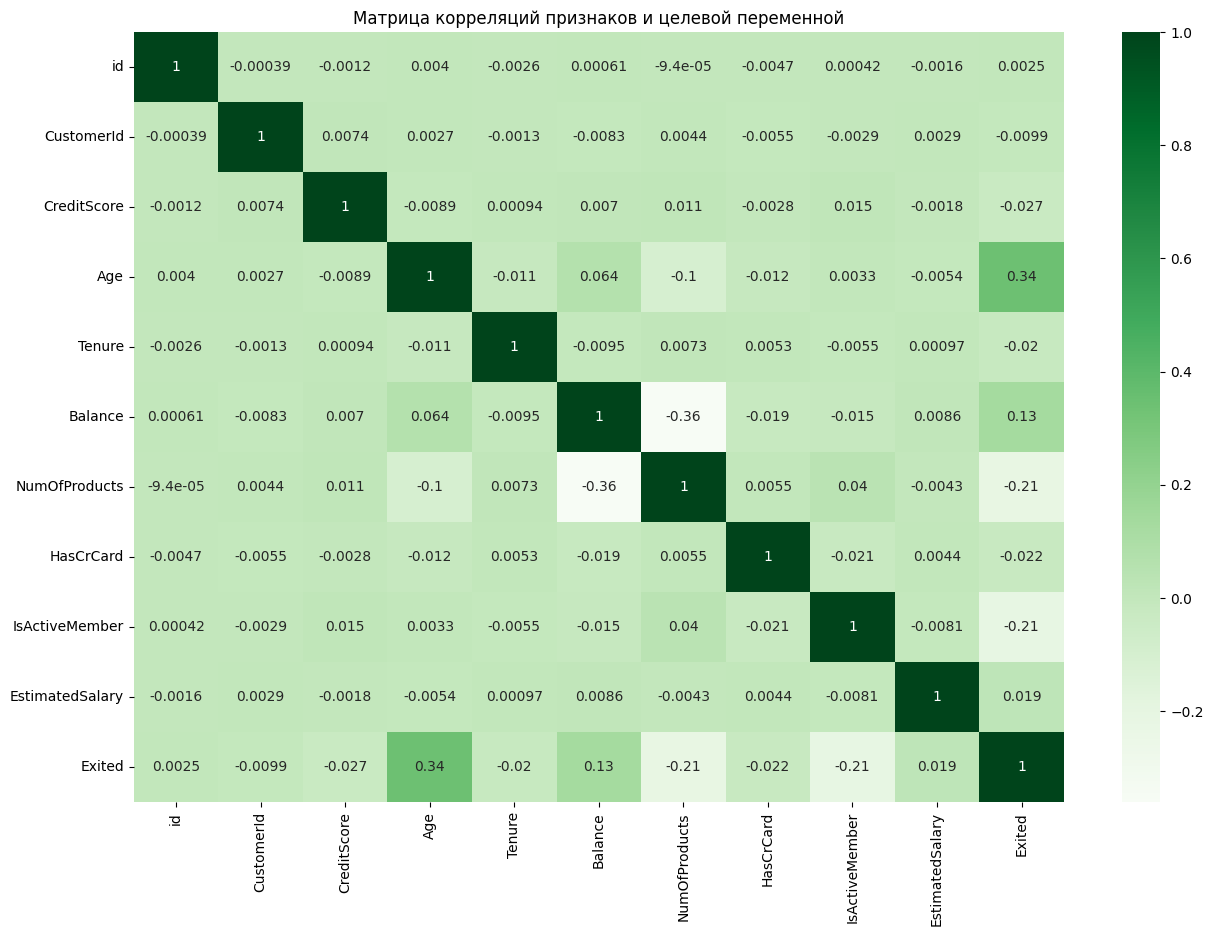

In [5]:
# Посторим тепловую карту линейной корреляции числовых признаков и целевой переменной
plt.figure(figsize=(15, 10))
sns.heatmap(df.drop(['Surname', 'Geography', 'Gender'], axis=1).corr(), annot=True, cmap="Greens")
plt.title('Матрица корреляций признаков и целевой переменной')
plt.show()

Как видно из графика, Id и CustomerId не влияют на то, останется ли клиент с аккаунтом или уйдет, поэтому эти признаки мы исключим. Surname (фамилия) тоже не может оказывать влияния на целевую переменную, поэтому ее мы тоже исключим

In [6]:
# Анализ и обработка пропусков

df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Пропуски в нашем датасете отсутствуют

In [7]:
# 2. Разделение признаков и целевой переменной
X = df.drop(['id', 'CustomerId', 'Exited', 'Surname'], axis=1)
y = df['Exited']

In [8]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Exited, dtype: int64



Целевой признак принимает только два значения (0, 1). Значит он относится к бинарному типу переменных
Нам предстоит решить задачу бинарной классификации. Для этого построим несколько моделей (логистическую регрессию, дерево решений, XGBoost, CatBoost) и выберем лучшую на основе метрик.

# <font color='#11a642' size='6'> **Разведочный анализ данных(можно переиспользовать из ДЗ 9)**

In [9]:
# Сколько ГБ ваш датасет
memory_b = df.memory_usage(deep=True).sum()
memory_mb = memory_b / 1024 ** 2
memory_gb = memory_mb / 1024
print('Объем памяти, который занимает дадасет:')
print('Объем памяти в байтах: {:03.3f} B'.format(memory_b))
print('Объем памяти в мегабайтах: {:03.3f} MB'.format(memory_mb))
print('Объем памяти в гигабайтах: {:03.3f} GB'.format(memory_gb))

Объем памяти, который занимает дадасет:
Объем памяти в байтах: 41655470.000 B
Объем памяти в мегабайтах: 39.726 MB
Объем памяти в гигабайтах: 0.039 GB


In [10]:
# Сколько строк и столбцов
num_rows = df.shape[0]
num_columns = df.shape[1]
print('Количество строк:', num_rows)
print('Количество столбцов:', num_columns)

Количество строк: 165034
Количество столбцов: 14


In [11]:
# Определяем категориальные и числовые признаки
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=np.number).columns
print('Категориальные признаки:', list(categorical_features))
print('Числовые признаки:', list(numerical_features))

Категориальные признаки: ['Geography', 'Gender']
Числовые признаки: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


Анализ числовых признаков

In [12]:
# Минимум (min), максимум (max), среднее (mean), медиана (50%) для всех признаков

print(X[numerical_features].describe().loc[['mean', 'min', 'max', '50%']])

      CreditScore        Age     Tenure        Balance  NumOfProducts  \
mean   656.454373  38.125888   5.020353   55478.086689       1.554455   
min    350.000000  18.000000   0.000000       0.000000       1.000000   
max    850.000000  92.000000  10.000000  250898.090000       4.000000   
50%    659.000000  37.000000   5.000000       0.000000       2.000000   

      HasCrCard  IsActiveMember  EstimatedSalary  
mean   0.753954         0.49777    112574.822734  
min    0.000000         0.00000        11.580000  
max    1.000000         1.00000    199992.480000  
50%    1.000000         0.00000    117948.000000  


Анализ категориальных признаков

In [13]:
# Мода, количество уникальных значений для категориальных признаков

df_mode = X[categorical_features].mode()
df_unique = X[categorical_features].nunique()
print("Мода:")
print(df_mode)
print("-" * 50)
print('Количество уникальных значений')
print(df_unique)

Мода:
  Geography Gender
0    France   Male
--------------------------------------------------
Количество уникальных значений
Geography    3
Gender       2
dtype: int64


In [14]:
X['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [15]:
X['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Анализ целевой переменной

In [16]:
# Доля 1
y.value_counts(normalize=True)


Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

In [17]:
# Выведем в процентном соотношении долю 1 в целевой переменной
proportion_1 = (y == 1).mean() * 100
print(f'Доля 1 составляет: {proportion_1:.2f} %')

Доля 1 составляет: 21.16 %


In [18]:
# Разделение данных на трейн и тест

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

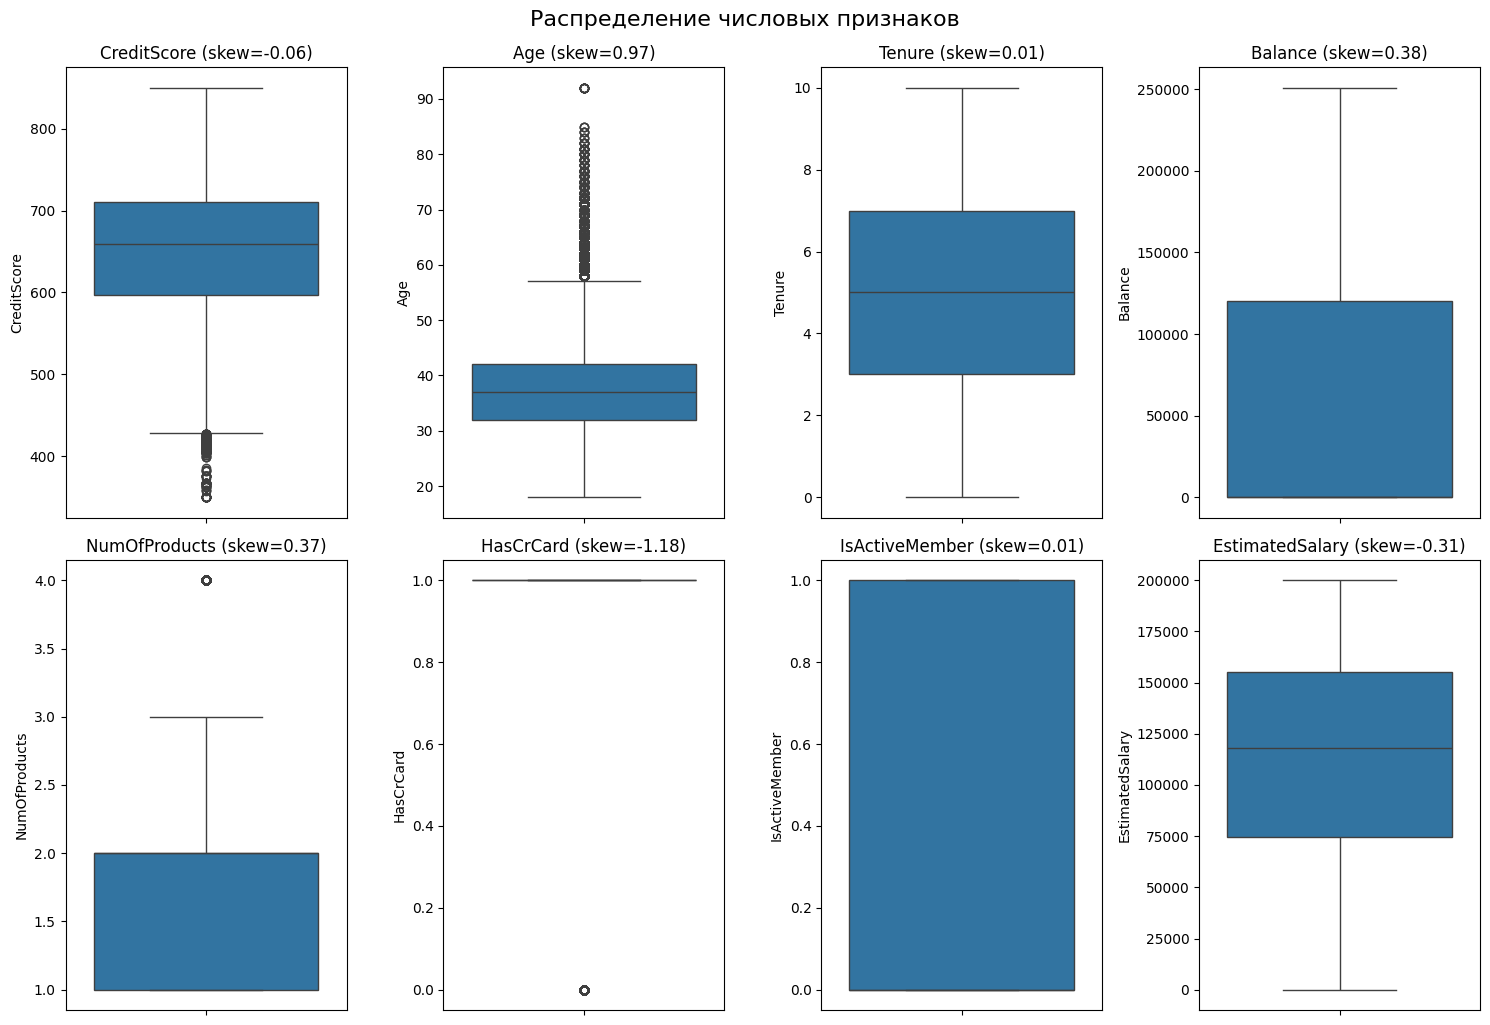

In [19]:
# Визуализация выбросов с помощью boxplot

plt.figure(figsize=(15, 10))
n_cols = len(numerical_features) // 3
n_rows = 3 if len(numerical_features) % 3 == 0 else 4
for i, col in enumerate(numerical_features):
    plt.subplot(n_cols, n_rows, i + 1)
    sns.boxplot(df[col])
    plt.title(f'{col} (skew={df[col].skew():.2f})')
plt.tight_layout()
plt.suptitle("Распределение числовых признаков", fontsize=16, y=1.02)
plt.show()

Как видно на графиках, все выбросы укладываются в нормальные значения, поэтому обрабатывать выбросы мы не будем

# <font color='#11a642' size='6'> **Построение моделей с помощью pipeline + подбор гиперпараметров**

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

Построение модели логистической регрессии

In [21]:
pipeline= Pipeline(steps=[
    ('preprocessor', preprocessor), # preprocessor.fit() будет вызван на X_train
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [23]:
# Получение вероятностей логистической регрессии
y_train_proba_lr = pipeline.predict_proba(X_train)[:, 1]
y_test_proba_lr = pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = pipeline.predict(X_test)

In [24]:
# Вычисление метрик логистической регрессии
accuracy_lr = accuracy_score(y_test, y_pred_lr)

precision_lr = precision_score(y_test, y_pred_lr)

recall_lr = recall_score(y_test, y_pred_lr)

f1_lr = f1_score(y_test, y_pred_lr)

roc_auc_lr = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])


# Вывод результатов
print(f'Accuracy логистической регрессии: {accuracy_lr:.2f}')

print(f'Precision логистической регрессии: {precision_lr:.2f}')

print(f'Recall логистической регрессии: {recall_lr:.2f}')

print(f'F1-score логистической регрессии: {f1_lr:.2f}')

print(f'ROC-AUC логистической регрессии: {roc_auc_lr:.3f}')


Accuracy логистической регрессии: 0.83
Precision логистической регрессии: 0.69
Recall логистической регрессии: 0.38
F1-score логистической регрессии: 0.49
ROC-AUC логистической регрессии: 0.815


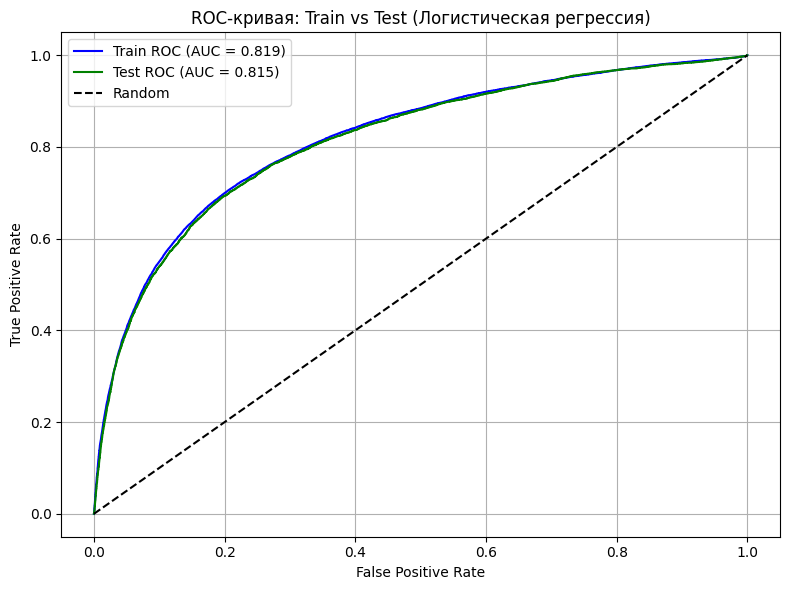

In [25]:
# ROC-кривая + AUC логистической регрессии
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_lr)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_lr)

auc_train = roc_auc_score(y_train, y_train_proba_lr)
auc_test = roc_auc_score(y_test, y_test_proba_lr)

# Построение ROC-графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: Train vs Test (Логистическая регрессия)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Построение модели дерева решений

In [26]:

model_dt = DecisionTreeClassifier(random_state=42)

pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', model_dt)
])

# создаём словарь с гиперпараметрами
parameters = {
    'max_depth': distributions.IntDistribution(3, 17),
    'min_samples_split': distributions.IntDistribution(9, 10)
}


pipe_dt = make_pipeline(preprocessor,
                     OptunaSearchCV(model_dt, parameters, cv=5, n_trials=100, random_state=42, scoring = 'roc_auc'))
pipe_dt.fit(X_train, y_train)



C:\Users\Maks\AppData\Local\Temp\ipykernel_11552\218307160.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  OptunaSearchCV(model_dt, parameters, cv=5, n_trials=100, random_state=42, scoring = 'roc_auc'))
[I 2025-07-08 11:05:16,353] A new study created in memory with name: no-name-1c7d6178-01da-4f4e-842d-9898c5fd2779
[I 2025-07-08 11:05:22,571] Trial 0 finished with value: 0.8784595737992301 and parameters: {'max_depth': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.8784595737992301.
[I 2025-07-08 11:05:25,539] Trial 1 finished with value: 0.8604457538444912 and parameters: {'max_depth': 4, 'min_samples_split': 9}. Best is trial 0 with value: 0.8784595737992301.
[I 2025-07-08 11:05:32,019] Trial 2 finished with value: 0.8714018753480757 and parameters: {'max_depth': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.8784595737992301.
[I 2025-07-08 11:05:36,775] Trial 3 finished with value:

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('optunasearchcv',
                 OptunaSearchCV(cv=5,
                                estimator=DecisionTreeClassifier(random_state=42),
                                n_jobs=1, n_trials=100,
                                param_distributions={'max_depth': IntDistribution(high=17, log=False, low=3, step=1),
                                                     'min_samples_split': IntDistribution(high=10, log=False, low=9, step=1)},
                                random_state=42, scoring='roc_auc'))])

In [27]:
# Получение вероятностей дерева решений
y_train_proba_dt = pipe_dt.predict_proba(X_train)[:, 1]
y_test_proba_dt = pipe_dt.predict_proba(X_test)[:, 1]
y_pred_dt = pipe_dt.predict(X_test)

In [28]:
# Вычисление метрик дерева решений
accuracy_dt = accuracy_score(y_test, y_pred_dt)

precision_dt = precision_score(y_test, y_pred_dt)

recall_dt = recall_score(y_test, y_pred_dt)

f1_dt = f1_score(y_test, y_pred_dt)

roc_auc_dt = roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])


# Вывод результатов
print(f'Accuracy дерева решений: {accuracy_dt:.2f}')

print(f'Precision дерева решений: {precision_dt:.2f}')

print(f'Recall дерева решений: {recall_dt:.2f}')

print(f'F1-score дерева решений: {f1_dt:.2f}')

print(f'ROC-AUC дерева решений: {roc_auc_dt:.3f}')

Accuracy дерева решений: 0.86
Precision дерева решений: 0.74
Recall дерева решений: 0.54
F1-score дерева решений: 0.63
ROC-AUC дерева решений: 0.884


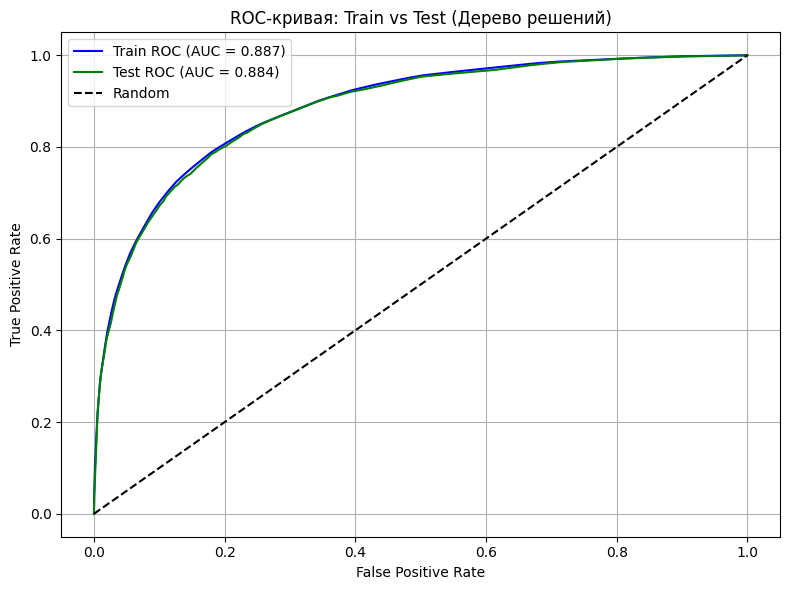

In [29]:
# ROC-кривая + AUC дерева решений
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_dt)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_dt)

auc_train = roc_auc_score(y_train, y_train_proba_dt)
auc_test = roc_auc_score(y_test, y_test_proba_dt)

# Построение ROC-графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: Train vs Test (Дерево решений)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Построение модели XGBoost

In [30]:

model_xgb = XGBClassifier(random_state=42, n_estimators=100, subsample=0.5, colsample_bytree=0.2)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', model_xgb)
])

# создаём словарь с гиперпараметрами
parameters = {
    'max_depth': distributions.IntDistribution(3, 7, 2),
    'min_child_weight': distributions.IntDistribution(1, 9, 4),
    'learning_rate': distributions.FloatDistribution(0.01, 0.1, 0.04)
}

pipe_xgb = make_pipeline(preprocessor,
                     OptunaSearchCV(model_xgb, parameters, cv=5, n_trials=100, random_state=42, scoring = 'roc_auc'))
pipe_xgb.fit(X_train, y_train)

C:\Users\Maks\AppData\Local\Temp\ipykernel_11552\1339562306.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  OptunaSearchCV(model_xgb, parameters, cv=5, n_trials=100, random_state=42, scoring = 'roc_auc'))
[I 2025-07-08 11:13:27,713] A new study created in memory with name: no-name-dc74e4bc-a352-48eb-9b46-ad33cd2f4d6e
[I 2025-07-08 11:13:34,737] Trial 0 finished with value: 0.8643910927121743 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'learning_rate': 0.011723339468425801}. Best is trial 0 with value: 0.8643910927121743.
[I 2025-07-08 11:13:41,964] Trial 1 finished with value: 0.8678192088748673 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.019872917579712143}. Best is trial 1 with value: 0.8678192088748673.
[I 2025-07-08 11:13:49,163] Trial 2 finished with value: 0.8652851531210773 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.01500449235

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('optunasea...
                                                        monotone_constraints=None,
                                                        multi_strategy=None,
                                                        n_estimators=100,
                                                        n_jobs=None,
                                                        num_parallel_tree=None, ...),
                                n_jobs=1, n_trials=100,
                                param_distributions={'learning_rate': FloatDistribution(high=0.1, log=0.04, low=0.01, step=None),
                                                     'max_depth': IntDistribution(high=7, log=2, low=3, step=1),
                                                     'min_child_weight': IntDistribution(high=9, log=4, low=1, step=1)},
                                random_state=42, scoring='roc_auc'))])

In [31]:
# Получение вероятностей модели XGBoost
y_train_proba_xgb = pipe_xgb.predict_proba(X_train)[:, 1]
y_test_proba_xgb = pipe_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = pipe_xgb.predict(X_test)

In [32]:
# Вычисление метрик модели XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

precision_xgb = precision_score(y_test, y_pred_xgb)

recall_xgb = recall_score(y_test, y_pred_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb)

roc_auc_xgb = roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:, 1])


# Вывод результатов
print(f'Accuracy модели XGBoost: {accuracy_xgb:.2f}')

print(f'Precision модели XGBoost: {precision_xgb:.2f}')

print(f'Recall модели XGBoost: {recall_xgb:.2f}')

print(f'F1-score модели XGBoost: {f1_xgb:.2f}')

print(f'ROC-AUC модели XGBoost: {roc_auc_xgb:.3f}')

Accuracy модели XGBoost: 0.86
Precision модели XGBoost: 0.80
Recall модели XGBoost: 0.45
F1-score модели XGBoost: 0.57
ROC-AUC модели XGBoost: 0.880


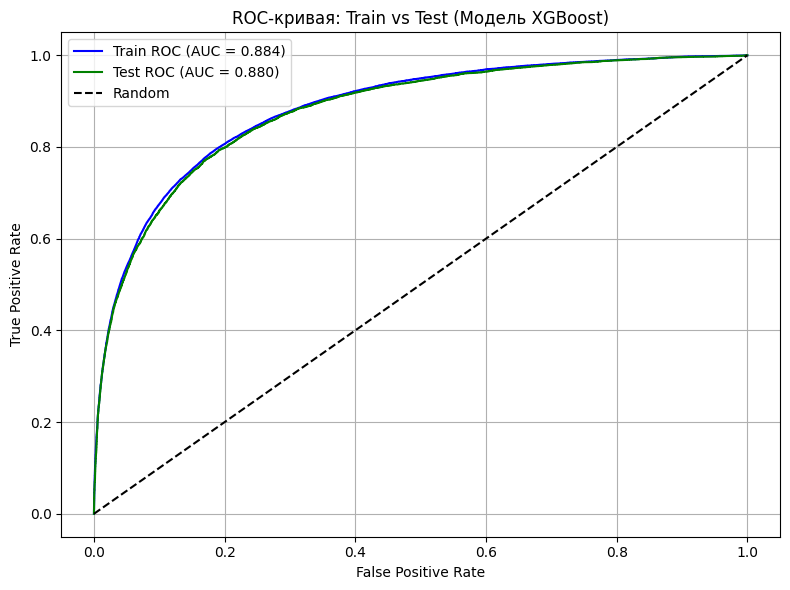

In [33]:
# ROC-кривая + AUC модели XGBoost
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_xgb)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_xgb)

auc_train = roc_auc_score(y_train, y_train_proba_xgb)
auc_test = roc_auc_score(y_test, y_test_proba_xgb)

# Построение ROC-графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: Train vs Test (Модель XGBoost)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Построение модели CatBoost

In [34]:

model_cb = CatBoostClassifier(random_state=42)

pipeline_cb = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', model_cb)
])

# создаём словарь с гиперпараметрами
parameters = {
    'iterations': distributions.IntDistribution(3, 9, 3),
    'depth': distributions.IntDistribution(3, 7, 2),
    'learning_rate': distributions.FloatDistribution(0.01, 0.1, 0.04),
    'l2_leaf_reg': distributions.IntDistribution(2, 30, 10),
    'border_count': distributions.IntDistribution(2, 6, 2)
}


pipe_cb = make_pipeline(preprocessor,
                     OptunaSearchCV(model_cb, parameters, cv=5, n_trials=100, random_state=42, scoring = 'roc_auc'))
pipe_cb.fit(X_train, y_train)

C:\Users\Maks\AppData\Local\Temp\ipykernel_11552\819563753.py:19: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  OptunaSearchCV(model_cb, parameters, cv=5, n_trials=100, random_state=42, scoring = 'roc_auc'))
[I 2025-07-08 11:28:51,887] A new study created in memory with name: no-name-3f840e82-edc5-418d-8c01-4fbe58f2fed6


0:	learn: 0.6863557	total: 220ms	remaining: 879ms
1:	learn: 0.6800603	total: 257ms	remaining: 385ms
2:	learn: 0.6736650	total: 302ms	remaining: 202ms
3:	learn: 0.6674461	total: 359ms	remaining: 89.7ms
4:	learn: 0.6612494	total: 437ms	remaining: 0us
0:	learn: 0.6863474	total: 52.6ms	remaining: 211ms
1:	learn: 0.6800349	total: 96.2ms	remaining: 144ms
2:	learn: 0.6736541	total: 146ms	remaining: 97.2ms
3:	learn: 0.6674337	total: 193ms	remaining: 48.3ms
4:	learn: 0.6612311	total: 243ms	remaining: 0us
0:	learn: 0.6863688	total: 89.8ms	remaining: 359ms
1:	learn: 0.6800507	total: 155ms	remaining: 232ms
2:	learn: 0.6736986	total: 205ms	remaining: 136ms
3:	learn: 0.6674741	total: 247ms	remaining: 61.8ms
4:	learn: 0.6612835	total: 285ms	remaining: 0us
0:	learn: 0.6863731	total: 56ms	remaining: 224ms
1:	learn: 0.6801064	total: 98.7ms	remaining: 148ms
2:	learn: 0.6737271	total: 144ms	remaining: 95.8ms
3:	learn: 0.6675255	total: 185ms	remaining: 46.2ms
4:	learn: 0.6613472	total: 209ms	remaining: 0us

[I 2025-07-08 11:29:07,876] Trial 0 finished with value: 0.8754015315971035 and parameters: {'iterations': 5, 'depth': 6, 'learning_rate': 0.011723339468425801, 'l2_leaf_reg': 4, 'border_count': 3}. Best is trial 0 with value: 0.8754015315971035.


0:	learn: 0.6854774	total: 46.5ms	remaining: 140ms
1:	learn: 0.6781688	total: 81.1ms	remaining: 81.1ms
2:	learn: 0.6708974	total: 123ms	remaining: 41ms
3:	learn: 0.6638468	total: 162ms	remaining: 0us
0:	learn: 0.6854391	total: 20.2ms	remaining: 60.7ms
1:	learn: 0.6781699	total: 36.9ms	remaining: 36.9ms
2:	learn: 0.6708799	total: 57.9ms	remaining: 19.3ms
3:	learn: 0.6638215	total: 73.7ms	remaining: 0us
0:	learn: 0.6854498	total: 74.8ms	remaining: 224ms
1:	learn: 0.6781985	total: 108ms	remaining: 108ms
2:	learn: 0.6709270	total: 141ms	remaining: 47ms
3:	learn: 0.6638908	total: 178ms	remaining: 0us
0:	learn: 0.6855182	total: 32.2ms	remaining: 96.6ms
1:	learn: 0.6781898	total: 54.3ms	remaining: 54.3ms
2:	learn: 0.6709591	total: 82.6ms	remaining: 27.5ms
3:	learn: 0.6639472	total: 110ms	remaining: 0us
0:	learn: 0.6854659	total: 41.3ms	remaining: 124ms
1:	learn: 0.6782034	total: 80.2ms	remaining: 80.2ms
2:	learn: 0.6709606	total: 118ms	remaining: 39.2ms
3:	learn: 0.6639232	total: 164ms	remain

[I 2025-07-08 11:29:22,084] Trial 1 finished with value: 0.8510013790098647 and parameters: {'iterations': 4, 'depth': 3, 'learning_rate': 0.01468070250209044, 'l2_leaf_reg': 3, 'border_count': 2}. Best is trial 0 with value: 0.8754015315971035.


0:	learn: 0.6747808	total: 46.8ms	remaining: 140ms
1:	learn: 0.6573331	total: 97ms	remaining: 97ms
2:	learn: 0.6415870	total: 130ms	remaining: 43.2ms
3:	learn: 0.6269214	total: 172ms	remaining: 0us
0:	learn: 0.6747638	total: 36.3ms	remaining: 109ms
1:	learn: 0.6573037	total: 74.2ms	remaining: 74.2ms
2:	learn: 0.6415534	total: 104ms	remaining: 34.6ms
3:	learn: 0.6268673	total: 143ms	remaining: 0us
0:	learn: 0.6747829	total: 201ms	remaining: 603ms
1:	learn: 0.6573593	total: 281ms	remaining: 281ms
2:	learn: 0.6412079	total: 371ms	remaining: 124ms
3:	learn: 0.6260129	total: 451ms	remaining: 0us
0:	learn: 0.6748447	total: 35.2ms	remaining: 105ms
1:	learn: 0.6574358	total: 69.6ms	remaining: 69.6ms
2:	learn: 0.6413323	total: 100ms	remaining: 33.5ms
3:	learn: 0.6261880	total: 132ms	remaining: 0us
0:	learn: 0.6748149	total: 83ms	remaining: 249ms
1:	learn: 0.6574027	total: 152ms	remaining: 152ms
2:	learn: 0.6412702	total: 206ms	remaining: 68.5ms
3:	learn: 0.6260968	total: 250ms	remaining: 0us


[I 2025-07-08 11:29:32,925] Trial 2 finished with value: 0.8777399669528023 and parameters: {'iterations': 4, 'depth': 7, 'learning_rate': 0.03211327617233713, 'l2_leaf_reg': 3, 'border_count': 3}. Best is trial 2 with value: 0.8777399669528023.


0:	learn: 0.6421390	total: 70.5ms	remaining: 282ms
1:	learn: 0.6010176	total: 132ms	remaining: 198ms
2:	learn: 0.5652622	total: 211ms	remaining: 140ms
3:	learn: 0.5350220	total: 279ms	remaining: 69.7ms
4:	learn: 0.5083258	total: 341ms	remaining: 0us
0:	learn: 0.6419803	total: 64.7ms	remaining: 259ms
1:	learn: 0.6008323	total: 111ms	remaining: 167ms
2:	learn: 0.5650188	total: 163ms	remaining: 109ms
3:	learn: 0.5347621	total: 200ms	remaining: 50.1ms
4:	learn: 0.5080614	total: 237ms	remaining: 0us
0:	learn: 0.6423321	total: 51.4ms	remaining: 205ms
1:	learn: 0.6012652	total: 91.6ms	remaining: 137ms
2:	learn: 0.5655186	total: 139ms	remaining: 92.6ms
3:	learn: 0.5352972	total: 186ms	remaining: 46.6ms
4:	learn: 0.5085937	total: 210ms	remaining: 0us
0:	learn: 0.6424499	total: 34.2ms	remaining: 137ms
1:	learn: 0.6014916	total: 107ms	remaining: 160ms
2:	learn: 0.5657895	total: 168ms	remaining: 112ms
3:	learn: 0.5356094	total: 297ms	remaining: 74.3ms
4:	learn: 0.5089900	total: 352ms	remaining: 0u

[I 2025-07-08 11:29:45,271] Trial 3 finished with value: 0.8744949577759054 and parameters: {'iterations': 5, 'depth': 6, 'learning_rate': 0.09413317562222692, 'l2_leaf_reg': 6, 'border_count': 6}. Best is trial 2 with value: 0.8777399669528023.


0:	learn: 0.6502449	total: 45.9ms	remaining: 183ms
1:	learn: 0.6129490	total: 79.2ms	remaining: 119ms
2:	learn: 0.5807498	total: 110ms	remaining: 73.5ms
3:	learn: 0.5531108	total: 140ms	remaining: 35ms
4:	learn: 0.5289404	total: 170ms	remaining: 0us
0:	learn: 0.6502150	total: 57ms	remaining: 228ms
1:	learn: 0.6128889	total: 119ms	remaining: 178ms
2:	learn: 0.5819923	total: 169ms	remaining: 113ms
3:	learn: 0.5547466	total: 211ms	remaining: 52.8ms
4:	learn: 0.5299481	total: 242ms	remaining: 0us
0:	learn: 0.6502738	total: 44ms	remaining: 176ms
1:	learn: 0.6130011	total: 80.8ms	remaining: 121ms
2:	learn: 0.5812806	total: 111ms	remaining: 74ms
3:	learn: 0.5536799	total: 144ms	remaining: 35.9ms
4:	learn: 0.5290484	total: 178ms	remaining: 0us
0:	learn: 0.6503905	total: 66ms	remaining: 264ms
1:	learn: 0.6131945	total: 130ms	remaining: 196ms
2:	learn: 0.5810659	total: 182ms	remaining: 121ms
3:	learn: 0.5531259	total: 226ms	remaining: 56.4ms
4:	learn: 0.5290752	total: 265ms	remaining: 0us
0:	lea

[I 2025-07-08 11:29:55,386] Trial 4 finished with value: 0.8801620109739435 and parameters: {'iterations': 5, 'depth': 7, 'learning_rate': 0.07662632295733593, 'l2_leaf_reg': 2, 'border_count': 3}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6740319	total: 58.4ms	remaining: 350ms
1:	learn: 0.6569897	total: 105ms	remaining: 263ms
2:	learn: 0.6404689	total: 160ms	remaining: 213ms
3:	learn: 0.6249475	total: 206ms	remaining: 154ms
4:	learn: 0.6100925	total: 241ms	remaining: 96.2ms
5:	learn: 0.5964583	total: 274ms	remaining: 45.6ms
6:	learn: 0.5835328	total: 310ms	remaining: 0us
0:	learn: 0.6740193	total: 32.8ms	remaining: 197ms
1:	learn: 0.6569687	total: 65.6ms	remaining: 164ms
2:	learn: 0.6404285	total: 101ms	remaining: 134ms
3:	learn: 0.6248797	total: 133ms	remaining: 99.8ms
4:	learn: 0.6100251	total: 162ms	remaining: 65ms
5:	learn: 0.5963688	total: 196ms	remaining: 32.6ms
6:	learn: 0.5834209	total: 228ms	remaining: 0us
0:	learn: 0.6740264	total: 34.7ms	remaining: 208ms
1:	learn: 0.6570252	total: 64ms	remaining: 160ms
2:	learn: 0.6405127	total: 94.1ms	remaining: 125ms
3:	learn: 0.6250044	total: 126ms	remaining: 94.4ms
4:	learn: 0.6101603	total: 159ms	remaining: 63.5ms
5:	learn: 0.5965328	total: 190ms	remaining: 3

[I 2025-07-08 11:30:07,731] Trial 5 finished with value: 0.8767233565942935 and parameters: {'iterations': 7, 'depth': 6, 'learning_rate': 0.03335113067755891, 'l2_leaf_reg': 2, 'border_count': 4}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6839777	total: 38ms	remaining: 152ms
1:	learn: 0.6751168	total: 72.1ms	remaining: 108ms
2:	learn: 0.6665994	total: 107ms	remaining: 71.4ms
3:	learn: 0.6584288	total: 142ms	remaining: 35.5ms
4:	learn: 0.6504759	total: 179ms	remaining: 0us
0:	learn: 0.6839700	total: 33.8ms	remaining: 135ms
1:	learn: 0.6751074	total: 65.1ms	remaining: 97.7ms
2:	learn: 0.6666011	total: 95.6ms	remaining: 63.8ms
3:	learn: 0.6584241	total: 124ms	remaining: 31ms
4:	learn: 0.6503784	total: 155ms	remaining: 0us
0:	learn: 0.6839677	total: 25ms	remaining: 100ms
1:	learn: 0.6751329	total: 46ms	remaining: 69.1ms
2:	learn: 0.6665832	total: 69.6ms	remaining: 46.4ms
3:	learn: 0.6584496	total: 89.8ms	remaining: 22.5ms
4:	learn: 0.6504135	total: 110ms	remaining: 0us
0:	learn: 0.6840003	total: 44.9ms	remaining: 180ms
1:	learn: 0.6751967	total: 86ms	remaining: 129ms
2:	learn: 0.6667057	total: 123ms	remaining: 82.1ms
3:	learn: 0.6585717	total: 165ms	remaining: 41.3ms
4:	learn: 0.6506720	total: 204ms	remaining: 0

[I 2025-07-08 11:30:18,706] Trial 6 finished with value: 0.8702630514907617 and parameters: {'iterations': 5, 'depth': 5, 'learning_rate': 0.01637805582242402, 'l2_leaf_reg': 5, 'border_count': 5}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6519436	total: 74.4ms	remaining: 149ms
1:	learn: 0.6180201	total: 138ms	remaining: 69.2ms
2:	learn: 0.5875933	total: 191ms	remaining: 0us
0:	learn: 0.6519022	total: 49.6ms	remaining: 99.1ms
1:	learn: 0.6179557	total: 94.1ms	remaining: 47.1ms
2:	learn: 0.5868732	total: 141ms	remaining: 0us
0:	learn: 0.6519735	total: 29ms	remaining: 57.9ms
1:	learn: 0.6180974	total: 50.1ms	remaining: 25.1ms
2:	learn: 0.5870452	total: 77.5ms	remaining: 0us
0:	learn: 0.6520810	total: 57.4ms	remaining: 115ms
1:	learn: 0.6182982	total: 108ms	remaining: 54ms
2:	learn: 0.5873354	total: 177ms	remaining: 0us
0:	learn: 0.6520042	total: 57.8ms	remaining: 116ms
1:	learn: 0.6181473	total: 103ms	remaining: 51.3ms
2:	learn: 0.5871410	total: 160ms	remaining: 0us


[I 2025-07-08 11:30:28,523] Trial 7 finished with value: 0.8732928959189605 and parameters: {'iterations': 3, 'depth': 6, 'learning_rate': 0.07372069340993001, 'l2_leaf_reg': 6, 'border_count': 2}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6497975	total: 54.9ms	remaining: 165ms
1:	learn: 0.6130321	total: 101ms	remaining: 101ms
2:	learn: 0.5814573	total: 144ms	remaining: 47.9ms
3:	learn: 0.5540391	total: 190ms	remaining: 0us
0:	learn: 0.6497603	total: 49.5ms	remaining: 149ms
1:	learn: 0.6129657	total: 90.4ms	remaining: 90.4ms
2:	learn: 0.5814073	total: 130ms	remaining: 43.4ms
3:	learn: 0.5539494	total: 170ms	remaining: 0us
0:	learn: 0.6498625	total: 25.9ms	remaining: 77.7ms
1:	learn: 0.6131582	total: 48.7ms	remaining: 48.7ms
2:	learn: 0.5816513	total: 70.6ms	remaining: 23.5ms
3:	learn: 0.5542447	total: 95.2ms	remaining: 0us
0:	learn: 0.6499223	total: 27.3ms	remaining: 81.8ms
1:	learn: 0.6133431	total: 51ms	remaining: 51ms
2:	learn: 0.5819140	total: 71.7ms	remaining: 23.9ms
3:	learn: 0.5545750	total: 94.9ms	remaining: 0us
0:	learn: 0.6499115	total: 49.5ms	remaining: 148ms
1:	learn: 0.6131935	total: 92.9ms	remaining: 92.9ms
2:	learn: 0.5817067	total: 133ms	remaining: 44.2ms
3:	learn: 0.5543445	total: 175ms	remai

[I 2025-07-08 11:30:38,533] Trial 8 finished with value: 0.8723525118852089 and parameters: {'iterations': 4, 'depth': 5, 'learning_rate': 0.08085429270598109, 'l2_leaf_reg': 23, 'border_count': 2}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6769589	total: 36.6ms	remaining: 146ms
1:	learn: 0.6616580	total: 72.3ms	remaining: 108ms
2:	learn: 0.6473070	total: 109ms	remaining: 72.6ms
3:	learn: 0.6337027	total: 146ms	remaining: 36.5ms
4:	learn: 0.6208552	total: 182ms	remaining: 0us
0:	learn: 0.6769424	total: 20ms	remaining: 80ms
1:	learn: 0.6616606	total: 42.3ms	remaining: 63.5ms
2:	learn: 0.6472708	total: 63.1ms	remaining: 42.1ms
3:	learn: 0.6336694	total: 82.9ms	remaining: 20.7ms
4:	learn: 0.6208249	total: 103ms	remaining: 0us
0:	learn: 0.6769657	total: 30.3ms	remaining: 121ms
1:	learn: 0.6617385	total: 55ms	remaining: 82.5ms
2:	learn: 0.6473593	total: 79.6ms	remaining: 53.1ms
3:	learn: 0.6338010	total: 104ms	remaining: 25.9ms
4:	learn: 0.6209842	total: 130ms	remaining: 0us
0:	learn: 0.6770056	total: 47.9ms	remaining: 192ms
1:	learn: 0.6618035	total: 85.7ms	remaining: 129ms
2:	learn: 0.6474770	total: 125ms	remaining: 83.2ms
3:	learn: 0.6339361	total: 163ms	remaining: 40.8ms
4:	learn: 0.6211475	total: 207ms	remaini

[I 2025-07-08 11:30:49,634] Trial 9 finished with value: 0.8514835843085917 and parameters: {'iterations': 5, 'depth': 4, 'learning_rate': 0.029809108536082356, 'l2_leaf_reg': 19, 'border_count': 5}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6619985	total: 29ms	remaining: 203ms
1:	learn: 0.6349715	total: 55.9ms	remaining: 168ms
2:	learn: 0.6102566	total: 72.5ms	remaining: 121ms
3:	learn: 0.5882086	total: 88.7ms	remaining: 88.7ms
4:	learn: 0.5684778	total: 106ms	remaining: 63.5ms
5:	learn: 0.5507883	total: 123ms	remaining: 40.9ms
6:	learn: 0.5347648	total: 139ms	remaining: 19.9ms
7:	learn: 0.5203405	total: 156ms	remaining: 0us
0:	learn: 0.6619552	total: 69.3ms	remaining: 485ms
1:	learn: 0.6349234	total: 106ms	remaining: 319ms
2:	learn: 0.6102067	total: 172ms	remaining: 287ms
3:	learn: 0.5881399	total: 214ms	remaining: 214ms
4:	learn: 0.5684228	total: 281ms	remaining: 169ms
5:	learn: 0.5506898	total: 338ms	remaining: 113ms
6:	learn: 0.5346457	total: 373ms	remaining: 53.3ms
7:	learn: 0.5202120	total: 392ms	remaining: 0us
0:	learn: 0.6620238	total: 35.4ms	remaining: 248ms
1:	learn: 0.6350357	total: 72.4ms	remaining: 217ms
2:	learn: 0.6103615	total: 104ms	remaining: 174ms
3:	learn: 0.5883654	total: 134ms	remaining: 

[I 2025-07-08 11:30:58,747] Trial 10 finished with value: 0.8501923351431595 and parameters: {'iterations': 8, 'depth': 3, 'learning_rate': 0.061024368786699944, 'l2_leaf_reg': 10, 'border_count': 3}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6664063	total: 44.4ms	remaining: 88.8ms
1:	learn: 0.6417517	total: 82ms	remaining: 41ms
2:	learn: 0.6201712	total: 116ms	remaining: 0us
0:	learn: 0.6663886	total: 40.1ms	remaining: 80.2ms
1:	learn: 0.6417177	total: 81ms	remaining: 40.5ms
2:	learn: 0.6201022	total: 113ms	remaining: 0us
0:	learn: 0.6664327	total: 104ms	remaining: 208ms
1:	learn: 0.6417856	total: 188ms	remaining: 93.8ms
2:	learn: 0.6196019	total: 242ms	remaining: 0us
0:	learn: 0.6664957	total: 32ms	remaining: 64.1ms
1:	learn: 0.6419033	total: 65.7ms	remaining: 32.8ms
2:	learn: 0.6197959	total: 93.3ms	remaining: 0us
0:	learn: 0.6664535	total: 65.8ms	remaining: 132ms
1:	learn: 0.6418471	total: 118ms	remaining: 59.1ms
2:	learn: 0.6196944	total: 158ms	remaining: 0us


[I 2025-07-08 11:31:09,744] Trial 11 finished with value: 0.8779394440468671 and parameters: {'iterations': 3, 'depth': 7, 'learning_rate': 0.047024620142435046, 'l2_leaf_reg': 2, 'border_count': 3}. Best is trial 4 with value: 0.8801620109739435.


0:	learn: 0.6662263	total: 58.1ms	remaining: 116ms
1:	learn: 0.6413944	total: 107ms	remaining: 53.7ms
2:	learn: 0.6188177	total: 153ms	remaining: 0us
0:	learn: 0.6661932	total: 30.9ms	remaining: 61.8ms
1:	learn: 0.6413532	total: 59.4ms	remaining: 29.7ms
2:	learn: 0.6187397	total: 91.4ms	remaining: 0us
0:	learn: 0.6662457	total: 88.6ms	remaining: 177ms
1:	learn: 0.6414190	total: 151ms	remaining: 75.7ms
2:	learn: 0.6188410	total: 235ms	remaining: 0us
0:	learn: 0.6663133	total: 34.4ms	remaining: 68.7ms
1:	learn: 0.6415528	total: 61.3ms	remaining: 30.6ms
2:	learn: 0.6190416	total: 88.7ms	remaining: 0us
0:	learn: 0.6662686	total: 36.4ms	remaining: 72.8ms
1:	learn: 0.6414885	total: 92.2ms	remaining: 46.1ms
2:	learn: 0.6189364	total: 142ms	remaining: 0us


[I 2025-07-08 11:31:18,384] Trial 12 finished with value: 0.880545680513604 and parameters: {'iterations': 3, 'depth': 7, 'learning_rate': 0.04737556264593073, 'l2_leaf_reg': 2, 'border_count': 4}. Best is trial 12 with value: 0.880545680513604.


0:	learn: 0.6677788	total: 25.5ms	remaining: 127ms
1:	learn: 0.6447367	total: 52.2ms	remaining: 104ms
2:	learn: 0.6236999	total: 71.2ms	remaining: 71.2ms
3:	learn: 0.6044352	total: 90.2ms	remaining: 45.1ms
4:	learn: 0.5867605	total: 109ms	remaining: 21.8ms
5:	learn: 0.5704909	total: 129ms	remaining: 0us
0:	learn: 0.6677655	total: 28ms	remaining: 140ms
1:	learn: 0.6447087	total: 52.9ms	remaining: 106ms
2:	learn: 0.6236317	total: 77.1ms	remaining: 77.1ms
3:	learn: 0.6043869	total: 100ms	remaining: 50ms
4:	learn: 0.5866844	total: 122ms	remaining: 24.5ms
5:	learn: 0.5704406	total: 149ms	remaining: 0us
0:	learn: 0.6678455	total: 31.7ms	remaining: 158ms
1:	learn: 0.6447860	total: 70.3ms	remaining: 141ms
2:	learn: 0.6237963	total: 115ms	remaining: 115ms
3:	learn: 0.6045488	total: 150ms	remaining: 75.1ms
4:	learn: 0.5869294	total: 184ms	remaining: 36.8ms
5:	learn: 0.5706955	total: 218ms	remaining: 0us
0:	learn: 0.6678784	total: 47.7ms	remaining: 239ms
1:	learn: 0.6449147	total: 86.3ms	remainin

[I 2025-07-08 11:31:29,958] Trial 13 finished with value: 0.8530414108859359 and parameters: {'iterations': 6, 'depth': 4, 'learning_rate': 0.04692138775045638, 'l2_leaf_reg': 11, 'border_count': 4}. Best is trial 12 with value: 0.880545680513604.


0:	learn: 0.6631645	total: 30.4ms	remaining: 60.8ms
1:	learn: 0.6358260	total: 60.2ms	remaining: 30.1ms
2:	learn: 0.6112280	total: 91.3ms	remaining: 0us
0:	learn: 0.6631297	total: 58.4ms	remaining: 117ms
1:	learn: 0.6357813	total: 115ms	remaining: 57.6ms
2:	learn: 0.6111361	total: 169ms	remaining: 0us
0:	learn: 0.6631859	total: 32.3ms	remaining: 64.6ms
1:	learn: 0.6358507	total: 61.9ms	remaining: 30.9ms
2:	learn: 0.6112492	total: 87.7ms	remaining: 0us
0:	learn: 0.6632649	total: 32.2ms	remaining: 64.3ms
1:	learn: 0.6360018	total: 62.8ms	remaining: 31.4ms
2:	learn: 0.6114710	total: 94ms	remaining: 0us
0:	learn: 0.6632026	total: 36.2ms	remaining: 72.5ms
1:	learn: 0.6359219	total: 65.3ms	remaining: 32.7ms
2:	learn: 0.6113385	total: 93.8ms	remaining: 0us


[I 2025-07-08 11:31:38,406] Trial 14 finished with value: 0.8806204923639991 and parameters: {'iterations': 3, 'depth': 7, 'learning_rate': 0.05290240481332561, 'l2_leaf_reg': 2, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6667776	total: 26.3ms	remaining: 52.6ms
1:	learn: 0.6429312	total: 49.7ms	remaining: 24.8ms
2:	learn: 0.6211813	total: 75.1ms	remaining: 0us
0:	learn: 0.6667754	total: 24.2ms	remaining: 48.3ms
1:	learn: 0.6428993	total: 48.5ms	remaining: 24.3ms
2:	learn: 0.6211534	total: 69.2ms	remaining: 0us
0:	learn: 0.6668124	total: 59.4ms	remaining: 119ms
1:	learn: 0.6430092	total: 105ms	remaining: 52.3ms
2:	learn: 0.6213002	total: 152ms	remaining: 0us
0:	learn: 0.6668833	total: 55ms	remaining: 110ms
1:	learn: 0.6431299	total: 102ms	remaining: 50.8ms
2:	learn: 0.6215001	total: 149ms	remaining: 0us
0:	learn: 0.6668429	total: 37.3ms	remaining: 74.5ms
1:	learn: 0.6430311	total: 68.7ms	remaining: 34.4ms
2:	learn: 0.6213380	total: 99.3ms	remaining: 0us


[I 2025-07-08 11:31:49,681] Trial 15 finished with value: 0.8685338043486566 and parameters: {'iterations': 3, 'depth': 5, 'learning_rate': 0.04769899603126365, 'l2_leaf_reg': 3, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6778070	total: 32.7ms	remaining: 65.4ms
1:	learn: 0.6627639	total: 65.5ms	remaining: 32.8ms
2:	learn: 0.6485693	total: 93.4ms	remaining: 0us
0:	learn: 0.6777856	total: 27.6ms	remaining: 55.1ms
1:	learn: 0.6627400	total: 56.8ms	remaining: 28.4ms
2:	learn: 0.6490638	total: 82.4ms	remaining: 0us
0:	learn: 0.6774960	total: 39.4ms	remaining: 78.8ms
1:	learn: 0.6624948	total: 67.3ms	remaining: 33.7ms
2:	learn: 0.6488468	total: 94ms	remaining: 0us
0:	learn: 0.6775421	total: 83.7ms	remaining: 167ms
1:	learn: 0.6625694	total: 155ms	remaining: 77.4ms
2:	learn: 0.6484309	total: 207ms	remaining: 0us
0:	learn: 0.6775073	total: 31.7ms	remaining: 63.5ms
1:	learn: 0.6625366	total: 63.8ms	remaining: 31.9ms
2:	learn: 0.6489072	total: 87.7ms	remaining: 0us


[I 2025-07-08 11:31:58,052] Trial 16 finished with value: 0.8780814008712534 and parameters: {'iterations': 3, 'depth': 7, 'learning_rate': 0.027249984642149245, 'l2_leaf_reg': 2, 'border_count': 5}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6610350	total: 50.2ms	remaining: 151ms
1:	learn: 0.6325875	total: 97.4ms	remaining: 97.4ms
2:	learn: 0.6071617	total: 143ms	remaining: 47.6ms
3:	learn: 0.5848017	total: 187ms	remaining: 0us
0:	learn: 0.6610009	total: 30.2ms	remaining: 90.7ms
1:	learn: 0.6325207	total: 58.9ms	remaining: 58.9ms
2:	learn: 0.6071057	total: 88.1ms	remaining: 29.4ms
3:	learn: 0.5847218	total: 120ms	remaining: 0us
0:	learn: 0.6610835	total: 51.2ms	remaining: 154ms
1:	learn: 0.6326605	total: 99.7ms	remaining: 99.7ms
2:	learn: 0.6072980	total: 149ms	remaining: 49.5ms
3:	learn: 0.5849737	total: 195ms	remaining: 0us
0:	learn: 0.6611380	total: 23.9ms	remaining: 71.6ms
1:	learn: 0.6328319	total: 48.2ms	remaining: 48.2ms
2:	learn: 0.6075373	total: 70ms	remaining: 23.3ms
3:	learn: 0.5847430	total: 91.2ms	remaining: 0us
0:	learn: 0.6611061	total: 27.5ms	remaining: 82.6ms
1:	learn: 0.6327122	total: 50.4ms	remaining: 50.4ms
2:	learn: 0.6073562	total: 73.9ms	remaining: 24.6ms
3:	learn: 0.5845369	total: 97.2ms

[I 2025-07-08 11:32:08,730] Trial 17 finished with value: 0.8696241333715438 and parameters: {'iterations': 4, 'depth': 5, 'learning_rate': 0.05870639167122633, 'l2_leaf_reg': 9, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6800469	total: 40.1ms	remaining: 80.3ms
1:	learn: 0.6676031	total: 78.8ms	remaining: 39.4ms
2:	learn: 0.6557197	total: 118ms	remaining: 0us
0:	learn: 0.6800450	total: 37.5ms	remaining: 75ms
1:	learn: 0.6675867	total: 72.6ms	remaining: 36.3ms
2:	learn: 0.6557065	total: 105ms	remaining: 0us
0:	learn: 0.6800808	total: 39.6ms	remaining: 79.2ms
1:	learn: 0.6676526	total: 77.7ms	remaining: 38.8ms
2:	learn: 0.6557730	total: 115ms	remaining: 0us
0:	learn: 0.6801403	total: 59.6ms	remaining: 119ms
1:	learn: 0.6677001	total: 107ms	remaining: 53.4ms
2:	learn: 0.6558727	total: 151ms	remaining: 0us
0:	learn: 0.6800842	total: 30.5ms	remaining: 60.9ms
1:	learn: 0.6676522	total: 56.2ms	remaining: 28.1ms
2:	learn: 0.6557887	total: 82.7ms	remaining: 0us


[I 2025-07-08 11:32:18,046] Trial 18 finished with value: 0.8513867456811488 and parameters: {'iterations': 3, 'depth': 4, 'learning_rate': 0.023844951316897543, 'l2_leaf_reg': 4, 'border_count': 6}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6716111	total: 83.1ms	remaining: 665ms
1:	learn: 0.6525823	total: 141ms	remaining: 493ms
2:	learn: 0.6342515	total: 184ms	remaining: 367ms
3:	learn: 0.6172121	total: 224ms	remaining: 281ms
4:	learn: 0.6009930	total: 268ms	remaining: 214ms
5:	learn: 0.5862108	total: 312ms	remaining: 156ms
6:	learn: 0.5722951	total: 347ms	remaining: 99.2ms
7:	learn: 0.5590335	total: 381ms	remaining: 47.6ms
8:	learn: 0.5466072	total: 414ms	remaining: 0us
0:	learn: 0.6715729	total: 36.6ms	remaining: 293ms
1:	learn: 0.6525470	total: 61.5ms	remaining: 215ms
2:	learn: 0.6342132	total: 85.9ms	remaining: 172ms
3:	learn: 0.6171500	total: 115ms	remaining: 144ms
4:	learn: 0.6009206	total: 172ms	remaining: 138ms
5:	learn: 0.5861131	total: 223ms	remaining: 112ms
6:	learn: 0.5721915	total: 288ms	remaining: 82.2ms
7:	learn: 0.5588660	total: 342ms	remaining: 42.8ms
8:	learn: 0.5463941	total: 383ms	remaining: 0us
0:	learn: 0.6716122	total: 55.6ms	remaining: 445ms
1:	learn: 0.6526125	total: 96.4ms	remaining: 

[I 2025-07-08 11:32:29,408] Trial 19 finished with value: 0.8781136652880338 and parameters: {'iterations': 9, 'depth': 6, 'learning_rate': 0.03770207695422055, 'l2_leaf_reg': 3, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6797322	total: 105ms	remaining: 314ms
1:	learn: 0.6665144	total: 162ms	remaining: 162ms
2:	learn: 0.6539258	total: 200ms	remaining: 66.7ms
3:	learn: 0.6420464	total: 239ms	remaining: 0us
0:	learn: 0.6797278	total: 43.9ms	remaining: 132ms
1:	learn: 0.6664981	total: 83.3ms	remaining: 83.3ms
2:	learn: 0.6543443	total: 123ms	remaining: 40.9ms
3:	learn: 0.6428792	total: 166ms	remaining: 0us
0:	learn: 0.6794870	total: 74.8ms	remaining: 224ms
1:	learn: 0.6662706	total: 144ms	remaining: 144ms
2:	learn: 0.6541520	total: 204ms	remaining: 67.9ms
3:	learn: 0.6427169	total: 242ms	remaining: 0us
0:	learn: 0.6795098	total: 59.7ms	remaining: 179ms
1:	learn: 0.6663272	total: 111ms	remaining: 111ms
2:	learn: 0.6537961	total: 165ms	remaining: 54.9ms
3:	learn: 0.6419624	total: 201ms	remaining: 0us
0:	learn: 0.6794852	total: 57.2ms	remaining: 172ms
1:	learn: 0.6663095	total: 108ms	remaining: 108ms
2:	learn: 0.6541981	total: 154ms	remaining: 51.5ms
3:	learn: 0.6427564	total: 204ms	remaining: 0us

[I 2025-07-08 11:32:41,026] Trial 20 finished with value: 0.8777079222150673 and parameters: {'iterations': 4, 'depth': 7, 'learning_rate': 0.02386415470152389, 'l2_leaf_reg': 4, 'border_count': 5}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6582538	total: 107ms	remaining: 643ms
1:	learn: 0.6270472	total: 167ms	remaining: 418ms
2:	learn: 0.5993326	total: 214ms	remaining: 285ms
3:	learn: 0.5749408	total: 244ms	remaining: 183ms
4:	learn: 0.5527624	total: 277ms	remaining: 111ms
5:	learn: 0.5331375	total: 309ms	remaining: 51.4ms
6:	learn: 0.5159492	total: 340ms	remaining: 0us
0:	learn: 0.6582377	total: 46.7ms	remaining: 280ms
1:	learn: 0.6269943	total: 77.7ms	remaining: 194ms
2:	learn: 0.6003882	total: 106ms	remaining: 141ms
3:	learn: 0.5763786	total: 140ms	remaining: 105ms
4:	learn: 0.5540199	total: 176ms	remaining: 70.3ms
5:	learn: 0.5342342	total: 207ms	remaining: 34.6ms
6:	learn: 0.5169880	total: 237ms	remaining: 0us
0:	learn: 0.6582954	total: 71.9ms	remaining: 431ms
1:	learn: 0.6270878	total: 99.7ms	remaining: 249ms
2:	learn: 0.5997798	total: 130ms	remaining: 173ms
3:	learn: 0.5754159	total: 160ms	remaining: 120ms
4:	learn: 0.5531949	total: 189ms	remaining: 75.7ms
5:	learn: 0.5335848	total: 217ms	remaining: 36

[I 2025-07-08 11:32:52,096] Trial 21 finished with value: 0.8796773505671533 and parameters: {'iterations': 7, 'depth': 7, 'learning_rate': 0.06181125710434791, 'l2_leaf_reg': 2, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6380510	total: 42.8ms	remaining: 214ms
1:	learn: 0.5951790	total: 71ms	remaining: 142ms
2:	learn: 0.5580643	total: 106ms	remaining: 106ms
3:	learn: 0.5269952	total: 141ms	remaining: 70.5ms
4:	learn: 0.4998299	total: 180ms	remaining: 36ms
5:	learn: 0.4767869	total: 216ms	remaining: 0us
0:	learn: 0.6380113	total: 50.1ms	remaining: 250ms
1:	learn: 0.5951221	total: 95.3ms	remaining: 191ms
2:	learn: 0.5579702	total: 142ms	remaining: 142ms
3:	learn: 0.5268771	total: 190ms	remaining: 95.2ms
4:	learn: 0.4998368	total: 226ms	remaining: 45.1ms
5:	learn: 0.4773552	total: 252ms	remaining: 0us
0:	learn: 0.6380760	total: 37.3ms	remaining: 186ms
1:	learn: 0.5952814	total: 69.6ms	remaining: 139ms
2:	learn: 0.5581997	total: 102ms	remaining: 102ms
3:	learn: 0.5271524	total: 128ms	remaining: 63.8ms
4:	learn: 0.5001362	total: 155ms	remaining: 31.1ms
5:	learn: 0.4776774	total: 184ms	remaining: 0us
0:	learn: 0.6382495	total: 52.8ms	remaining: 264ms
1:	learn: 0.5955400	total: 94.9ms	remaining: 19

[I 2025-07-08 11:33:03,422] Trial 22 finished with value: 0.8777861700304074 and parameters: {'iterations': 6, 'depth': 6, 'learning_rate': 0.09946871565492857, 'l2_leaf_reg': 2, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6713074	total: 64.6ms	remaining: 323ms
1:	learn: 0.6504183	total: 132ms	remaining: 264ms
2:	learn: 0.6311100	total: 199ms	remaining: 199ms
3:	learn: 0.6133780	total: 244ms	remaining: 122ms
4:	learn: 0.5973520	total: 280ms	remaining: 55.9ms
5:	learn: 0.5824973	total: 321ms	remaining: 0us
0:	learn: 0.6712939	total: 103ms	remaining: 514ms
1:	learn: 0.6503843	total: 189ms	remaining: 379ms
2:	learn: 0.6317882	total: 235ms	remaining: 235ms
3:	learn: 0.6146546	total: 283ms	remaining: 141ms
4:	learn: 0.5977999	total: 331ms	remaining: 66.2ms
5:	learn: 0.5823383	total: 370ms	remaining: 0us
0:	learn: 0.6708899	total: 42.3ms	remaining: 212ms
1:	learn: 0.6500396	total: 82.7ms	remaining: 165ms
2:	learn: 0.6314822	total: 110ms	remaining: 110ms
3:	learn: 0.6144082	total: 138ms	remaining: 68.9ms
4:	learn: 0.5975974	total: 168ms	remaining: 33.7ms
5:	learn: 0.5821763	total: 246ms	remaining: 0us
0:	learn: 0.6709597	total: 62.3ms	remaining: 311ms
1:	learn: 0.6501475	total: 118ms	remaining: 236m

[I 2025-07-08 11:33:14,612] Trial 23 finished with value: 0.8790849074152398 and parameters: {'iterations': 6, 'depth': 7, 'learning_rate': 0.03908018016916842, 'l2_leaf_reg': 3, 'border_count': 5}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6522339	total: 54.9ms	remaining: 165ms
1:	learn: 0.6183883	total: 100ms	remaining: 100ms
2:	learn: 0.5880732	total: 149ms	remaining: 49.6ms
3:	learn: 0.5615643	total: 200ms	remaining: 0us
0:	learn: 0.6522115	total: 38.9ms	remaining: 117ms
1:	learn: 0.6183166	total: 68ms	remaining: 68ms
2:	learn: 0.5879986	total: 101ms	remaining: 33.8ms
3:	learn: 0.5614709	total: 136ms	remaining: 0us
0:	learn: 0.6522753	total: 63.6ms	remaining: 191ms
1:	learn: 0.6184590	total: 111ms	remaining: 111ms
2:	learn: 0.5881773	total: 163ms	remaining: 54.4ms
3:	learn: 0.5616872	total: 217ms	remaining: 0us
0:	learn: 0.6523563	total: 66ms	remaining: 198ms
1:	learn: 0.6186525	total: 115ms	remaining: 115ms
2:	learn: 0.5884057	total: 170ms	remaining: 56.6ms
3:	learn: 0.5619447	total: 222ms	remaining: 0us
0:	learn: 0.6523105	total: 67.6ms	remaining: 203ms
1:	learn: 0.6185064	total: 124ms	remaining: 124ms
2:	learn: 0.5882935	total: 182ms	remaining: 60.8ms
3:	learn: 0.5618307	total: 231ms	remaining: 0us


[I 2025-07-08 11:33:25,997] Trial 24 finished with value: 0.874166723164946 and parameters: {'iterations': 4, 'depth': 6, 'learning_rate': 0.07373271822363675, 'l2_leaf_reg': 14, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6619913	total: 99.7ms	remaining: 498ms
1:	learn: 0.6336907	total: 154ms	remaining: 308ms
2:	learn: 0.6092888	total: 192ms	remaining: 192ms
3:	learn: 0.5870125	total: 227ms	remaining: 113ms
4:	learn: 0.5660707	total: 257ms	remaining: 51.3ms
5:	learn: 0.5473293	total: 290ms	remaining: 0us
0:	learn: 0.6619514	total: 63.8ms	remaining: 319ms
1:	learn: 0.6336303	total: 141ms	remaining: 281ms
2:	learn: 0.6092094	total: 194ms	remaining: 194ms
3:	learn: 0.5873291	total: 233ms	remaining: 117ms
4:	learn: 0.5663229	total: 271ms	remaining: 54.3ms
5:	learn: 0.5475767	total: 307ms	remaining: 0us
0:	learn: 0.6620024	total: 56.3ms	remaining: 281ms
1:	learn: 0.6337085	total: 88.1ms	remaining: 176ms
2:	learn: 0.6086585	total: 115ms	remaining: 115ms
3:	learn: 0.5860297	total: 144ms	remaining: 72.2ms
4:	learn: 0.5651910	total: 177ms	remaining: 35.3ms
5:	learn: 0.5465943	total: 207ms	remaining: 0us
0:	learn: 0.6620842	total: 32.6ms	remaining: 163ms
1:	learn: 0.6338529	total: 64.9ms	remaining: 13

[I 2025-07-08 11:33:35,070] Trial 25 finished with value: 0.8793618060998206 and parameters: {'iterations': 6, 'depth': 7, 'learning_rate': 0.05505954430768149, 'l2_leaf_reg': 2, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6490634	total: 58.9ms	remaining: 353ms
1:	learn: 0.6117265	total: 97.5ms	remaining: 244ms
2:	learn: 0.5797936	total: 137ms	remaining: 183ms
3:	learn: 0.5520713	total: 174ms	remaining: 130ms
4:	learn: 0.5277088	total: 199ms	remaining: 79.5ms
5:	learn: 0.5064221	total: 223ms	remaining: 37.2ms
6:	learn: 0.4879652	total: 244ms	remaining: 0us
0:	learn: 0.6490330	total: 60.4ms	remaining: 362ms
1:	learn: 0.6116813	total: 131ms	remaining: 327ms
2:	learn: 0.5797118	total: 194ms	remaining: 259ms
3:	learn: 0.5520024	total: 233ms	remaining: 175ms
4:	learn: 0.5276181	total: 275ms	remaining: 110ms
5:	learn: 0.5064486	total: 319ms	remaining: 53.1ms
6:	learn: 0.4879163	total: 356ms	remaining: 0us
0:	learn: 0.6491124	total: 47.3ms	remaining: 284ms
1:	learn: 0.6118512	total: 83.5ms	remaining: 209ms
2:	learn: 0.5799701	total: 116ms	remaining: 154ms
3:	learn: 0.5522911	total: 150ms	remaining: 113ms
4:	learn: 0.5279002	total: 182ms	remaining: 72.8ms
5:	learn: 0.5067846	total: 215ms	remaining: 3

[I 2025-07-08 11:33:46,396] Trial 26 finished with value: 0.8742866817678095 and parameters: {'iterations': 7, 'depth': 5, 'learning_rate': 0.08148839854916776, 'l2_leaf_reg': 8, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6707816	total: 82.6ms	remaining: 165ms
1:	learn: 0.6494274	total: 152ms	remaining: 76.1ms
2:	learn: 0.6297117	total: 188ms	remaining: 0us
0:	learn: 0.6707040	total: 56.6ms	remaining: 113ms
1:	learn: 0.6493472	total: 110ms	remaining: 55.2ms
2:	learn: 0.6303264	total: 157ms	remaining: 0us
0:	learn: 0.6708768	total: 54.8ms	remaining: 110ms
1:	learn: 0.6495139	total: 110ms	remaining: 54.9ms
2:	learn: 0.6305477	total: 158ms	remaining: 0us
0:	learn: 0.6709225	total: 62ms	remaining: 124ms
1:	learn: 0.6496120	total: 120ms	remaining: 60.2ms
2:	learn: 0.6299430	total: 181ms	remaining: 0us
0:	learn: 0.6708359	total: 64.4ms	remaining: 129ms
1:	learn: 0.6495285	total: 130ms	remaining: 65.1ms
2:	learn: 0.6305716	total: 167ms	remaining: 0us


[I 2025-07-08 11:33:56,790] Trial 27 finished with value: 0.8772573187886525 and parameters: {'iterations': 3, 'depth': 7, 'learning_rate': 0.040195978678332765, 'l2_leaf_reg': 5, 'border_count': 6}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6564247	total: 63.5ms	remaining: 191ms
1:	learn: 0.6251774	total: 115ms	remaining: 115ms
2:	learn: 0.5966215	total: 176ms	remaining: 58.6ms
3:	learn: 0.5713603	total: 219ms	remaining: 0us
0:	learn: 0.6563876	total: 51.5ms	remaining: 154ms
1:	learn: 0.6250962	total: 92ms	remaining: 92ms
2:	learn: 0.5965420	total: 137ms	remaining: 45.8ms
3:	learn: 0.5712730	total: 185ms	remaining: 0us
0:	learn: 0.6556820	total: 54.4ms	remaining: 163ms
1:	learn: 0.6244993	total: 95.5ms	remaining: 95.5ms
2:	learn: 0.5959655	total: 143ms	remaining: 47.7ms
3:	learn: 0.5707448	total: 192ms	remaining: 0us
0:	learn: 0.6557919	total: 52ms	remaining: 156ms
1:	learn: 0.6246700	total: 98.9ms	remaining: 98.9ms
2:	learn: 0.5961912	total: 146ms	remaining: 48.7ms
3:	learn: 0.5710060	total: 196ms	remaining: 0us
0:	learn: 0.6557335	total: 70.2ms	remaining: 211ms
1:	learn: 0.6245407	total: 128ms	remaining: 128ms
2:	learn: 0.5960527	total: 177ms	remaining: 59.1ms
3:	learn: 0.5708814	total: 219ms	remaining: 0us


[I 2025-07-08 11:34:08,203] Trial 28 finished with value: 0.8726256081512268 and parameters: {'iterations': 4, 'depth': 6, 'learning_rate': 0.06666208058674265, 'l2_leaf_reg': 4, 'border_count': 5}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6662901	total: 79.5ms	remaining: 318ms
1:	learn: 0.6416928	total: 147ms	remaining: 221ms
2:	learn: 0.6195460	total: 190ms	remaining: 126ms
3:	learn: 0.5999526	total: 236ms	remaining: 58.9ms
4:	learn: 0.5810220	total: 282ms	remaining: 0us
0:	learn: 0.6662842	total: 45.7ms	remaining: 183ms
1:	learn: 0.6416780	total: 87.7ms	remaining: 132ms
2:	learn: 0.6195132	total: 122ms	remaining: 81.1ms
3:	learn: 0.6002209	total: 166ms	remaining: 41.4ms
4:	learn: 0.5812523	total: 206ms	remaining: 0us
0:	learn: 0.6663114	total: 62.6ms	remaining: 250ms
1:	learn: 0.6417344	total: 116ms	remaining: 174ms
2:	learn: 0.6196074	total: 159ms	remaining: 106ms
3:	learn: 0.5993901	total: 191ms	remaining: 47.6ms
4:	learn: 0.5805249	total: 225ms	remaining: 0us
0:	learn: 0.6663691	total: 117ms	remaining: 469ms
1:	learn: 0.6418116	total: 196ms	remaining: 295ms
2:	learn: 0.6197255	total: 281ms	remaining: 187ms
3:	learn: 0.5995529	total: 370ms	remaining: 92.6ms
4:	learn: 0.5811664	total: 410ms	remaining: 0us

[I 2025-07-08 11:34:20,522] Trial 29 finished with value: 0.8784862380267884 and parameters: {'iterations': 5, 'depth': 7, 'learning_rate': 0.04920707848481859, 'l2_leaf_reg': 30, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6631255	total: 29.6ms	remaining: 207ms
1:	learn: 0.6363295	total: 51.9ms	remaining: 156ms
2:	learn: 0.6122269	total: 76.9ms	remaining: 128ms
3:	learn: 0.5908384	total: 98ms	remaining: 98ms
4:	learn: 0.5710902	total: 125ms	remaining: 75.2ms
5:	learn: 0.5530409	total: 147ms	remaining: 48.9ms
6:	learn: 0.5367204	total: 173ms	remaining: 24.7ms
7:	learn: 0.5217559	total: 207ms	remaining: 0us
0:	learn: 0.6631262	total: 62.6ms	remaining: 438ms
1:	learn: 0.6363005	total: 115ms	remaining: 346ms
2:	learn: 0.6121711	total: 171ms	remaining: 285ms
3:	learn: 0.5907663	total: 209ms	remaining: 209ms
4:	learn: 0.5710136	total: 255ms	remaining: 153ms
5:	learn: 0.5529601	total: 325ms	remaining: 108ms
6:	learn: 0.5365995	total: 370ms	remaining: 52.9ms
7:	learn: 0.5216367	total: 418ms	remaining: 0us
0:	learn: 0.6631730	total: 65.4ms	remaining: 458ms
1:	learn: 0.6364193	total: 122ms	remaining: 365ms
2:	learn: 0.6123525	total: 158ms	remaining: 263ms
3:	learn: 0.5910020	total: 196ms	remaining: 196

[I 2025-07-08 11:34:34,523] Trial 30 finished with value: 0.8708872148485094 and parameters: {'iterations': 8, 'depth': 5, 'learning_rate': 0.054504768152820064, 'l2_leaf_reg': 3, 'border_count': 4}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6565051	total: 32.9ms	remaining: 197ms
1:	learn: 0.6239286	total: 63.8ms	remaining: 160ms
2:	learn: 0.5951648	total: 93.1ms	remaining: 124ms
3:	learn: 0.5700113	total: 122ms	remaining: 91.8ms
4:	learn: 0.5472455	total: 153ms	remaining: 61.3ms
5:	learn: 0.5272009	total: 184ms	remaining: 30.7ms
6:	learn: 0.5097242	total: 213ms	remaining: 0us
0:	learn: 0.6564880	total: 59.7ms	remaining: 358ms
1:	learn: 0.6238672	total: 115ms	remaining: 287ms
2:	learn: 0.5962646	total: 172ms	remaining: 229ms
3:	learn: 0.5714892	total: 217ms	remaining: 163ms
4:	learn: 0.5485289	total: 248ms	remaining: 99.4ms
5:	learn: 0.5283218	total: 278ms	remaining: 46.3ms
6:	learn: 0.5107858	total: 311ms	remaining: 0us
0:	learn: 0.6565386	total: 99ms	remaining: 594ms
1:	learn: 0.6239627	total: 201ms	remaining: 503ms
2:	learn: 0.5956377	total: 239ms	remaining: 318ms
3:	learn: 0.5704986	total: 283ms	remaining: 212ms
4:	learn: 0.5476879	total: 338ms	remaining: 135ms
5:	learn: 0.5276620	total: 378ms	remaining: 63

[I 2025-07-08 11:34:44,798] Trial 31 finished with value: 0.8796888187482648 and parameters: {'iterations': 7, 'depth': 7, 'learning_rate': 0.06503676797913858, 'l2_leaf_reg': 2, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6540342	total: 70.1ms	remaining: 491ms
1:	learn: 0.6216595	total: 121ms	remaining: 362ms
2:	learn: 0.5923231	total: 179ms	remaining: 299ms
3:	learn: 0.5663098	total: 227ms	remaining: 227ms
4:	learn: 0.5428007	total: 262ms	remaining: 157ms
5:	learn: 0.5219327	total: 301ms	remaining: 100ms
6:	learn: 0.5037459	total: 338ms	remaining: 48.3ms
7:	learn: 0.4871032	total: 375ms	remaining: 0us
0:	learn: 0.6540034	total: 53.8ms	remaining: 376ms
1:	learn: 0.6216103	total: 98.5ms	remaining: 296ms
2:	learn: 0.5916605	total: 148ms	remaining: 247ms
3:	learn: 0.5656414	total: 197ms	remaining: 197ms
4:	learn: 0.5422448	total: 229ms	remaining: 137ms
5:	learn: 0.5218503	total: 259ms	remaining: 86.2ms
6:	learn: 0.5036997	total: 290ms	remaining: 41.4ms
7:	learn: 0.4871054	total: 315ms	remaining: 0us
0:	learn: 0.6540731	total: 36.6ms	remaining: 256ms
1:	learn: 0.6217404	total: 67.6ms	remaining: 203ms
2:	learn: 0.5918330	total: 101ms	remaining: 168ms
3:	learn: 0.5658611	total: 133ms	remaining: 13

[I 2025-07-08 11:34:56,657] Trial 32 finished with value: 0.8770788993813629 and parameters: {'iterations': 8, 'depth': 6, 'learning_rate': 0.06951952028769645, 'l2_leaf_reg': 2, 'border_count': 2}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6493397	total: 42.7ms	remaining: 256ms
1:	learn: 0.6132308	total: 77.1ms	remaining: 193ms
2:	learn: 0.5817330	total: 99.8ms	remaining: 133ms
3:	learn: 0.5548379	total: 124ms	remaining: 93.3ms
4:	learn: 0.5319027	total: 145ms	remaining: 58ms
5:	learn: 0.5117107	total: 166ms	remaining: 27.7ms
6:	learn: 0.4943513	total: 189ms	remaining: 0us
0:	learn: 0.6493459	total: 48.2ms	remaining: 289ms
1:	learn: 0.6132002	total: 89.8ms	remaining: 225ms
2:	learn: 0.5816472	total: 124ms	remaining: 165ms
3:	learn: 0.5547389	total: 164ms	remaining: 123ms
4:	learn: 0.5318026	total: 190ms	remaining: 76.1ms
5:	learn: 0.5115682	total: 216ms	remaining: 35.9ms
6:	learn: 0.4941864	total: 237ms	remaining: 0us
0:	learn: 0.6494050	total: 34.7ms	remaining: 208ms
1:	learn: 0.6133541	total: 65.5ms	remaining: 164ms
2:	learn: 0.5818707	total: 95.4ms	remaining: 127ms
3:	learn: 0.5550128	total: 127ms	remaining: 95.5ms
4:	learn: 0.5321070	total: 158ms	remaining: 63.1ms
5:	learn: 0.5119170	total: 187ms	remainin

[I 2025-07-08 11:35:08,554] Trial 33 finished with value: 0.8503734335581086 and parameters: {'iterations': 7, 'depth': 3, 'learning_rate': 0.08678396433307678, 'l2_leaf_reg': 4, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6870420	total: 78.3ms	remaining: 626ms
1:	learn: 0.6809974	total: 139ms	remaining: 486ms
2:	learn: 0.6752924	total: 180ms	remaining: 361ms
3:	learn: 0.6697661	total: 227ms	remaining: 284ms
4:	learn: 0.6640716	total: 274ms	remaining: 219ms
5:	learn: 0.6585714	total: 329ms	remaining: 164ms
6:	learn: 0.6533377	total: 376ms	remaining: 107ms
7:	learn: 0.6480760	total: 438ms	remaining: 54.7ms
8:	learn: 0.6428627	total: 487ms	remaining: 0us
0:	learn: 0.6870395	total: 73.5ms	remaining: 588ms
1:	learn: 0.6809883	total: 143ms	remaining: 500ms
2:	learn: 0.6752829	total: 195ms	remaining: 390ms
3:	learn: 0.6697489	total: 241ms	remaining: 302ms
4:	learn: 0.6640509	total: 301ms	remaining: 241ms
5:	learn: 0.6585421	total: 351ms	remaining: 175ms
6:	learn: 0.6533128	total: 443ms	remaining: 127ms
7:	learn: 0.6480592	total: 500ms	remaining: 62.5ms
8:	learn: 0.6428439	total: 566ms	remaining: 0us
0:	learn: 0.6870449	total: 66.6ms	remaining: 533ms
1:	learn: 0.6809888	total: 129ms	remaining: 452ms

[I 2025-07-08 11:35:22,683] Trial 34 finished with value: 0.8796086416527965 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.010553942274311374, 'l2_leaf_reg': 3, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6694021	total: 78.9ms	remaining: 394ms
1:	learn: 0.6486050	total: 124ms	remaining: 249ms
2:	learn: 0.6286994	total: 169ms	remaining: 169ms
3:	learn: 0.6103264	total: 196ms	remaining: 98.1ms
4:	learn: 0.5929380	total: 222ms	remaining: 44.5ms
5:	learn: 0.5771137	total: 253ms	remaining: 0us
0:	learn: 0.6693934	total: 51.8ms	remaining: 259ms
1:	learn: 0.6485671	total: 94.1ms	remaining: 188ms
2:	learn: 0.6286586	total: 152ms	remaining: 152ms
3:	learn: 0.6102507	total: 206ms	remaining: 103ms
4:	learn: 0.5928692	total: 239ms	remaining: 47.8ms
5:	learn: 0.5770165	total: 266ms	remaining: 0us
0:	learn: 0.6694212	total: 50.7ms	remaining: 254ms
1:	learn: 0.6486468	total: 94ms	remaining: 188ms
2:	learn: 0.6287606	total: 141ms	remaining: 141ms
3:	learn: 0.6104017	total: 185ms	remaining: 92.5ms
4:	learn: 0.5930281	total: 211ms	remaining: 42.3ms
5:	learn: 0.5769198	total: 239ms	remaining: 0us
0:	learn: 0.6694776	total: 57.7ms	remaining: 288ms
1:	learn: 0.6487528	total: 108ms	remaining: 215

[I 2025-07-08 11:35:33,500] Trial 35 finished with value: 0.8761855025088565 and parameters: {'iterations': 6, 'depth': 6, 'learning_rate': 0.04159804498198169, 'l2_leaf_reg': 2, 'border_count': 3}. Best is trial 14 with value: 0.8806204923639991.


0:	learn: 0.6547703	total: 49.2ms	remaining: 344ms
1:	learn: 0.6208454	total: 93.7ms	remaining: 281ms
2:	learn: 0.5911600	total: 139ms	remaining: 232ms
3:	learn: 0.5652887	total: 179ms	remaining: 179ms
4:	learn: 0.5419321	total: 225ms	remaining: 135ms
5:	learn: 0.5217633	total: 263ms	remaining: 87.8ms
6:	learn: 0.5034338	total: 310ms	remaining: 44.2ms
7:	learn: 0.4873796	total: 352ms	remaining: 0us
0:	learn: 0.6547482	total: 82.1ms	remaining: 575ms
1:	learn: 0.6207842	total: 134ms	remaining: 402ms
2:	learn: 0.5910378	total: 173ms	remaining: 288ms
3:	learn: 0.5651459	total: 200ms	remaining: 200ms
4:	learn: 0.5421707	total: 230ms	remaining: 138ms
5:	learn: 0.5219706	total: 260ms	remaining: 86.6ms
6:	learn: 0.5032185	total: 298ms	remaining: 42.6ms
7:	learn: 0.4871131	total: 330ms	remaining: 0us
0:	learn: 0.6547890	total: 95.3ms	remaining: 667ms
1:	learn: 0.6208827	total: 156ms	remaining: 469ms
2:	learn: 0.5911832	total: 194ms	remaining: 323ms
3:	learn: 0.5653106	total: 226ms	remaining: 22

[I 2025-07-08 11:35:44,119] Trial 36 finished with value: 0.8817366756785537 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.06838364810757452, 'l2_leaf_reg': 3, 'border_count': 4}. Best is trial 36 with value: 0.8817366756785537.


0:	learn: 0.6637734	total: 35.6ms	remaining: 285ms
1:	learn: 0.6380545	total: 58ms	remaining: 203ms
2:	learn: 0.6140018	total: 87.2ms	remaining: 174ms
3:	learn: 0.5922168	total: 117ms	remaining: 146ms
4:	learn: 0.5719205	total: 146ms	remaining: 116ms
5:	learn: 0.5534317	total: 169ms	remaining: 84.6ms
6:	learn: 0.5369026	total: 199ms	remaining: 56.9ms
7:	learn: 0.5214322	total: 226ms	remaining: 28.3ms
8:	learn: 0.5072579	total: 250ms	remaining: 0us
0:	learn: 0.6637506	total: 89.4ms	remaining: 715ms
1:	learn: 0.6380087	total: 142ms	remaining: 496ms
2:	learn: 0.6139457	total: 170ms	remaining: 340ms
3:	learn: 0.5921465	total: 200ms	remaining: 249ms
4:	learn: 0.5718242	total: 229ms	remaining: 184ms
5:	learn: 0.5533211	total: 263ms	remaining: 131ms
6:	learn: 0.5368106	total: 295ms	remaining: 84.2ms
7:	learn: 0.5212982	total: 326ms	remaining: 40.7ms
8:	learn: 0.5070982	total: 357ms	remaining: 0us
0:	learn: 0.6631877	total: 31.8ms	remaining: 254ms
1:	learn: 0.6374902	total: 55.2ms	remaining: 1

[I 2025-07-08 11:35:55,778] Trial 37 finished with value: 0.8772239455393807 and parameters: {'iterations': 9, 'depth': 6, 'learning_rate': 0.05300839768899991, 'l2_leaf_reg': 5, 'border_count': 5}. Best is trial 36 with value: 0.8817366756785537.


0:	learn: 0.6455909	total: 44.9ms	remaining: 315ms
1:	learn: 0.6042087	total: 84ms	remaining: 252ms
2:	learn: 0.5691232	total: 123ms	remaining: 205ms
3:	learn: 0.5395847	total: 162ms	remaining: 162ms
4:	learn: 0.5141110	total: 203ms	remaining: 122ms
5:	learn: 0.4924312	total: 242ms	remaining: 80.8ms
6:	learn: 0.4726771	total: 288ms	remaining: 41.2ms
7:	learn: 0.4560383	total: 332ms	remaining: 0us
0:	learn: 0.6454425	total: 34.1ms	remaining: 239ms
1:	learn: 0.6040376	total: 70.5ms	remaining: 211ms
2:	learn: 0.5702963	total: 100ms	remaining: 167ms
3:	learn: 0.5412642	total: 135ms	remaining: 135ms
4:	learn: 0.5151080	total: 170ms	remaining: 102ms
5:	learn: 0.4937977	total: 207ms	remaining: 68.9ms
6:	learn: 0.4748255	total: 245ms	remaining: 35ms
7:	learn: 0.4572549	total: 289ms	remaining: 0us
0:	learn: 0.6457758	total: 83ms	remaining: 581ms
1:	learn: 0.6043640	total: 165ms	remaining: 496ms
2:	learn: 0.5692802	total: 226ms	remaining: 377ms
3:	learn: 0.5397130	total: 256ms	remaining: 256ms
4

[I 2025-07-08 11:36:07,528] Trial 38 finished with value: 0.882064692816501 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08792896634803742, 'l2_leaf_reg': 7, 'border_count': 6}. Best is trial 38 with value: 0.882064692816501.


0:	learn: 0.6449710	total: 64ms	remaining: 448ms
1:	learn: 0.6031135	total: 122ms	remaining: 367ms
2:	learn: 0.5677404	total: 172ms	remaining: 286ms
3:	learn: 0.5379926	total: 229ms	remaining: 229ms
4:	learn: 0.5123788	total: 261ms	remaining: 157ms
5:	learn: 0.4906212	total: 295ms	remaining: 98.3ms
6:	learn: 0.4708346	total: 326ms	remaining: 46.6ms
7:	learn: 0.4541886	total: 357ms	remaining: 0us
0:	learn: 0.6448014	total: 45.9ms	remaining: 321ms
1:	learn: 0.6029358	total: 92.1ms	remaining: 276ms
2:	learn: 0.5689427	total: 133ms	remaining: 222ms
3:	learn: 0.5396874	total: 174ms	remaining: 174ms
4:	learn: 0.5133859	total: 212ms	remaining: 127ms
5:	learn: 0.4920095	total: 257ms	remaining: 85.6ms
6:	learn: 0.4730100	total: 301ms	remaining: 42.9ms
7:	learn: 0.4554262	total: 338ms	remaining: 0us
0:	learn: 0.6451302	total: 71.6ms	remaining: 501ms
1:	learn: 0.6032678	total: 120ms	remaining: 360ms
2:	learn: 0.5678743	total: 165ms	remaining: 276ms
3:	learn: 0.5381102	total: 206ms	remaining: 206m

[I 2025-07-08 11:36:19,529] Trial 39 finished with value: 0.8820745278488085 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08900098346864535, 'l2_leaf_reg': 6, 'border_count': 6}. Best is trial 39 with value: 0.8820745278488085.


0:	learn: 0.6434716	total: 50.4ms	remaining: 353ms
1:	learn: 0.6031685	total: 93.5ms	remaining: 280ms
2:	learn: 0.5680054	total: 146ms	remaining: 244ms
3:	learn: 0.5381566	total: 195ms	remaining: 195ms
4:	learn: 0.5117036	total: 231ms	remaining: 138ms
5:	learn: 0.4887770	total: 260ms	remaining: 86.6ms
6:	learn: 0.4695565	total: 290ms	remaining: 41.4ms
7:	learn: 0.4524456	total: 320ms	remaining: 0us
0:	learn: 0.6432942	total: 53ms	remaining: 371ms
1:	learn: 0.6029673	total: 94.2ms	remaining: 283ms
2:	learn: 0.5677736	total: 141ms	remaining: 235ms
3:	learn: 0.5379103	total: 178ms	remaining: 178ms
4:	learn: 0.5114549	total: 205ms	remaining: 123ms
5:	learn: 0.4887448	total: 229ms	remaining: 76.4ms
6:	learn: 0.4695185	total: 259ms	remaining: 37ms
7:	learn: 0.4523995	total: 290ms	remaining: 0us
0:	learn: 0.6436541	total: 51.6ms	remaining: 361ms
1:	learn: 0.6034103	total: 98.2ms	remaining: 295ms
2:	learn: 0.5682466	total: 144ms	remaining: 240ms
3:	learn: 0.5384301	total: 193ms	remaining: 193m

[I 2025-07-08 11:36:29,992] Trial 40 finished with value: 0.8787257040720681 and parameters: {'iterations': 8, 'depth': 6, 'learning_rate': 0.0916849592476674, 'l2_leaf_reg': 7, 'border_count': 6}. Best is trial 39 with value: 0.8820745278488085.


0:	learn: 0.6513562	total: 78.3ms	remaining: 548ms
1:	learn: 0.6142256	total: 146ms	remaining: 439ms
2:	learn: 0.5820365	total: 195ms	remaining: 325ms
3:	learn: 0.5544969	total: 233ms	remaining: 233ms
4:	learn: 0.5304002	total: 283ms	remaining: 170ms
5:	learn: 0.5096992	total: 329ms	remaining: 110ms
6:	learn: 0.4904373	total: 370ms	remaining: 52.8ms
7:	learn: 0.4740823	total: 411ms	remaining: 0us
0:	learn: 0.6512387	total: 59.8ms	remaining: 419ms
1:	learn: 0.6140830	total: 111ms	remaining: 334ms
2:	learn: 0.5829661	total: 161ms	remaining: 268ms
3:	learn: 0.5560401	total: 194ms	remaining: 194ms
4:	learn: 0.5312992	total: 224ms	remaining: 135ms
5:	learn: 0.5107848	total: 254ms	remaining: 84.8ms
6:	learn: 0.4924597	total: 285ms	remaining: 40.8ms
7:	learn: 0.4751452	total: 317ms	remaining: 0us
0:	learn: 0.6515164	total: 101ms	remaining: 707ms
1:	learn: 0.6143698	total: 157ms	remaining: 471ms
2:	learn: 0.5822559	total: 190ms	remaining: 316ms
3:	learn: 0.5546840	total: 222ms	remaining: 222ms

[I 2025-07-08 11:36:41,205] Trial 41 finished with value: 0.8812748189306061 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.0776116379283442, 'l2_leaf_reg': 13, 'border_count': 6}. Best is trial 39 with value: 0.8820745278488085.


0:	learn: 0.6481638	total: 68.7ms	remaining: 481ms
1:	learn: 0.6086479	total: 153ms	remaining: 460ms
2:	learn: 0.5747683	total: 235ms	remaining: 392ms
3:	learn: 0.5460909	total: 308ms	remaining: 308ms
4:	learn: 0.5212196	total: 365ms	remaining: 219ms
5:	learn: 0.5002914	total: 412ms	remaining: 137ms
6:	learn: 0.4806615	total: 457ms	remaining: 65.3ms
7:	learn: 0.4638027	total: 505ms	remaining: 0us
0:	learn: 0.6480280	total: 68ms	remaining: 476ms
1:	learn: 0.6084845	total: 132ms	remaining: 397ms
2:	learn: 0.5757392	total: 195ms	remaining: 325ms
3:	learn: 0.5477214	total: 237ms	remaining: 237ms
4:	learn: 0.5221728	total: 279ms	remaining: 167ms
5:	learn: 0.5011933	total: 324ms	remaining: 108ms
6:	learn: 0.4823631	total: 363ms	remaining: 51.9ms
7:	learn: 0.4649253	total: 404ms	remaining: 0us
0:	learn: 0.6483254	total: 69.3ms	remaining: 485ms
1:	learn: 0.6088004	total: 136ms	remaining: 409ms
2:	learn: 0.5750185	total: 200ms	remaining: 334ms
3:	learn: 0.5463051	total: 243ms	remaining: 243ms
4

[I 2025-07-08 11:36:53,492] Trial 42 finished with value: 0.8817262926838927 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08397532934825258, 'l2_leaf_reg': 14, 'border_count': 6}. Best is trial 39 with value: 0.8820745278488085.


0:	learn: 0.6475494	total: 99.2ms	remaining: 694ms
1:	learn: 0.6075446	total: 156ms	remaining: 468ms
2:	learn: 0.5733557	total: 196ms	remaining: 327ms
3:	learn: 0.5444672	total: 233ms	remaining: 233ms
4:	learn: 0.5194456	total: 270ms	remaining: 162ms
5:	learn: 0.4984429	total: 299ms	remaining: 99.7ms
6:	learn: 0.4787706	total: 333ms	remaining: 47.6ms
7:	learn: 0.4618931	total: 372ms	remaining: 0us
0:	learn: 0.6473875	total: 78.5ms	remaining: 550ms
1:	learn: 0.6073982	total: 152ms	remaining: 457ms
2:	learn: 0.5743330	total: 203ms	remaining: 339ms
3:	learn: 0.5461029	total: 252ms	remaining: 252ms
4:	learn: 0.5204090	total: 308ms	remaining: 185ms
5:	learn: 0.4993533	total: 355ms	remaining: 118ms
6:	learn: 0.4804770	total: 405ms	remaining: 57.8ms
7:	learn: 0.4629832	total: 462ms	remaining: 0us
0:	learn: 0.6476912	total: 71.7ms	remaining: 502ms
1:	learn: 0.6077047	total: 135ms	remaining: 406ms
2:	learn: 0.5736106	total: 195ms	remaining: 326ms
3:	learn: 0.5446797	total: 261ms	remaining: 261m

[I 2025-07-08 11:37:07,199] Trial 43 finished with value: 0.8817779208326639 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08521202781861205, 'l2_leaf_reg': 14, 'border_count': 6}. Best is trial 39 with value: 0.8820745278488085.


0:	learn: 0.6467297	total: 38.8ms	remaining: 310ms
1:	learn: 0.6082690	total: 68.3ms	remaining: 239ms
2:	learn: 0.5747061	total: 96.7ms	remaining: 193ms
3:	learn: 0.5459220	total: 123ms	remaining: 153ms
4:	learn: 0.5201568	total: 148ms	remaining: 119ms
5:	learn: 0.4976465	total: 179ms	remaining: 89.4ms
6:	learn: 0.4786560	total: 209ms	remaining: 59.7ms
7:	learn: 0.4615447	total: 234ms	remaining: 29.2ms
8:	learn: 0.4469203	total: 264ms	remaining: 0us
0:	learn: 0.6465586	total: 68.3ms	remaining: 546ms
1:	learn: 0.6080739	total: 171ms	remaining: 598ms
2:	learn: 0.5744627	total: 220ms	remaining: 440ms
3:	learn: 0.5456888	total: 249ms	remaining: 312ms
4:	learn: 0.5198946	total: 280ms	remaining: 224ms
5:	learn: 0.4975723	total: 312ms	remaining: 156ms
6:	learn: 0.4785180	total: 336ms	remaining: 96.1ms
7:	learn: 0.4614145	total: 363ms	remaining: 45.4ms
8:	learn: 0.4468238	total: 392ms	remaining: 0us
0:	learn: 0.6468858	total: 26.6ms	remaining: 213ms
1:	learn: 0.6084873	total: 53.1ms	remaining:

[I 2025-07-08 11:37:16,732] Trial 44 finished with value: 0.878446242275779 and parameters: {'iterations': 9, 'depth': 6, 'learning_rate': 0.08651224675819384, 'l2_leaf_reg': 18, 'border_count': 6}. Best is trial 39 with value: 0.8820745278488085.


0:	learn: 0.6410510	total: 70.8ms	remaining: 496ms
1:	learn: 0.5965006	total: 134ms	remaining: 401ms
2:	learn: 0.5592290	total: 186ms	remaining: 309ms
3:	learn: 0.5284014	total: 226ms	remaining: 226ms
4:	learn: 0.5021471	total: 264ms	remaining: 159ms
5:	learn: 0.4801241	total: 308ms	remaining: 103ms
6:	learn: 0.4601933	total: 350ms	remaining: 50ms
7:	learn: 0.4436510	total: 388ms	remaining: 0us
0:	learn: 0.6408951	total: 169ms	remaining: 1.18s
1:	learn: 0.5963222	total: 297ms	remaining: 892ms
2:	learn: 0.5591576	total: 481ms	remaining: 801ms
3:	learn: 0.5282969	total: 598ms	remaining: 598ms
4:	learn: 0.5019589	total: 699ms	remaining: 420ms
5:	learn: 0.4800438	total: 762ms	remaining: 254ms
6:	learn: 0.4605873	total: 803ms	remaining: 115ms
7:	learn: 0.4439286	total: 843ms	remaining: 0us
0:	learn: 0.6412279	total: 54.2ms	remaining: 379ms
1:	learn: 0.5966798	total: 107ms	remaining: 321ms
2:	learn: 0.5595092	total: 161ms	remaining: 269ms
3:	learn: 0.5286351	total: 212ms	remaining: 212ms
4:	

[I 2025-07-08 11:37:28,407] Trial 45 finished with value: 0.8826066634127191 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.0979607525455898, 'l2_leaf_reg': 14, 'border_count': 6}. Best is trial 45 with value: 0.8826066634127191.


0:	learn: 0.6399636	total: 45.6ms	remaining: 364ms
1:	learn: 0.5946484	total: 80.1ms	remaining: 281ms
2:	learn: 0.5569080	total: 116ms	remaining: 232ms
3:	learn: 0.5257888	total: 146ms	remaining: 183ms
4:	learn: 0.4993434	total: 177ms	remaining: 142ms
5:	learn: 0.4772195	total: 212ms	remaining: 106ms
6:	learn: 0.4572713	total: 242ms	remaining: 69.2ms
7:	learn: 0.4401044	total: 278ms	remaining: 34.7ms
8:	learn: 0.4253233	total: 311ms	remaining: 0us
0:	learn: 0.6399256	total: 67.2ms	remaining: 537ms
1:	learn: 0.5945722	total: 129ms	remaining: 450ms
2:	learn: 0.5569006	total: 183ms	remaining: 366ms
3:	learn: 0.5250508	total: 224ms	remaining: 280ms
4:	learn: 0.4986420	total: 266ms	remaining: 213ms
5:	learn: 0.4763767	total: 310ms	remaining: 155ms
6:	learn: 0.4564808	total: 349ms	remaining: 99.7ms
7:	learn: 0.4393496	total: 392ms	remaining: 49ms
8:	learn: 0.4247134	total: 435ms	remaining: 0us
0:	learn: 0.6388517	total: 70.6ms	remaining: 565ms
1:	learn: 0.5937561	total: 131ms	remaining: 459m

[I 2025-07-08 11:37:41,133] Trial 46 finished with value: 0.8830230357750123 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.0998060433371292, 'l2_leaf_reg': 12, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6398040	total: 29.2ms	remaining: 234ms
1:	learn: 0.5968317	total: 52.3ms	remaining: 183ms
2:	learn: 0.5601377	total: 82.7ms	remaining: 165ms
3:	learn: 0.5293803	total: 115ms	remaining: 144ms
4:	learn: 0.5022706	total: 182ms	remaining: 146ms
5:	learn: 0.4794258	total: 213ms	remaining: 107ms
6:	learn: 0.4593750	total: 239ms	remaining: 68.2ms
7:	learn: 0.4422798	total: 314ms	remaining: 39.3ms
8:	learn: 0.4279727	total: 397ms	remaining: 0us
0:	learn: 0.6396069	total: 52.5ms	remaining: 420ms
1:	learn: 0.5966309	total: 96.7ms	remaining: 339ms
2:	learn: 0.5599026	total: 150ms	remaining: 301ms
3:	learn: 0.5290922	total: 209ms	remaining: 262ms
4:	learn: 0.5019983	total: 244ms	remaining: 195ms
5:	learn: 0.4789748	total: 280ms	remaining: 140ms
6:	learn: 0.4596702	total: 312ms	remaining: 89.2ms
7:	learn: 0.4427402	total: 343ms	remaining: 42.9ms
8:	learn: 0.4280517	total: 375ms	remaining: 0us
0:	learn: 0.6399845	total: 51.8ms	remaining: 414ms
1:	learn: 0.5970833	total: 94.8ms	remaining:

[I 2025-07-08 11:37:52,050] Trial 47 finished with value: 0.8800074293332962 and parameters: {'iterations': 9, 'depth': 6, 'learning_rate': 0.09999666695717645, 'l2_leaf_reg': 17, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6849033	total: 44.9ms	remaining: 269ms
1:	learn: 0.6771025	total: 81ms	remaining: 203ms
2:	learn: 0.6693455	total: 116ms	remaining: 154ms
3:	learn: 0.6618260	total: 157ms	remaining: 118ms
4:	learn: 0.6545315	total: 183ms	remaining: 73.2ms
5:	learn: 0.6474075	total: 207ms	remaining: 34.5ms
6:	learn: 0.6405805	total: 227ms	remaining: 0us
0:	learn: 0.6848812	total: 39.9ms	remaining: 240ms
1:	learn: 0.6770976	total: 70.2ms	remaining: 176ms
2:	learn: 0.6693341	total: 97.8ms	remaining: 130ms
3:	learn: 0.6617784	total: 129ms	remaining: 96.7ms
4:	learn: 0.6544793	total: 159ms	remaining: 63.5ms
5:	learn: 0.6474329	total: 189ms	remaining: 31.5ms
6:	learn: 0.6405425	total: 214ms	remaining: 0us
0:	learn: 0.6848879	total: 20.9ms	remaining: 125ms
1:	learn: 0.6771438	total: 45.8ms	remaining: 115ms
2:	learn: 0.6693456	total: 62.8ms	remaining: 83.8ms
3:	learn: 0.6618574	total: 84.9ms	remaining: 63.6ms
4:	learn: 0.6545830	total: 102ms	remaining: 40.8ms
5:	learn: 0.6474983	total: 120ms	remain

[I 2025-07-08 11:38:02,560] Trial 48 finished with value: 0.8502343483439982 and parameters: {'iterations': 7, 'depth': 3, 'learning_rate': 0.01578265068369029, 'l2_leaf_reg': 11, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6448470	total: 57.1ms	remaining: 457ms
1:	learn: 0.6047200	total: 104ms	remaining: 363ms
2:	learn: 0.5709981	total: 144ms	remaining: 288ms
3:	learn: 0.5424220	total: 174ms	remaining: 218ms
4:	learn: 0.5184511	total: 207ms	remaining: 166ms
5:	learn: 0.4971231	total: 238ms	remaining: 119ms
6:	learn: 0.4791091	total: 264ms	remaining: 75.4ms
7:	learn: 0.4630411	total: 301ms	remaining: 37.6ms
8:	learn: 0.4494068	total: 333ms	remaining: 0us
0:	learn: 0.6448175	total: 48.8ms	remaining: 390ms
1:	learn: 0.6046821	total: 89.3ms	remaining: 312ms
2:	learn: 0.5709355	total: 127ms	remaining: 254ms
3:	learn: 0.5423349	total: 174ms	remaining: 217ms
4:	learn: 0.5181008	total: 219ms	remaining: 175ms
5:	learn: 0.4972248	total: 274ms	remaining: 137ms
6:	learn: 0.4786400	total: 307ms	remaining: 87.8ms
7:	learn: 0.4623529	total: 344ms	remaining: 43ms
8:	learn: 0.4486282	total: 376ms	remaining: 0us
0:	learn: 0.6449170	total: 20.3ms	remaining: 163ms
1:	learn: 0.6048444	total: 39.4ms	remaining: 138

[I 2025-07-08 11:38:17,486] Trial 49 finished with value: 0.8696824467797833 and parameters: {'iterations': 9, 'depth': 4, 'learning_rate': 0.09191950423264982, 'l2_leaf_reg': 23, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6511166	total: 127ms	remaining: 888ms
1:	learn: 0.6137359	total: 191ms	remaining: 574ms
2:	learn: 0.5814678	total: 229ms	remaining: 381ms
3:	learn: 0.5538039	total: 271ms	remaining: 271ms
4:	learn: 0.5296012	total: 306ms	remaining: 184ms
5:	learn: 0.5088006	total: 337ms	remaining: 112ms
6:	learn: 0.4895190	total: 372ms	remaining: 53.1ms
7:	learn: 0.4730900	total: 407ms	remaining: 0us
0:	learn: 0.6509577	total: 33.5ms	remaining: 235ms
1:	learn: 0.6135814	total: 64.9ms	remaining: 195ms
2:	learn: 0.5825133	total: 93.6ms	remaining: 156ms
3:	learn: 0.5553540	total: 126ms	remaining: 126ms
4:	learn: 0.5305000	total: 153ms	remaining: 91.6ms
5:	learn: 0.5099168	total: 181ms	remaining: 60.2ms
6:	learn: 0.4915110	total: 214ms	remaining: 30.5ms
7:	learn: 0.4741576	total: 244ms	remaining: 0us
0:	learn: 0.6512532	total: 87.9ms	remaining: 615ms
1:	learn: 0.6138822	total: 175ms	remaining: 525ms
2:	learn: 0.5816029	total: 217ms	remaining: 362ms
3:	learn: 0.5539144	total: 248ms	remaining: 24

[I 2025-07-08 11:38:26,927] Trial 50 finished with value: 0.8812449596789979 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.07732527739257669, 'l2_leaf_reg': 7, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6434055	total: 58.2ms	remaining: 407ms
1:	learn: 0.6004879	total: 111ms	remaining: 334ms
2:	learn: 0.5643068	total: 145ms	remaining: 242ms
3:	learn: 0.5341300	total: 178ms	remaining: 178ms
4:	learn: 0.5082697	total: 211ms	remaining: 127ms
5:	learn: 0.4864161	total: 242ms	remaining: 80.6ms
6:	learn: 0.4665434	total: 275ms	remaining: 39.2ms
7:	learn: 0.4497133	total: 311ms	remaining: 0us
0:	learn: 0.6433814	total: 59.2ms	remaining: 414ms
1:	learn: 0.6004153	total: 114ms	remaining: 343ms
2:	learn: 0.5655134	total: 156ms	remaining: 260ms
3:	learn: 0.5359506	total: 203ms	remaining: 203ms
4:	learn: 0.5099518	total: 239ms	remaining: 144ms
5:	learn: 0.4876864	total: 279ms	remaining: 93.1ms
6:	learn: 0.4688927	total: 319ms	remaining: 45.5ms
7:	learn: 0.4513219	total: 347ms	remaining: 0us
0:	learn: 0.6423785	total: 55.9ms	remaining: 392ms
1:	learn: 0.5996369	total: 110ms	remaining: 330ms
2:	learn: 0.5637062	total: 167ms	remaining: 279ms
3:	learn: 0.5329951	total: 203ms	remaining: 203

[I 2025-07-08 11:38:37,019] Trial 51 finished with value: 0.8816884636194894 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.09299238723090478, 'l2_leaf_reg': 12, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6549503	total: 68.1ms	remaining: 477ms
1:	learn: 0.6205319	total: 129ms	remaining: 386ms
2:	learn: 0.5903684	total: 175ms	remaining: 292ms
3:	learn: 0.5642141	total: 228ms	remaining: 228ms
4:	learn: 0.5411043	total: 274ms	remaining: 164ms
5:	learn: 0.5210090	total: 325ms	remaining: 108ms
6:	learn: 0.5030260	total: 369ms	remaining: 52.7ms
7:	learn: 0.4860801	total: 428ms	remaining: 0us
0:	learn: 0.6549180	total: 61ms	remaining: 427ms
1:	learn: 0.6204661	total: 132ms	remaining: 397ms
2:	learn: 0.5913720	total: 182ms	remaining: 303ms
3:	learn: 0.5657342	total: 224ms	remaining: 224ms
4:	learn: 0.5419918	total: 262ms	remaining: 157ms
5:	learn: 0.5216403	total: 306ms	remaining: 102ms
6:	learn: 0.5037254	total: 346ms	remaining: 49.4ms
7:	learn: 0.4866652	total: 383ms	remaining: 0us
0:	learn: 0.6541708	total: 57.8ms	remaining: 405ms
1:	learn: 0.6198544	total: 108ms	remaining: 325ms
2:	learn: 0.5898293	total: 169ms	remaining: 281ms
3:	learn: 0.5637306	total: 212ms	remaining: 212ms
4

[I 2025-07-08 11:38:49,713] Trial 52 finished with value: 0.8810890623320023 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.07023391427490223, 'l2_leaf_reg': 9, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6469492	total: 58.9ms	remaining: 471ms
1:	learn: 0.6065391	total: 107ms	remaining: 373ms
2:	learn: 0.5720298	total: 144ms	remaining: 289ms
3:	learn: 0.5429589	total: 194ms	remaining: 242ms
4:	learn: 0.5178230	total: 235ms	remaining: 188ms
5:	learn: 0.4963983	total: 279ms	remaining: 140ms
6:	learn: 0.4769731	total: 324ms	remaining: 92.6ms
7:	learn: 0.4604291	total: 364ms	remaining: 45.5ms
8:	learn: 0.4450830	total: 408ms	remaining: 0us
0:	learn: 0.6467939	total: 47.2ms	remaining: 378ms
1:	learn: 0.6063887	total: 86.4ms	remaining: 303ms
2:	learn: 0.5729906	total: 120ms	remaining: 240ms
3:	learn: 0.5446174	total: 161ms	remaining: 201ms
4:	learn: 0.5187992	total: 205ms	remaining: 164ms
5:	learn: 0.4976860	total: 243ms	remaining: 121ms
6:	learn: 0.4787616	total: 286ms	remaining: 81.7ms
7:	learn: 0.4612644	total: 326ms	remaining: 40.7ms
8:	learn: 0.4465594	total: 363ms	remaining: 0us
0:	learn: 0.6471170	total: 63.2ms	remaining: 505ms
1:	learn: 0.6067007	total: 125ms	remaining: 43

[I 2025-07-08 11:39:02,461] Trial 53 finished with value: 0.8823800030877498 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.08663832722269203, 'l2_leaf_reg': 16, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6475619	total: 41.6ms	remaining: 333ms
1:	learn: 0.6076326	total: 71.1ms	remaining: 249ms
2:	learn: 0.5734348	total: 102ms	remaining: 204ms
3:	learn: 0.5445621	total: 137ms	remaining: 171ms
4:	learn: 0.5195708	total: 170ms	remaining: 136ms
5:	learn: 0.4985855	total: 202ms	remaining: 101ms
6:	learn: 0.4789218	total: 235ms	remaining: 67ms
7:	learn: 0.4620595	total: 268ms	remaining: 33.4ms
8:	learn: 0.4468442	total: 301ms	remaining: 0us
0:	learn: 0.6474485	total: 56ms	remaining: 448ms
1:	learn: 0.6074813	total: 106ms	remaining: 371ms
2:	learn: 0.5743779	total: 140ms	remaining: 280ms
3:	learn: 0.5462085	total: 186ms	remaining: 233ms
4:	learn: 0.5205311	total: 243ms	remaining: 194ms
5:	learn: 0.4994934	total: 287ms	remaining: 143ms
6:	learn: 0.4806113	total: 329ms	remaining: 94ms
7:	learn: 0.4631286	total: 370ms	remaining: 46.3ms
8:	learn: 0.4484121	total: 416ms	remaining: 0us
0:	learn: 0.6477332	total: 99.3ms	remaining: 794ms
1:	learn: 0.6077773	total: 194ms	remaining: 679ms
2:

[I 2025-07-08 11:39:15,165] Trial 54 finished with value: 0.8821708382197692 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.08540565811064778, 'l2_leaf_reg': 16, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6409347	total: 60.8ms	remaining: 486ms
1:	learn: 0.5985224	total: 103ms	remaining: 360ms
2:	learn: 0.5623605	total: 150ms	remaining: 300ms
3:	learn: 0.5319395	total: 178ms	remaining: 223ms
4:	learn: 0.5050164	total: 209ms	remaining: 167ms
5:	learn: 0.4822838	total: 233ms	remaining: 116ms
6:	learn: 0.4622828	total: 268ms	remaining: 76.5ms
7:	learn: 0.4451545	total: 321ms	remaining: 40.2ms
8:	learn: 0.4308165	total: 354ms	remaining: 0us
0:	learn: 0.6407601	total: 32.3ms	remaining: 259ms
1:	learn: 0.5983171	total: 67.3ms	remaining: 236ms
2:	learn: 0.5621287	total: 137ms	remaining: 274ms
3:	learn: 0.5316685	total: 166ms	remaining: 208ms
4:	learn: 0.5047563	total: 191ms	remaining: 153ms
5:	learn: 0.4818334	total: 221ms	remaining: 111ms
6:	learn: 0.4625485	total: 252ms	remaining: 72.1ms
7:	learn: 0.4456114	total: 279ms	remaining: 34.9ms
8:	learn: 0.4307035	total: 304ms	remaining: 0us
0:	learn: 0.6411145	total: 55.4ms	remaining: 443ms
1:	learn: 0.5987604	total: 95.1ms	remaining: 3

[I 2025-07-08 11:39:24,541] Trial 55 finished with value: 0.8796542062496118 and parameters: {'iterations': 9, 'depth': 6, 'learning_rate': 0.09838514580474177, 'l2_leaf_reg': 23, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6520017	total: 96.1ms	remaining: 769ms
1:	learn: 0.6153359	total: 181ms	remaining: 634ms
2:	learn: 0.5834693	total: 241ms	remaining: 483ms
3:	learn: 0.5561693	total: 280ms	remaining: 350ms
4:	learn: 0.5322595	total: 326ms	remaining: 261ms
5:	learn: 0.5119173	total: 367ms	remaining: 183ms
6:	learn: 0.4926669	total: 396ms	remaining: 113ms
7:	learn: 0.4759568	total: 429ms	remaining: 53.6ms
8:	learn: 0.4607160	total: 460ms	remaining: 0us
0:	learn: 0.6519712	total: 29.9ms	remaining: 240ms
1:	learn: 0.6152815	total: 60.2ms	remaining: 211ms
2:	learn: 0.5844176	total: 85.9ms	remaining: 172ms
3:	learn: 0.5577840	total: 118ms	remaining: 148ms
4:	learn: 0.5337509	total: 148ms	remaining: 118ms
5:	learn: 0.5126699	total: 176ms	remaining: 88.1ms
6:	learn: 0.4944665	total: 212ms	remaining: 60.6ms
7:	learn: 0.4771562	total: 240ms	remaining: 30ms
8:	learn: 0.4615808	total: 273ms	remaining: 0us
0:	learn: 0.6511133	total: 60ms	remaining: 480ms
1:	learn: 0.6146008	total: 112ms	remaining: 393ms

[I 2025-07-08 11:39:35,529] Trial 56 finished with value: 0.881839814718003 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.07676149842882667, 'l2_leaf_reg': 16, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6854096	total: 127ms	remaining: 1.01s
1:	learn: 0.6780805	total: 228ms	remaining: 796ms
2:	learn: 0.6707025	total: 326ms	remaining: 651ms
3:	learn: 0.6635419	total: 429ms	remaining: 536ms
4:	learn: 0.6565926	total: 510ms	remaining: 408ms
5:	learn: 0.6498052	total: 598ms	remaining: 299ms
6:	learn: 0.6431693	total: 631ms	remaining: 180ms
7:	learn: 0.6365879	total: 669ms	remaining: 83.6ms
8:	learn: 0.6302854	total: 703ms	remaining: 0us
0:	learn: 0.6853892	total: 51.7ms	remaining: 413ms
1:	learn: 0.6780420	total: 97.1ms	remaining: 340ms
2:	learn: 0.6706731	total: 144ms	remaining: 288ms
3:	learn: 0.6635094	total: 186ms	remaining: 233ms
4:	learn: 0.6565619	total: 213ms	remaining: 171ms
5:	learn: 0.6497512	total: 239ms	remaining: 120ms
6:	learn: 0.6432530	total: 271ms	remaining: 77.4ms
7:	learn: 0.6368986	total: 296ms	remaining: 37ms
8:	learn: 0.6305898	total: 323ms	remaining: 0us
0:	learn: 0.6854355	total: 29.9ms	remaining: 239ms
1:	learn: 0.6781153	total: 57.3ms	remaining: 201ms

[I 2025-07-08 11:39:46,738] Trial 57 finished with value: 0.8755297774399848 and parameters: {'iterations': 9, 'depth': 6, 'learning_rate': 0.013691590388067939, 'l2_leaf_reg': 6, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6445267	total: 37.3ms	remaining: 224ms
1:	learn: 0.6024034	total: 77.6ms	remaining: 194ms
2:	learn: 0.5666780	total: 120ms	remaining: 160ms
3:	learn: 0.5368677	total: 171ms	remaining: 128ms
4:	learn: 0.5112670	total: 214ms	remaining: 85.6ms
5:	learn: 0.4896172	total: 254ms	remaining: 42.3ms
6:	learn: 0.4697814	total: 301ms	remaining: 0us
0:	learn: 0.6443767	total: 70.1ms	remaining: 421ms
1:	learn: 0.6022497	total: 130ms	remaining: 325ms
2:	learn: 0.5676117	total: 190ms	remaining: 253ms
3:	learn: 0.5385939	total: 235ms	remaining: 176ms
4:	learn: 0.5122917	total: 274ms	remaining: 109ms
5:	learn: 0.4909335	total: 320ms	remaining: 53.3ms
6:	learn: 0.4718733	total: 359ms	remaining: 0us
0:	learn: 0.6446878	total: 86.1ms	remaining: 517ms
1:	learn: 0.6025714	total: 160ms	remaining: 399ms
2:	learn: 0.5670371	total: 212ms	remaining: 283ms
3:	learn: 0.5371698	total: 260ms	remaining: 195ms
4:	learn: 0.5114768	total: 303ms	remaining: 121ms
5:	learn: 0.4900182	total: 345ms	remaining: 57.

[I 2025-07-08 11:39:59,394] Trial 58 finished with value: 0.8811870088998507 and parameters: {'iterations': 7, 'depth': 7, 'learning_rate': 0.09196637486512747, 'l2_leaf_reg': 20, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6485546	total: 35.3ms	remaining: 282ms
1:	learn: 0.6092762	total: 67ms	remaining: 234ms
2:	learn: 0.5756410	total: 99.4ms	remaining: 199ms
3:	learn: 0.5470711	total: 126ms	remaining: 158ms
4:	learn: 0.5222553	total: 161ms	remaining: 129ms
5:	learn: 0.5013514	total: 188ms	remaining: 94.2ms
6:	learn: 0.4817329	total: 219ms	remaining: 62.5ms
7:	learn: 0.4648488	total: 249ms	remaining: 31.2ms
8:	learn: 0.4495900	total: 285ms	remaining: 0us
0:	learn: 0.6485096	total: 86.3ms	remaining: 690ms
1:	learn: 0.6092123	total: 162ms	remaining: 567ms
2:	learn: 0.5767721	total: 200ms	remaining: 400ms
3:	learn: 0.5487647	total: 232ms	remaining: 290ms
4:	learn: 0.5238345	total: 264ms	remaining: 211ms
5:	learn: 0.5021601	total: 296ms	remaining: 148ms
6:	learn: 0.4836039	total: 330ms	remaining: 94.2ms
7:	learn: 0.4660953	total: 363ms	remaining: 45.4ms
8:	learn: 0.4505125	total: 395ms	remaining: 0us
0:	learn: 0.6476406	total: 62.7ms	remaining: 501ms
1:	learn: 0.6085228	total: 124ms	remaining: 43

[I 2025-07-08 11:40:11,500] Trial 59 finished with value: 0.8819439504644517 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.08268856693818444, 'l2_leaf_reg': 10, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6819164	total: 48.7ms	remaining: 390ms
1:	learn: 0.6711487	total: 91.9ms	remaining: 322ms
2:	learn: 0.6608591	total: 139ms	remaining: 278ms
3:	learn: 0.6510731	total: 181ms	remaining: 226ms
4:	learn: 0.6415826	total: 224ms	remaining: 179ms
5:	learn: 0.6323662	total: 245ms	remaining: 123ms
6:	learn: 0.6235779	total: 273ms	remaining: 78.1ms
7:	learn: 0.6151497	total: 300ms	remaining: 37.5ms
8:	learn: 0.6068903	total: 323ms	remaining: 0us
0:	learn: 0.6818992	total: 64.7ms	remaining: 517ms
1:	learn: 0.6711171	total: 129ms	remaining: 450ms
2:	learn: 0.6608323	total: 189ms	remaining: 379ms
3:	learn: 0.6510710	total: 227ms	remaining: 284ms
4:	learn: 0.6415770	total: 258ms	remaining: 206ms
5:	learn: 0.6323461	total: 284ms	remaining: 142ms
6:	learn: 0.6235512	total: 315ms	remaining: 89.9ms
7:	learn: 0.6151025	total: 341ms	remaining: 42.7ms
8:	learn: 0.6068424	total: 374ms	remaining: 0us
0:	learn: 0.6819225	total: 25.1ms	remaining: 201ms
1:	learn: 0.6711543	total: 47.2ms	remaining: 1

[I 2025-07-08 11:40:20,716] Trial 60 finished with value: 0.8710109404019141 and parameters: {'iterations': 9, 'depth': 5, 'learning_rate': 0.02025622519390166, 'l2_leaf_reg': 16, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6491602	total: 42.4ms	remaining: 339ms
1:	learn: 0.6103923	total: 84.8ms	remaining: 297ms
2:	learn: 0.5770760	total: 158ms	remaining: 316ms
3:	learn: 0.5487358	total: 215ms	remaining: 268ms
4:	learn: 0.5240637	total: 266ms	remaining: 213ms
5:	learn: 0.5032439	total: 313ms	remaining: 156ms
6:	learn: 0.4836793	total: 357ms	remaining: 102ms
7:	learn: 0.4668126	total: 396ms	remaining: 49.5ms
8:	learn: 0.4515467	total: 441ms	remaining: 0us
0:	learn: 0.6491525	total: 48.4ms	remaining: 387ms
1:	learn: 0.6103275	total: 95.4ms	remaining: 334ms
2:	learn: 0.5781973	total: 135ms	remaining: 271ms
3:	learn: 0.5504086	total: 181ms	remaining: 227ms
4:	learn: 0.5256233	total: 230ms	remaining: 184ms
5:	learn: 0.5040530	total: 280ms	remaining: 140ms
6:	learn: 0.4855389	total: 331ms	remaining: 94.5ms
7:	learn: 0.4680542	total: 380ms	remaining: 47.5ms
8:	learn: 0.4524678	total: 429ms	remaining: 0us
0:	learn: 0.6482676	total: 111ms	remaining: 885ms
1:	learn: 0.6096461	total: 182ms	remaining: 637

[I 2025-07-08 11:40:33,532] Trial 61 finished with value: 0.8819316746421089 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.08145284367291637, 'l2_leaf_reg': 10, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6538962	total: 68ms	remaining: 544ms
1:	learn: 0.6186730	total: 120ms	remaining: 420ms
2:	learn: 0.5879257	total: 159ms	remaining: 319ms
3:	learn: 0.5613505	total: 193ms	remaining: 241ms
4:	learn: 0.5379196	total: 224ms	remaining: 179ms
5:	learn: 0.5176135	total: 256ms	remaining: 128ms
6:	learn: 0.4986596	total: 288ms	remaining: 82.4ms
7:	learn: 0.4824052	total: 323ms	remaining: 40.4ms
8:	learn: 0.4671431	total: 354ms	remaining: 0us
0:	learn: 0.6538787	total: 60ms	remaining: 480ms
1:	learn: 0.6186121	total: 113ms	remaining: 395ms
2:	learn: 0.5889784	total: 162ms	remaining: 325ms
3:	learn: 0.5628998	total: 216ms	remaining: 270ms
4:	learn: 0.5388348	total: 248ms	remaining: 198ms
5:	learn: 0.5182712	total: 281ms	remaining: 141ms
6:	learn: 0.5002096	total: 323ms	remaining: 92.2ms
7:	learn: 0.4830540	total: 354ms	remaining: 44.2ms
8:	learn: 0.4676082	total: 383ms	remaining: 0us
0:	learn: 0.6531057	total: 67.9ms	remaining: 543ms
1:	learn: 0.6179971	total: 128ms	remaining: 447ms
2

[I 2025-07-08 11:40:45,597] Trial 62 finished with value: 0.8817795718033065 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.0721021155248128, 'l2_leaf_reg': 8, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6454522	total: 99.6ms	remaining: 697ms
1:	learn: 0.6039782	total: 170ms	remaining: 510ms
2:	learn: 0.5687798	total: 206ms	remaining: 343ms
3:	learn: 0.5392198	total: 234ms	remaining: 234ms
4:	learn: 0.5137487	total: 266ms	remaining: 159ms
5:	learn: 0.4921127	total: 297ms	remaining: 98.9ms
6:	learn: 0.4723353	total: 331ms	remaining: 47.3ms
7:	learn: 0.4557460	total: 364ms	remaining: 0us
0:	learn: 0.6453142	total: 41.3ms	remaining: 289ms
1:	learn: 0.6038155	total: 75.1ms	remaining: 225ms
2:	learn: 0.5698502	total: 100ms	remaining: 167ms
3:	learn: 0.5409051	total: 132ms	remaining: 132ms
4:	learn: 0.5147471	total: 165ms	remaining: 98.8ms
5:	learn: 0.4934481	total: 197ms	remaining: 65.6ms
6:	learn: 0.4744508	total: 228ms	remaining: 32.6ms
7:	learn: 0.4569095	total: 260ms	remaining: 0us
0:	learn: 0.6456372	total: 88.8ms	remaining: 622ms
1:	learn: 0.6041400	total: 159ms	remaining: 476ms
2:	learn: 0.5690118	total: 191ms	remaining: 318ms
3:	learn: 0.5394219	total: 227ms	remaining: 2

[I 2025-07-08 11:40:56,458] Trial 63 finished with value: 0.8820495653916742 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08897322206000598, 'l2_leaf_reg': 12, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6595216	total: 44.7ms	remaining: 268ms
1:	learn: 0.6287013	total: 86ms	remaining: 215ms
2:	learn: 0.6012496	total: 129ms	remaining: 172ms
3:	learn: 0.5771054	total: 168ms	remaining: 126ms
4:	learn: 0.5558492	total: 204ms	remaining: 81.7ms
5:	learn: 0.5366726	total: 244ms	remaining: 40.7ms
6:	learn: 0.5190067	total: 293ms	remaining: 0us
0:	learn: 0.6594239	total: 259ms	remaining: 1.55s
1:	learn: 0.6285719	total: 352ms	remaining: 880ms
2:	learn: 0.6020229	total: 409ms	remaining: 546ms
3:	learn: 0.5784296	total: 514ms	remaining: 385ms
4:	learn: 0.5562716	total: 602ms	remaining: 241ms
5:	learn: 0.5374327	total: 642ms	remaining: 107ms
6:	learn: 0.5202403	total: 678ms	remaining: 0us
0:	learn: 0.6596233	total: 62.4ms	remaining: 375ms
1:	learn: 0.6288228	total: 115ms	remaining: 287ms
2:	learn: 0.6014129	total: 169ms	remaining: 226ms
3:	learn: 0.5772604	total: 219ms	remaining: 164ms
4:	learn: 0.5556259	total: 248ms	remaining: 99.2ms
5:	learn: 0.5367850	total: 279ms	remaining: 46.4ms

[I 2025-07-08 11:41:07,820] Trial 64 finished with value: 0.8800147343539374 and parameters: {'iterations': 7, 'depth': 7, 'learning_rate': 0.06187563357511744, 'l2_leaf_reg': 12, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6402337	total: 54.8ms	remaining: 384ms
1:	learn: 0.5951624	total: 113ms	remaining: 340ms
2:	learn: 0.5575189	total: 156ms	remaining: 259ms
3:	learn: 0.5264831	total: 201ms	remaining: 201ms
4:	learn: 0.5001115	total: 245ms	remaining: 147ms
5:	learn: 0.4780470	total: 291ms	remaining: 97ms
6:	learn: 0.4580985	total: 441ms	remaining: 62.9ms
7:	learn: 0.4415888	total: 594ms	remaining: 0us
0:	learn: 0.6400950	total: 43.9ms	remaining: 307ms
1:	learn: 0.5949828	total: 84.2ms	remaining: 253ms
2:	learn: 0.5574667	total: 131ms	remaining: 218ms
3:	learn: 0.5263948	total: 171ms	remaining: 171ms
4:	learn: 0.4999376	total: 211ms	remaining: 127ms
5:	learn: 0.4779807	total: 248ms	remaining: 82.8ms
6:	learn: 0.4585215	total: 292ms	remaining: 41.8ms
7:	learn: 0.4418839	total: 333ms	remaining: 0us
0:	learn: 0.6404278	total: 46.6ms	remaining: 326ms
1:	learn: 0.5953250	total: 94.1ms	remaining: 282ms
2:	learn: 0.5578131	total: 143ms	remaining: 238ms
3:	learn: 0.5267427	total: 186ms	remaining: 186

[I 2025-07-08 11:41:19,990] Trial 65 finished with value: 0.8827374781760602 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.09971014798560164, 'l2_leaf_reg': 15, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6409059	total: 64ms	remaining: 448ms
1:	learn: 0.5962791	total: 118ms	remaining: 355ms
2:	learn: 0.5589420	total: 183ms	remaining: 304ms
3:	learn: 0.5280817	total: 233ms	remaining: 233ms
4:	learn: 0.5018152	total: 267ms	remaining: 160ms
5:	learn: 0.4797988	total: 299ms	remaining: 99.7ms
6:	learn: 0.4598620	total: 328ms	remaining: 46.9ms
7:	learn: 0.4433363	total: 358ms	remaining: 0us
0:	learn: 0.6407639	total: 42.5ms	remaining: 297ms
1:	learn: 0.5961113	total: 83ms	remaining: 249ms
2:	learn: 0.5588875	total: 122ms	remaining: 203ms
3:	learn: 0.5279989	total: 163ms	remaining: 163ms
4:	learn: 0.5016448	total: 201ms	remaining: 121ms
5:	learn: 0.4797220	total: 240ms	remaining: 80ms
6:	learn: 0.4602722	total: 285ms	remaining: 40.7ms
7:	learn: 0.4436275	total: 331ms	remaining: 0us
0:	learn: 0.6411097	total: 44.9ms	remaining: 315ms
1:	learn: 0.5964526	total: 84.4ms	remaining: 253ms
2:	learn: 0.5592397	total: 123ms	remaining: 205ms
3:	learn: 0.5283377	total: 162ms	remaining: 162ms
4

[I 2025-07-08 11:41:32,618] Trial 66 finished with value: 0.8826772298167578 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.09837861861369088, 'l2_leaf_reg': 15, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6411620	total: 61.4ms	remaining: 369ms
1:	learn: 0.5989787	total: 94.4ms	remaining: 236ms
2:	learn: 0.5629011	total: 123ms	remaining: 164ms
3:	learn: 0.5325188	total: 154ms	remaining: 115ms
4:	learn: 0.5056300	total: 179ms	remaining: 71.5ms
5:	learn: 0.4824759	total: 206ms	remaining: 34.3ms
6:	learn: 0.4632635	total: 234ms	remaining: 0us
0:	learn: 0.6409788	total: 29.8ms	remaining: 179ms
1:	learn: 0.5987841	total: 57.9ms	remaining: 145ms
2:	learn: 0.5626646	total: 82.5ms	remaining: 110ms
3:	learn: 0.5322430	total: 111ms	remaining: 83.6ms
4:	learn: 0.5053653	total: 140ms	remaining: 55.8ms
5:	learn: 0.4824588	total: 164ms	remaining: 27.3ms
6:	learn: 0.4631780	total: 195ms	remaining: 0us
0:	learn: 0.6413231	total: 50.4ms	remaining: 303ms
1:	learn: 0.5992159	total: 92.5ms	remaining: 231ms
2:	learn: 0.5631696	total: 137ms	remaining: 182ms
3:	learn: 0.5327970	total: 191ms	remaining: 143ms
4:	learn: 0.5059054	total: 222ms	remaining: 88.9ms
5:	learn: 0.4831760	total: 250ms	remainin

[I 2025-07-08 11:41:45,327] Trial 67 finished with value: 0.8782950370481725 and parameters: {'iterations': 7, 'depth': 6, 'learning_rate': 0.09761935004713074, 'l2_leaf_reg': 20, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6495097	total: 51.1ms	remaining: 358ms
1:	learn: 0.6137303	total: 92.7ms	remaining: 278ms
2:	learn: 0.5822008	total: 139ms	remaining: 232ms
3:	learn: 0.5545919	total: 190ms	remaining: 190ms
4:	learn: 0.5298395	total: 221ms	remaining: 133ms
5:	learn: 0.5081627	total: 249ms	remaining: 83ms
6:	learn: 0.4895952	total: 283ms	remaining: 40.4ms
7:	learn: 0.4726612	total: 313ms	remaining: 0us
0:	learn: 0.6494771	total: 93.3ms	remaining: 653ms
1:	learn: 0.6136819	total: 156ms	remaining: 468ms
2:	learn: 0.5813494	total: 210ms	remaining: 350ms
3:	learn: 0.5537607	total: 239ms	remaining: 239ms
4:	learn: 0.5291593	total: 268ms	remaining: 161ms
5:	learn: 0.5082007	total: 292ms	remaining: 97.4ms
6:	learn: 0.4896202	total: 322ms	remaining: 46.1ms
7:	learn: 0.4727233	total: 352ms	remaining: 0us
0:	learn: 0.6495570	total: 87.7ms	remaining: 614ms
1:	learn: 0.6138247	total: 130ms	remaining: 389ms
2:	learn: 0.5815402	total: 166ms	remaining: 277ms
3:	learn: 0.5539739	total: 202ms	remaining: 202m

[I 2025-07-08 11:41:55,572] Trial 68 finished with value: 0.8778750446792067 and parameters: {'iterations': 8, 'depth': 6, 'learning_rate': 0.07894945613118294, 'l2_leaf_reg': 15, 'border_count': 2}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6438200	total: 35.1ms	remaining: 246ms
1:	learn: 0.6012380	total: 64.2ms	remaining: 193ms
2:	learn: 0.5651173	total: 99.5ms	remaining: 166ms
3:	learn: 0.5351332	total: 129ms	remaining: 129ms
4:	learn: 0.5094690	total: 160ms	remaining: 96ms
5:	learn: 0.4878611	total: 192ms	remaining: 63.9ms
6:	learn: 0.4679844	total: 226ms	remaining: 32.3ms
7:	learn: 0.4512541	total: 261ms	remaining: 0us
0:	learn: 0.6437982	total: 34.5ms	remaining: 242ms
1:	learn: 0.6011934	total: 68.3ms	remaining: 205ms
2:	learn: 0.5660339	total: 96.9ms	remaining: 162ms
3:	learn: 0.5369954	total: 131ms	remaining: 131ms
4:	learn: 0.5111592	total: 164ms	remaining: 98.5ms
5:	learn: 0.4890075	total: 198ms	remaining: 65.9ms
6:	learn: 0.4704172	total: 232ms	remaining: 33.1ms
7:	learn: 0.4529134	total: 269ms	remaining: 0us
0:	learn: 0.6426957	total: 31.3ms	remaining: 219ms
1:	learn: 0.6003409	total: 60.5ms	remaining: 181ms
2:	learn: 0.5646878	total: 92.3ms	remaining: 154ms
3:	learn: 0.5339772	total: 123ms	remainin

[I 2025-07-08 11:42:05,284] Trial 69 finished with value: 0.8815517676298139 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.09443931050736812, 'l2_leaf_reg': 28, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6405636	total: 57.1ms	remaining: 457ms
1:	learn: 0.5957179	total: 121ms	remaining: 424ms
2:	learn: 0.5581769	total: 177ms	remaining: 354ms
3:	learn: 0.5272631	total: 230ms	remaining: 288ms
4:	learn: 0.5009919	total: 292ms	remaining: 234ms
5:	learn: 0.4790130	total: 346ms	remaining: 173ms
6:	learn: 0.4590676	total: 390ms	remaining: 111ms
7:	learn: 0.4426073	total: 445ms	remaining: 55.7ms
8:	learn: 0.4275973	total: 493ms	remaining: 0us
0:	learn: 0.6404268	total: 66.8ms	remaining: 535ms
1:	learn: 0.5955738	total: 129ms	remaining: 451ms
2:	learn: 0.5582291	total: 185ms	remaining: 371ms
3:	learn: 0.5272593	total: 227ms	remaining: 283ms
4:	learn: 0.5008774	total: 267ms	remaining: 213ms
5:	learn: 0.4790027	total: 307ms	remaining: 154ms
6:	learn: 0.4595638	total: 350ms	remaining: 100ms
7:	learn: 0.4429697	total: 389ms	remaining: 48.6ms
8:	learn: 0.4279823	total: 429ms	remaining: 0us
0:	learn: 0.6407696	total: 67.9ms	remaining: 543ms
1:	learn: 0.5958988	total: 129ms	remaining: 452ms

[I 2025-07-08 11:42:17,693] Trial 70 finished with value: 0.8829223379465608 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09997982178022924, 'l2_leaf_reg': 21, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6407353	total: 82.2ms	remaining: 658ms
1:	learn: 0.5959634	total: 134ms	remaining: 469ms
2:	learn: 0.5584863	total: 182ms	remaining: 364ms
3:	learn: 0.5276025	total: 212ms	remaining: 265ms
4:	learn: 0.5013475	total: 246ms	remaining: 197ms
5:	learn: 0.4793729	total: 277ms	remaining: 138ms
6:	learn: 0.4594238	total: 311ms	remaining: 88.9ms
7:	learn: 0.4429552	total: 343ms	remaining: 42.8ms
8:	learn: 0.4279300	total: 372ms	remaining: 0us
0:	learn: 0.6405695	total: 49.3ms	remaining: 394ms
1:	learn: 0.5958080	total: 91.9ms	remaining: 322ms
2:	learn: 0.5585234	total: 130ms	remaining: 261ms
3:	learn: 0.5275892	total: 174ms	remaining: 218ms
4:	learn: 0.5012223	total: 213ms	remaining: 171ms
5:	learn: 0.4793471	total: 258ms	remaining: 129ms
6:	learn: 0.4599091	total: 301ms	remaining: 86.1ms
7:	learn: 0.4433053	total: 342ms	remaining: 42.8ms
8:	learn: 0.4283060	total: 385ms	remaining: 0us
0:	learn: 0.6408953	total: 62.5ms	remaining: 500ms
1:	learn: 0.5961419	total: 122ms	remaining: 42

[I 2025-07-08 11:42:30,138] Trial 71 finished with value: 0.8829233473651223 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09954152163338595, 'l2_leaf_reg': 20, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6404559	total: 33.9ms	remaining: 271ms
1:	learn: 0.5955307	total: 63.1ms	remaining: 221ms
2:	learn: 0.5579534	total: 91.2ms	remaining: 182ms
3:	learn: 0.5270009	total: 121ms	remaining: 151ms
4:	learn: 0.5006967	total: 153ms	remaining: 122ms
5:	learn: 0.4786902	total: 188ms	remaining: 94ms
6:	learn: 0.4587460	total: 221ms	remaining: 63.2ms
7:	learn: 0.4422700	total: 253ms	remaining: 31.6ms
8:	learn: 0.4272578	total: 288ms	remaining: 0us
0:	learn: 0.6403222	total: 95.3ms	remaining: 762ms
1:	learn: 0.5953814	total: 176ms	remaining: 616ms
2:	learn: 0.5579747	total: 216ms	remaining: 432ms
3:	learn: 0.5269732	total: 246ms	remaining: 307ms
4:	learn: 0.5005616	total: 278ms	remaining: 222ms
5:	learn: 0.4786648	total: 309ms	remaining: 155ms
6:	learn: 0.4592173	total: 342ms	remaining: 97.6ms
7:	learn: 0.4426105	total: 374ms	remaining: 46.8ms
8:	learn: 0.4276249	total: 405ms	remaining: 0us
0:	learn: 0.6406556	total: 64.6ms	remaining: 517ms
1:	learn: 0.5957091	total: 118ms	remaining: 41

[I 2025-07-08 11:42:43,795] Trial 72 finished with value: 0.882956067698643 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09989575428574203, 'l2_leaf_reg': 19, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6411972	total: 35.1ms	remaining: 281ms
1:	learn: 0.5967789	total: 67.4ms	remaining: 236ms
2:	learn: 0.5594550	total: 98.5ms	remaining: 197ms
3:	learn: 0.5287287	total: 132ms	remaining: 165ms
4:	learn: 0.5025969	total: 171ms	remaining: 137ms
5:	learn: 0.4807223	total: 206ms	remaining: 103ms
6:	learn: 0.4607780	total: 241ms	remaining: 68.9ms
7:	learn: 0.4443530	total: 279ms	remaining: 34.9ms
8:	learn: 0.4293255	total: 315ms	remaining: 0us
0:	learn: 0.6410477	total: 55.1ms	remaining: 441ms
1:	learn: 0.5966349	total: 110ms	remaining: 385ms
2:	learn: 0.5603489	total: 159ms	remaining: 318ms
3:	learn: 0.5305463	total: 306ms	remaining: 383ms
4:	learn: 0.5036771	total: 395ms	remaining: 316ms
5:	learn: 0.4820731	total: 521ms	remaining: 260ms
6:	learn: 0.4629041	total: 593ms	remaining: 169ms
7:	learn: 0.4454704	total: 671ms	remaining: 83.9ms
8:	learn: 0.4309637	total: 705ms	remaining: 0us
0:	learn: 0.6413673	total: 55.5ms	remaining: 444ms
1:	learn: 0.5969582	total: 109ms	remaining: 38

[I 2025-07-08 11:42:54,877] Trial 73 finished with value: 0.8826248586561087 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09947016656749937, 'l2_leaf_reg': 26, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6414458	total: 73.9ms	remaining: 591ms
1:	learn: 0.5971980	total: 137ms	remaining: 479ms
2:	learn: 0.5600129	total: 216ms	remaining: 431ms
3:	learn: 0.5293476	total: 251ms	remaining: 314ms
4:	learn: 0.5032419	total: 287ms	remaining: 230ms
5:	learn: 0.4813960	total: 330ms	remaining: 165ms
6:	learn: 0.4614527	total: 365ms	remaining: 104ms
7:	learn: 0.4447546	total: 400ms	remaining: 50ms
8:	learn: 0.4298208	total: 433ms	remaining: 0us
0:	learn: 0.6414153	total: 54.8ms	remaining: 438ms
1:	learn: 0.5971564	total: 109ms	remaining: 381ms
2:	learn: 0.5610152	total: 151ms	remaining: 301ms
3:	learn: 0.5312458	total: 183ms	remaining: 228ms
4:	learn: 0.5049747	total: 216ms	remaining: 172ms
5:	learn: 0.4825989	total: 247ms	remaining: 123ms
6:	learn: 0.4639232	total: 280ms	remaining: 80.1ms
7:	learn: 0.4464320	total: 312ms	remaining: 39ms
8:	learn: 0.4308342	total: 342ms	remaining: 0us
0:	learn: 0.6402965	total: 69.5ms	remaining: 556ms
1:	learn: 0.5962773	total: 135ms	remaining: 473ms
2:

[I 2025-07-08 11:43:09,883] Trial 74 finished with value: 0.8824045700557589 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09881437155065625, 'l2_leaf_reg': 25, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6540447	total: 42.3ms	remaining: 338ms
1:	learn: 0.6189305	total: 77.9ms	remaining: 273ms
2:	learn: 0.5881679	total: 111ms	remaining: 222ms
3:	learn: 0.5616838	total: 142ms	remaining: 178ms
4:	learn: 0.5385399	total: 172ms	remaining: 138ms
5:	learn: 0.5180692	total: 204ms	remaining: 102ms
6:	learn: 0.4995949	total: 235ms	remaining: 67ms
7:	learn: 0.4825618	total: 271ms	remaining: 33.8ms
8:	learn: 0.4676384	total: 306ms	remaining: 0us
0:	learn: 0.6539342	total: 35.3ms	remaining: 282ms
1:	learn: 0.6188248	total: 69.8ms	remaining: 244ms
2:	learn: 0.5889132	total: 101ms	remaining: 202ms
3:	learn: 0.5631777	total: 139ms	remaining: 173ms
4:	learn: 0.5392313	total: 179ms	remaining: 143ms
5:	learn: 0.5192119	total: 212ms	remaining: 106ms
6:	learn: 0.5012621	total: 247ms	remaining: 70.7ms
7:	learn: 0.4841648	total: 284ms	remaining: 35.5ms
8:	learn: 0.4688566	total: 318ms	remaining: 0us
0:	learn: 0.6541972	total: 55ms	remaining: 440ms
1:	learn: 0.6190731	total: 103ms	remaining: 359ms

[I 2025-07-08 11:43:21,588] Trial 75 finished with value: 0.8815387421136313 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.07336589580593665, 'l2_leaf_reg': 21, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6438622	total: 44.9ms	remaining: 359ms
1:	learn: 0.6012886	total: 83.4ms	remaining: 292ms
2:	learn: 0.5652102	total: 116ms	remaining: 232ms
3:	learn: 0.5352334	total: 150ms	remaining: 188ms
4:	learn: 0.5095566	total: 184ms	remaining: 147ms
5:	learn: 0.4879067	total: 219ms	remaining: 110ms
6:	learn: 0.4680371	total: 256ms	remaining: 73.1ms
7:	learn: 0.4515782	total: 290ms	remaining: 36.2ms
8:	learn: 0.4364111	total: 323ms	remaining: 0us
0:	learn: 0.6437129	total: 59.7ms	remaining: 477ms
1:	learn: 0.6011617	total: 108ms	remaining: 379ms
2:	learn: 0.5660579	total: 150ms	remaining: 301ms
3:	learn: 0.5369846	total: 199ms	remaining: 249ms
4:	learn: 0.5106008	total: 238ms	remaining: 190ms
5:	learn: 0.4892047	total: 294ms	remaining: 147ms
6:	learn: 0.4701078	total: 331ms	remaining: 94.4ms
7:	learn: 0.4526427	total: 373ms	remaining: 46.7ms
8:	learn: 0.4380098	total: 414ms	remaining: 0us
0:	learn: 0.6440384	total: 58.2ms	remaining: 465ms
1:	learn: 0.6014728	total: 115ms	remaining: 40

[I 2025-07-08 11:43:32,712] Trial 76 finished with value: 0.8824403571700661 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09409736252515724, 'l2_leaf_reg': 26, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6404397	total: 46.7ms	remaining: 327ms
1:	learn: 0.5955123	total: 87.6ms	remaining: 263ms
2:	learn: 0.5579275	total: 129ms	remaining: 214ms
3:	learn: 0.5269732	total: 169ms	remaining: 169ms
4:	learn: 0.5006609	total: 217ms	remaining: 130ms
5:	learn: 0.4786653	total: 265ms	remaining: 88.4ms
6:	learn: 0.4587137	total: 319ms	remaining: 45.5ms
7:	learn: 0.4415652	total: 368ms	remaining: 0us
0:	learn: 0.6404239	total: 68.7ms	remaining: 481ms
1:	learn: 0.5954522	total: 154ms	remaining: 463ms
2:	learn: 0.5580241	total: 235ms	remaining: 392ms
3:	learn: 0.5262597	total: 287ms	remaining: 287ms
4:	learn: 0.4999633	total: 347ms	remaining: 208ms
5:	learn: 0.4776221	total: 395ms	remaining: 132ms
6:	learn: 0.4577491	total: 442ms	remaining: 63.2ms
7:	learn: 0.4406657	total: 483ms	remaining: 0us
0:	learn: 0.6393009	total: 36ms	remaining: 252ms
1:	learn: 0.5945872	total: 72.8ms	remaining: 218ms
2:	learn: 0.5573902	total: 108ms	remaining: 179ms
3:	learn: 0.5257773	total: 143ms	remaining: 143m

[I 2025-07-08 11:43:44,998] Trial 77 finished with value: 0.8821201296086866 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.09992268081540849, 'l2_leaf_reg': 19, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6502908	total: 30.4ms	remaining: 213ms
1:	learn: 0.6141952	total: 56ms	remaining: 168ms
2:	learn: 0.5824177	total: 81.3ms	remaining: 135ms
3:	learn: 0.5548929	total: 109ms	remaining: 109ms
4:	learn: 0.5299814	total: 136ms	remaining: 81.9ms
5:	learn: 0.5084527	total: 169ms	remaining: 56.2ms
6:	learn: 0.4891338	total: 193ms	remaining: 27.6ms
7:	learn: 0.4721117	total: 221ms	remaining: 0us
0:	learn: 0.6501287	total: 52.9ms	remaining: 371ms
1:	learn: 0.6140203	total: 97.2ms	remaining: 292ms
2:	learn: 0.5822319	total: 148ms	remaining: 246ms
3:	learn: 0.5546676	total: 182ms	remaining: 182ms
4:	learn: 0.5297624	total: 211ms	remaining: 127ms
5:	learn: 0.5079545	total: 241ms	remaining: 80.3ms
6:	learn: 0.4891788	total: 269ms	remaining: 38.4ms
7:	learn: 0.4721755	total: 296ms	remaining: 0us
0:	learn: 0.6504340	total: 67ms	remaining: 469ms
1:	learn: 0.6143920	total: 116ms	remaining: 347ms
2:	learn: 0.5826534	total: 175ms	remaining: 292ms
3:	learn: 0.5551414	total: 226ms	remaining: 226

[I 2025-07-08 11:43:57,061] Trial 78 finished with value: 0.8782790997021586 and parameters: {'iterations': 8, 'depth': 6, 'learning_rate': 0.0799106138079876, 'l2_leaf_reg': 22, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6437375	total: 79.3ms	remaining: 634ms
1:	learn: 0.6010699	total: 162ms	remaining: 568ms
2:	learn: 0.5649963	total: 210ms	remaining: 421ms
3:	learn: 0.5349461	total: 247ms	remaining: 309ms
4:	learn: 0.5091902	total: 318ms	remaining: 255ms
5:	learn: 0.4874399	total: 375ms	remaining: 188ms
6:	learn: 0.4675754	total: 434ms	remaining: 124ms
7:	learn: 0.4510401	total: 489ms	remaining: 61.2ms
8:	learn: 0.4358475	total: 533ms	remaining: 0us
0:	learn: 0.6435958	total: 47.8ms	remaining: 383ms
1:	learn: 0.6009141	total: 86.5ms	remaining: 303ms
2:	learn: 0.5659865	total: 122ms	remaining: 244ms
3:	learn: 0.5366846	total: 162ms	remaining: 202ms
4:	learn: 0.5102206	total: 208ms	remaining: 166ms
5:	learn: 0.4887806	total: 262ms	remaining: 131ms
6:	learn: 0.4696903	total: 318ms	remaining: 90.8ms
7:	learn: 0.4521822	total: 369ms	remaining: 46.2ms
8:	learn: 0.4375692	total: 422ms	remaining: 0us
0:	learn: 0.6439196	total: 69.7ms	remaining: 557ms
1:	learn: 0.6012460	total: 125ms	remaining: 437

[I 2025-07-08 11:44:08,918] Trial 79 finished with value: 0.8825176747532597 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09322604847612022, 'l2_leaf_reg': 18, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6540056	total: 33.8ms	remaining: 203ms
1:	learn: 0.6188806	total: 66.4ms	remaining: 166ms
2:	learn: 0.5880630	total: 98.2ms	remaining: 131ms
3:	learn: 0.5615776	total: 128ms	remaining: 96.4ms
4:	learn: 0.5383482	total: 154ms	remaining: 61.8ms
5:	learn: 0.5178575	total: 184ms	remaining: 30.7ms
6:	learn: 0.4994212	total: 217ms	remaining: 0us
0:	learn: 0.6539043	total: 29.2ms	remaining: 175ms
1:	learn: 0.6187852	total: 58ms	remaining: 145ms
2:	learn: 0.5887339	total: 84.2ms	remaining: 112ms
3:	learn: 0.5630863	total: 116ms	remaining: 87.3ms
4:	learn: 0.5391592	total: 149ms	remaining: 59.6ms
5:	learn: 0.5191500	total: 183ms	remaining: 30.4ms
6:	learn: 0.5012473	total: 216ms	remaining: 0us
0:	learn: 0.6541496	total: 60ms	remaining: 360ms
1:	learn: 0.6190332	total: 120ms	remaining: 300ms
2:	learn: 0.5890721	total: 178ms	remaining: 237ms
3:	learn: 0.5634409	total: 229ms	remaining: 172ms
4:	learn: 0.5395143	total: 274ms	remaining: 110ms
5:	learn: 0.5195315	total: 318ms	remaining: 5

[I 2025-07-08 11:44:20,363] Trial 80 finished with value: 0.8794528815708338 and parameters: {'iterations': 7, 'depth': 7, 'learning_rate': 0.07396599170264752, 'l2_leaf_reg': 26, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6434669	total: 37.5ms	remaining: 300ms
1:	learn: 0.6006133	total: 74.1ms	remaining: 259ms
2:	learn: 0.5644108	total: 105ms	remaining: 210ms
3:	learn: 0.5342814	total: 143ms	remaining: 178ms
4:	learn: 0.5084791	total: 179ms	remaining: 143ms
5:	learn: 0.4867006	total: 212ms	remaining: 106ms
6:	learn: 0.4668273	total: 247ms	remaining: 70.6ms
7:	learn: 0.4502917	total: 285ms	remaining: 35.6ms
8:	learn: 0.4351146	total: 320ms	remaining: 0us
0:	learn: 0.6433419	total: 56.5ms	remaining: 452ms
1:	learn: 0.6004553	total: 111ms	remaining: 390ms
2:	learn: 0.5654044	total: 143ms	remaining: 285ms
3:	learn: 0.5360211	total: 180ms	remaining: 225ms
4:	learn: 0.5095059	total: 231ms	remaining: 185ms
5:	learn: 0.4880473	total: 274ms	remaining: 137ms
6:	learn: 0.4689479	total: 318ms	remaining: 90.7ms
7:	learn: 0.4514400	total: 354ms	remaining: 44.3ms
8:	learn: 0.4368369	total: 386ms	remaining: 0us
0:	learn: 0.6436491	total: 54.5ms	remaining: 436ms
1:	learn: 0.6007848	total: 108ms	remaining: 37

[I 2025-07-08 11:44:31,311] Trial 81 finished with value: 0.8825213055958366 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09376127788768134, 'l2_leaf_reg': 18, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6429270	total: 62.7ms	remaining: 501ms
1:	learn: 0.5996831	total: 125ms	remaining: 437ms
2:	learn: 0.5632148	total: 181ms	remaining: 362ms
3:	learn: 0.5329345	total: 226ms	remaining: 283ms
4:	learn: 0.5070341	total: 294ms	remaining: 235ms
5:	learn: 0.4852045	total: 358ms	remaining: 179ms
6:	learn: 0.4653146	total: 420ms	remaining: 120ms
7:	learn: 0.4487851	total: 469ms	remaining: 58.6ms
8:	learn: 0.4336320	total: 526ms	remaining: 0us
0:	learn: 0.6427798	total: 69.3ms	remaining: 554ms
1:	learn: 0.5995219	total: 132ms	remaining: 462ms
2:	learn: 0.5642293	total: 190ms	remaining: 380ms
3:	learn: 0.5346936	total: 228ms	remaining: 285ms
4:	learn: 0.5080718	total: 271ms	remaining: 217ms
5:	learn: 0.4865639	total: 312ms	remaining: 156ms
6:	learn: 0.4674462	total: 353ms	remaining: 101ms
7:	learn: 0.4499426	total: 391ms	remaining: 48.9ms
8:	learn: 0.4353627	total: 435ms	remaining: 0us
0:	learn: 0.6430992	total: 62.3ms	remaining: 499ms
1:	learn: 0.5998585	total: 118ms	remaining: 412ms

[I 2025-07-08 11:44:43,318] Trial 82 finished with value: 0.8825342956428548 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09485085765180437, 'l2_leaf_reg': 18, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6466492	total: 38.2ms	remaining: 306ms
1:	learn: 0.6060803	total: 70ms	remaining: 245ms
2:	learn: 0.5713142	total: 102ms	remaining: 203ms
3:	learn: 0.5422065	total: 133ms	remaining: 166ms
4:	learn: 0.5171153	total: 168ms	remaining: 134ms
5:	learn: 0.4958011	total: 201ms	remaining: 100ms
6:	learn: 0.4763785	total: 234ms	remaining: 66.8ms
7:	learn: 0.4599555	total: 270ms	remaining: 33.8ms
8:	learn: 0.4446615	total: 303ms	remaining: 0us
0:	learn: 0.6465296	total: 56ms	remaining: 448ms
1:	learn: 0.6059603	total: 114ms	remaining: 398ms
2:	learn: 0.5720638	total: 165ms	remaining: 331ms
3:	learn: 0.5439162	total: 208ms	remaining: 260ms
4:	learn: 0.5181195	total: 236ms	remaining: 189ms
5:	learn: 0.4970266	total: 264ms	remaining: 132ms
6:	learn: 0.4780620	total: 298ms	remaining: 85ms
7:	learn: 0.4606368	total: 329ms	remaining: 41.1ms
8:	learn: 0.4459086	total: 358ms	remaining: 0us
0:	learn: 0.6468055	total: 54.8ms	remaining: 438ms
1:	learn: 0.6062600	total: 110ms	remaining: 385ms
2:

[I 2025-07-08 11:44:53,263] Trial 83 finished with value: 0.8822965367767948 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.08901182367308536, 'l2_leaf_reg': 30, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6411062	total: 72.5ms	remaining: 508ms
1:	learn: 0.5966145	total: 135ms	remaining: 405ms
2:	learn: 0.5592820	total: 186ms	remaining: 310ms
3:	learn: 0.5285222	total: 227ms	remaining: 227ms
4:	learn: 0.5023531	total: 268ms	remaining: 161ms
5:	learn: 0.4804518	total: 313ms	remaining: 104ms
6:	learn: 0.4605081	total: 357ms	remaining: 51.1ms
7:	learn: 0.4440662	total: 399ms	remaining: 0us
0:	learn: 0.6409552	total: 49.4ms	remaining: 346ms
1:	learn: 0.5964706	total: 102ms	remaining: 306ms
2:	learn: 0.5593830	total: 149ms	remaining: 249ms
3:	learn: 0.5285570	total: 194ms	remaining: 194ms
4:	learn: 0.5022771	total: 239ms	remaining: 143ms
5:	learn: 0.4804587	total: 291ms	remaining: 97ms
6:	learn: 0.4610413	total: 348ms	remaining: 49.7ms
7:	learn: 0.4444573	total: 405ms	remaining: 0us
0:	learn: 0.6412835	total: 69.2ms	remaining: 484ms
1:	learn: 0.5968023	total: 132ms	remaining: 395ms
2:	learn: 0.5597155	total: 205ms	remaining: 342ms
3:	learn: 0.5288904	total: 268ms	remaining: 268ms


[I 2025-07-08 11:45:06,205] Trial 84 finished with value: 0.8825530404584294 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.09936198215665669, 'l2_leaf_reg': 24, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6492061	total: 31.6ms	remaining: 221ms
1:	learn: 0.6104804	total: 63.1ms	remaining: 189ms
2:	learn: 0.5770552	total: 90.1ms	remaining: 150ms
3:	learn: 0.5487829	total: 121ms	remaining: 121ms
4:	learn: 0.5242205	total: 158ms	remaining: 94.7ms
5:	learn: 0.5035034	total: 186ms	remaining: 62ms
6:	learn: 0.4840003	total: 219ms	remaining: 31.3ms
7:	learn: 0.4672274	total: 253ms	remaining: 0us
0:	learn: 0.6490838	total: 46.6ms	remaining: 326ms
1:	learn: 0.6103519	total: 90.9ms	remaining: 273ms
2:	learn: 0.5778545	total: 118ms	remaining: 197ms
3:	learn: 0.5504076	total: 157ms	remaining: 157ms
4:	learn: 0.5251646	total: 186ms	remaining: 111ms
5:	learn: 0.5043718	total: 215ms	remaining: 71.6ms
6:	learn: 0.4859782	total: 246ms	remaining: 35.2ms
7:	learn: 0.4686035	total: 281ms	remaining: 0us
0:	learn: 0.6493640	total: 54.3ms	remaining: 380ms
1:	learn: 0.6106414	total: 108ms	remaining: 323ms
2:	learn: 0.5774304	total: 163ms	remaining: 271ms
3:	learn: 0.5491149	total: 204ms	remaining: 2

[I 2025-07-08 11:45:16,086] Trial 85 finished with value: 0.8814416821501879 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.0831965061342697, 'l2_leaf_reg': 24, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6735528	total: 97.5ms	remaining: 683ms
1:	learn: 0.6546673	total: 167ms	remaining: 500ms
2:	learn: 0.6369910	total: 196ms	remaining: 327ms
3:	learn: 0.6207166	total: 229ms	remaining: 229ms
4:	learn: 0.6057511	total: 256ms	remaining: 154ms
5:	learn: 0.5918329	total: 285ms	remaining: 94.9ms
6:	learn: 0.5784191	total: 318ms	remaining: 45.4ms
7:	learn: 0.5657066	total: 353ms	remaining: 0us
0:	learn: 0.6735396	total: 68.9ms	remaining: 482ms
1:	learn: 0.6546321	total: 130ms	remaining: 389ms
2:	learn: 0.6374942	total: 185ms	remaining: 309ms
3:	learn: 0.6218688	total: 226ms	remaining: 226ms
4:	learn: 0.6063227	total: 264ms	remaining: 158ms
5:	learn: 0.5919002	total: 304ms	remaining: 101ms
6:	learn: 0.5788006	total: 343ms	remaining: 49ms
7:	learn: 0.5660831	total: 392ms	remaining: 0us
0:	learn: 0.6731339	total: 86.2ms	remaining: 603ms
1:	learn: 0.6542886	total: 160ms	remaining: 481ms
2:	learn: 0.6371950	total: 205ms	remaining: 341ms
3:	learn: 0.6216184	total: 250ms	remaining: 250ms


[I 2025-07-08 11:45:28,480] Trial 86 finished with value: 0.8800318651784913 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.03563400042066902, 'l2_leaf_reg': 13, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6770069	total: 19.9ms	remaining: 140ms
1:	learn: 0.6618195	total: 43.8ms	remaining: 131ms
2:	learn: 0.6474690	total: 65.8ms	remaining: 110ms
3:	learn: 0.6339326	total: 84.5ms	remaining: 84.5ms
4:	learn: 0.6211535	total: 104ms	remaining: 62.6ms
5:	learn: 0.6090387	total: 124ms	remaining: 41.3ms
6:	learn: 0.5975317	total: 146ms	remaining: 20.9ms
7:	learn: 0.5866590	total: 165ms	remaining: 0us
0:	learn: 0.6770074	total: 40.8ms	remaining: 285ms
1:	learn: 0.6617860	total: 73.1ms	remaining: 219ms
2:	learn: 0.6474515	total: 106ms	remaining: 177ms
3:	learn: 0.6339143	total: 143ms	remaining: 143ms
4:	learn: 0.6210885	total: 176ms	remaining: 106ms
5:	learn: 0.6089760	total: 203ms	remaining: 67.8ms
6:	learn: 0.5974910	total: 227ms	remaining: 32.4ms
7:	learn: 0.5866042	total: 254ms	remaining: 0us
0:	learn: 0.6770399	total: 56.1ms	remaining: 392ms
1:	learn: 0.6618723	total: 120ms	remaining: 360ms
2:	learn: 0.6475298	total: 170ms	remaining: 283ms
3:	learn: 0.6340218	total: 194ms	remainin

[I 2025-07-08 11:45:37,963] Trial 87 finished with value: 0.8514835843085917 and parameters: {'iterations': 8, 'depth': 4, 'learning_rate': 0.02970055482364964, 'l2_leaf_reg': 21, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6406253	total: 58.7ms	remaining: 352ms
1:	learn: 0.5979201	total: 109ms	remaining: 273ms
2:	learn: 0.5616758	total: 160ms	remaining: 213ms
3:	learn: 0.5311844	total: 199ms	remaining: 149ms
4:	learn: 0.5042188	total: 251ms	remaining: 101ms
5:	learn: 0.4814638	total: 299ms	remaining: 49.9ms
6:	learn: 0.4614590	total: 343ms	remaining: 0us
0:	learn: 0.6404470	total: 43.5ms	remaining: 261ms
1:	learn: 0.5977206	total: 75.8ms	remaining: 190ms
2:	learn: 0.5614289	total: 120ms	remaining: 160ms
3:	learn: 0.5309336	total: 182ms	remaining: 136ms
4:	learn: 0.5039668	total: 234ms	remaining: 93.8ms
5:	learn: 0.4810190	total: 283ms	remaining: 47.1ms
6:	learn: 0.4617366	total: 322ms	remaining: 0us
0:	learn: 0.6408054	total: 55.2ms	remaining: 331ms
1:	learn: 0.5981574	total: 96.3ms	remaining: 241ms
2:	learn: 0.5619405	total: 143ms	remaining: 191ms
3:	learn: 0.5314963	total: 190ms	remaining: 143ms
4:	learn: 0.5044940	total: 219ms	remaining: 87.8ms
5:	learn: 0.4817294	total: 246ms	remaining: 4

[I 2025-07-08 11:45:49,309] Trial 88 finished with value: 0.8784812067627794 and parameters: {'iterations': 7, 'depth': 6, 'learning_rate': 0.09939108425429348, 'l2_leaf_reg': 27, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6580227	total: 40.8ms	remaining: 285ms
1:	learn: 0.6260132	total: 70.6ms	remaining: 212ms
2:	learn: 0.5976185	total: 98.6ms	remaining: 164ms
3:	learn: 0.5727965	total: 128ms	remaining: 128ms
4:	learn: 0.5509775	total: 159ms	remaining: 95.3ms
5:	learn: 0.5314045	total: 189ms	remaining: 62.9ms
6:	learn: 0.5134855	total: 222ms	remaining: 31.7ms
7:	learn: 0.4968624	total: 252ms	remaining: 0us
0:	learn: 0.6579206	total: 73.9ms	remaining: 517ms
1:	learn: 0.6258891	total: 140ms	remaining: 421ms
2:	learn: 0.5983771	total: 185ms	remaining: 308ms
3:	learn: 0.5741695	total: 222ms	remaining: 222ms
4:	learn: 0.5514872	total: 263ms	remaining: 158ms
5:	learn: 0.5322824	total: 306ms	remaining: 102ms
6:	learn: 0.5148558	total: 350ms	remaining: 50ms
7:	learn: 0.4981530	total: 390ms	remaining: 0us
0:	learn: 0.6581488	total: 76.1ms	remaining: 533ms
1:	learn: 0.6261307	total: 164ms	remaining: 491ms
2:	learn: 0.5978219	total: 230ms	remaining: 383ms
3:	learn: 0.5729842	total: 279ms	remaining: 279

[I 2025-07-08 11:46:01,732] Trial 89 finished with value: 0.8806109059266787 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.06504408483833829, 'l2_leaf_reg': 15, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6465341	total: 48.5ms	remaining: 388ms
1:	learn: 0.6058561	total: 82.8ms	remaining: 290ms
2:	learn: 0.5710995	total: 115ms	remaining: 230ms
3:	learn: 0.5419111	total: 145ms	remaining: 181ms
4:	learn: 0.5167217	total: 178ms	remaining: 142ms
5:	learn: 0.4953023	total: 209ms	remaining: 104ms
6:	learn: 0.4758559	total: 241ms	remaining: 68.7ms
7:	learn: 0.4590547	total: 280ms	remaining: 35ms
8:	learn: 0.4438387	total: 310ms	remaining: 0us
0:	learn: 0.6465226	total: 160ms	remaining: 1.28s
1:	learn: 0.6057968	total: 197ms	remaining: 691ms
2:	learn: 0.5720963	total: 226ms	remaining: 452ms
3:	learn: 0.5436792	total: 260ms	remaining: 325ms
4:	learn: 0.5183487	total: 291ms	remaining: 233ms
5:	learn: 0.4964575	total: 323ms	remaining: 161ms
6:	learn: 0.4778869	total: 358ms	remaining: 102ms
7:	learn: 0.4603697	total: 393ms	remaining: 49.1ms
8:	learn: 0.4447750	total: 423ms	remaining: 0us
0:	learn: 0.6455159	total: 88ms	remaining: 704ms
1:	learn: 0.6050142	total: 178ms	remaining: 624ms
2:

[I 2025-07-08 11:46:13,053] Trial 90 finished with value: 0.8820196008625409 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.08797973882309597, 'l2_leaf_reg': 20, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6434229	total: 66.2ms	remaining: 529ms
1:	learn: 0.6005304	total: 128ms	remaining: 448ms
2:	learn: 0.5643235	total: 188ms	remaining: 376ms
3:	learn: 0.5341739	total: 244ms	remaining: 305ms
4:	learn: 0.5083524	total: 287ms	remaining: 230ms
5:	learn: 0.4865581	total: 334ms	remaining: 167ms
6:	learn: 0.4666846	total: 376ms	remaining: 107ms
7:	learn: 0.4501403	total: 415ms	remaining: 51.9ms
8:	learn: 0.4349617	total: 450ms	remaining: 0us
0:	learn: 0.6432868	total: 76.3ms	remaining: 610ms
1:	learn: 0.6003764	total: 207ms	remaining: 725ms
2:	learn: 0.5653240	total: 278ms	remaining: 556ms
3:	learn: 0.5359111	total: 378ms	remaining: 473ms
4:	learn: 0.5093832	total: 463ms	remaining: 370ms
5:	learn: 0.4879091	total: 543ms	remaining: 272ms
6:	learn: 0.4688132	total: 590ms	remaining: 169ms
7:	learn: 0.4512989	total: 642ms	remaining: 80.3ms
8:	learn: 0.4367002	total: 680ms	remaining: 0us
0:	learn: 0.6435987	total: 60.6ms	remaining: 485ms
1:	learn: 0.6007038	total: 113ms	remaining: 394ms

[I 2025-07-08 11:46:23,973] Trial 91 finished with value: 0.8825346029290395 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09370573711221435, 'l2_leaf_reg': 17, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6450738	total: 29.7ms	remaining: 237ms
1:	learn: 0.6033415	total: 58.8ms	remaining: 206ms
2:	learn: 0.5679060	total: 88.5ms	remaining: 177ms
3:	learn: 0.5382527	total: 120ms	remaining: 150ms
4:	learn: 0.5127458	total: 154ms	remaining: 123ms
5:	learn: 0.4911112	total: 187ms	remaining: 93.3ms
6:	learn: 0.4713113	total: 218ms	remaining: 62.2ms
7:	learn: 0.4547659	total: 253ms	remaining: 31.6ms
8:	learn: 0.4395146	total: 287ms	remaining: 0us
0:	learn: 0.6449257	total: 62.5ms	remaining: 500ms
1:	learn: 0.6031839	total: 99.8ms	remaining: 349ms
2:	learn: 0.5688878	total: 138ms	remaining: 277ms
3:	learn: 0.5399531	total: 179ms	remaining: 223ms
4:	learn: 0.5137530	total: 217ms	remaining: 174ms
5:	learn: 0.4924341	total: 245ms	remaining: 122ms
6:	learn: 0.4734018	total: 276ms	remaining: 78.8ms
7:	learn: 0.4558867	total: 312ms	remaining: 39ms
8:	learn: 0.4412291	total: 343ms	remaining: 0us
0:	learn: 0.6452485	total: 49.5ms	remaining: 396ms
1:	learn: 0.6035017	total: 87.8ms	remaining: 

[I 2025-07-08 11:46:33,844] Trial 92 finished with value: 0.8824689726462264 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09044997274925413, 'l2_leaf_reg': 17, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6494872	total: 53.5ms	remaining: 375ms
1:	learn: 0.6109556	total: 91.7ms	remaining: 275ms
2:	learn: 0.5777734	total: 137ms	remaining: 228ms
3:	learn: 0.5495598	total: 177ms	remaining: 177ms
4:	learn: 0.5249823	total: 219ms	remaining: 131ms
5:	learn: 0.5042346	total: 261ms	remaining: 87.1ms
6:	learn: 0.4847164	total: 308ms	remaining: 44ms
7:	learn: 0.4678811	total: 349ms	remaining: 0us
0:	learn: 0.6493568	total: 42.1ms	remaining: 295ms
1:	learn: 0.6108041	total: 81.3ms	remaining: 244ms
2:	learn: 0.5787441	total: 114ms	remaining: 191ms
3:	learn: 0.5511500	total: 157ms	remaining: 157ms
4:	learn: 0.5259186	total: 197ms	remaining: 118ms
5:	learn: 0.5051173	total: 238ms	remaining: 79.2ms
6:	learn: 0.4866332	total: 281ms	remaining: 40.1ms
7:	learn: 0.4692234	total: 321ms	remaining: 0us
0:	learn: 0.6496521	total: 56.8ms	remaining: 397ms
1:	learn: 0.6111089	total: 115ms	remaining: 346ms
2:	learn: 0.5780014	total: 160ms	remaining: 267ms
3:	learn: 0.5497493	total: 208ms	remaining: 208

[I 2025-07-08 11:46:48,270] Trial 93 finished with value: 0.8814005904564534 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08124385817870013, 'l2_leaf_reg': 13, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6409797	total: 36.5ms	remaining: 292ms
1:	learn: 0.5963992	total: 69.2ms	remaining: 242ms
2:	learn: 0.5590226	total: 101ms	remaining: 201ms
3:	learn: 0.5282222	total: 133ms	remaining: 166ms
4:	learn: 0.5020214	total: 166ms	remaining: 133ms
5:	learn: 0.4800858	total: 197ms	remaining: 98.6ms
6:	learn: 0.4601388	total: 230ms	remaining: 65.8ms
7:	learn: 0.4436857	total: 265ms	remaining: 33.1ms
8:	learn: 0.4286531	total: 300ms	remaining: 0us
0:	learn: 0.6408220	total: 92.7ms	remaining: 742ms
1:	learn: 0.5962552	total: 155ms	remaining: 542ms
2:	learn: 0.5590957	total: 191ms	remaining: 382ms
3:	learn: 0.5282353	total: 220ms	remaining: 275ms
4:	learn: 0.5019236	total: 247ms	remaining: 198ms
5:	learn: 0.4800784	total: 277ms	remaining: 139ms
6:	learn: 0.4606498	total: 310ms	remaining: 88.6ms
7:	learn: 0.4440553	total: 342ms	remaining: 42.8ms
8:	learn: 0.4290482	total: 375ms	remaining: 0us
0:	learn: 0.6411556	total: 175ms	remaining: 1.4s
1:	learn: 0.5965819	total: 217ms	remaining: 760

[I 2025-07-08 11:46:58,753] Trial 94 finished with value: 0.8828188343279132 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09932211721694047, 'l2_leaf_reg': 22, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6483074	total: 69.4ms	remaining: 486ms
1:	learn: 0.6089211	total: 136ms	remaining: 407ms
2:	learn: 0.5750663	total: 181ms	remaining: 302ms
3:	learn: 0.5464703	total: 222ms	remaining: 222ms
4:	learn: 0.5216875	total: 264ms	remaining: 158ms
5:	learn: 0.5008394	total: 313ms	remaining: 104ms
6:	learn: 0.4812625	total: 355ms	remaining: 50.7ms
7:	learn: 0.4644483	total: 396ms	remaining: 0us
0:	learn: 0.6481930	total: 55.5ms	remaining: 389ms
1:	learn: 0.6087951	total: 109ms	remaining: 327ms
2:	learn: 0.5758999	total: 154ms	remaining: 256ms
3:	learn: 0.5481117	total: 191ms	remaining: 191ms
4:	learn: 0.5226503	total: 219ms	remaining: 131ms
5:	learn: 0.5017280	total: 248ms	remaining: 82.8ms
6:	learn: 0.4829477	total: 282ms	remaining: 40.3ms
7:	learn: 0.4655533	total: 315ms	remaining: 0us
0:	learn: 0.6484670	total: 34.4ms	remaining: 241ms
1:	learn: 0.6090995	total: 67.7ms	remaining: 203ms
2:	learn: 0.5754188	total: 98.7ms	remaining: 164ms
3:	learn: 0.5467848	total: 129ms	remaining: 12

[I 2025-07-08 11:47:10,106] Trial 95 finished with value: 0.881547302742149 and parameters: {'iterations': 8, 'depth': 7, 'learning_rate': 0.08471455979730329, 'l2_leaf_reg': 22, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6408406	total: 94.8ms	remaining: 759ms
1:	learn: 0.5961506	total: 163ms	remaining: 569ms
2:	learn: 0.5587360	total: 209ms	remaining: 418ms
3:	learn: 0.5278718	total: 240ms	remaining: 301ms
4:	learn: 0.5016268	total: 272ms	remaining: 218ms
5:	learn: 0.4796471	total: 304ms	remaining: 152ms
6:	learn: 0.4597054	total: 341ms	remaining: 97.3ms
7:	learn: 0.4432198	total: 404ms	remaining: 50.5ms
8:	learn: 0.4281847	total: 435ms	remaining: 0us
0:	learn: 0.6406820	total: 129ms	remaining: 1.03s
1:	learn: 0.5959866	total: 201ms	remaining: 704ms
2:	learn: 0.5587583	total: 267ms	remaining: 535ms
3:	learn: 0.5278429	total: 325ms	remaining: 407ms
4:	learn: 0.5014954	total: 365ms	remaining: 292ms
5:	learn: 0.4796119	total: 398ms	remaining: 199ms
6:	learn: 0.4601703	total: 430ms	remaining: 123ms
7:	learn: 0.4435574	total: 464ms	remaining: 58ms
8:	learn: 0.4285488	total: 495ms	remaining: 0us
0:	learn: 0.6410178	total: 65.7ms	remaining: 526ms
1:	learn: 0.5963222	total: 131ms	remaining: 460ms
2

[I 2025-07-08 11:47:22,677] Trial 96 finished with value: 0.8828385798236287 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09916676399947069, 'l2_leaf_reg': 19, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6451052	total: 38ms	remaining: 304ms
1:	learn: 0.6033876	total: 68.4ms	remaining: 239ms
2:	learn: 0.5679770	total: 102ms	remaining: 204ms
3:	learn: 0.5383211	total: 131ms	remaining: 164ms
4:	learn: 0.5128087	total: 164ms	remaining: 132ms
5:	learn: 0.4911624	total: 195ms	remaining: 97.5ms
6:	learn: 0.4713631	total: 230ms	remaining: 65.6ms
7:	learn: 0.4545309	total: 267ms	remaining: 33.4ms
8:	learn: 0.4393820	total: 296ms	remaining: 0us
0:	learn: 0.6450888	total: 98.1ms	remaining: 785ms
1:	learn: 0.6033227	total: 217ms	remaining: 759ms
2:	learn: 0.5690991	total: 254ms	remaining: 508ms
3:	learn: 0.5401135	total: 294ms	remaining: 367ms
4:	learn: 0.5144604	total: 336ms	remaining: 269ms
5:	learn: 0.4923772	total: 371ms	remaining: 186ms
6:	learn: 0.4736800	total: 401ms	remaining: 115ms
7:	learn: 0.4561278	total: 430ms	remaining: 53.8ms
8:	learn: 0.4413941	total: 467ms	remaining: 0us
0:	learn: 0.6440800	total: 71.3ms	remaining: 570ms
1:	learn: 0.6025479	total: 139ms	remaining: 488m

[I 2025-07-08 11:47:36,269] Trial 97 finished with value: 0.8821435303338587 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.0901082739166535, 'l2_leaf_reg': 15, 'border_count': 5}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6521799	total: 63ms	remaining: 504ms
1:	learn: 0.6156727	total: 118ms	remaining: 411ms
2:	learn: 0.5838747	total: 173ms	remaining: 346ms
3:	learn: 0.5566587	total: 219ms	remaining: 273ms
4:	learn: 0.5328171	total: 250ms	remaining: 200ms
5:	learn: 0.5123112	total: 282ms	remaining: 141ms
6:	learn: 0.4931198	total: 319ms	remaining: 91.1ms
7:	learn: 0.4768675	total: 349ms	remaining: 43.6ms
8:	learn: 0.4616025	total: 378ms	remaining: 0us
0:	learn: 0.6520563	total: 52.6ms	remaining: 421ms
1:	learn: 0.6155424	total: 82.2ms	remaining: 288ms
2:	learn: 0.5846900	total: 113ms	remaining: 225ms
3:	learn: 0.5582043	total: 161ms	remaining: 201ms
4:	learn: 0.5337062	total: 204ms	remaining: 163ms
5:	learn: 0.5133497	total: 242ms	remaining: 121ms
6:	learn: 0.4951714	total: 288ms	remaining: 82.2ms
7:	learn: 0.4779295	total: 325ms	remaining: 40.6ms
8:	learn: 0.4630223	total: 356ms	remaining: 0us
0:	learn: 0.6523298	total: 55.9ms	remaining: 447ms
1:	learn: 0.6158133	total: 85.4ms	remaining: 299

[I 2025-07-08 11:47:46,411] Trial 98 finished with value: 0.8814870944342467 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.07675763975186319, 'l2_leaf_reg': 19, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6420510	total: 45.5ms	remaining: 364ms
1:	learn: 0.5981779	total: 89.3ms	remaining: 313ms
2:	learn: 0.5613572	total: 129ms	remaining: 259ms
3:	learn: 0.5307989	total: 175ms	remaining: 218ms
4:	learn: 0.5047079	total: 224ms	remaining: 179ms
5:	learn: 0.4827664	total: 268ms	remaining: 134ms
6:	learn: 0.4628543	total: 317ms	remaining: 90.6ms
7:	learn: 0.4462988	total: 356ms	remaining: 44.5ms
8:	learn: 0.4311747	total: 398ms	remaining: 0us
0:	learn: 0.6418800	total: 51.6ms	remaining: 412ms
1:	learn: 0.5980133	total: 98.2ms	remaining: 344ms
2:	learn: 0.5612888	total: 144ms	remaining: 287ms
3:	learn: 0.5306917	total: 192ms	remaining: 240ms
4:	learn: 0.5045253	total: 232ms	remaining: 185ms
5:	learn: 0.4826743	total: 274ms	remaining: 137ms
6:	learn: 0.4632437	total: 322ms	remaining: 91.9ms
7:	learn: 0.4465680	total: 362ms	remaining: 45.2ms
8:	learn: 0.4314758	total: 407ms	remaining: 0us
0:	learn: 0.6422363	total: 54.9ms	remaining: 439ms
1:	learn: 0.5983450	total: 110ms	remaining: 3

[I 2025-07-08 11:47:58,636] Trial 99 finished with value: 0.8827218112385207 and parameters: {'iterations': 9, 'depth': 7, 'learning_rate': 0.09599147662697041, 'l2_leaf_reg': 14, 'border_count': 6}. Best is trial 46 with value: 0.8830230357750123.


0:	learn: 0.6387681	total: 69.4ms	remaining: 555ms
1:	learn: 0.5937104	total: 111ms	remaining: 388ms
2:	learn: 0.5560375	total: 147ms	remaining: 294ms
3:	learn: 0.5243547	total: 185ms	remaining: 231ms
4:	learn: 0.4978144	total: 228ms	remaining: 182ms
5:	learn: 0.4748812	total: 265ms	remaining: 132ms
6:	learn: 0.4556216	total: 307ms	remaining: 87.7ms
7:	learn: 0.4392923	total: 346ms	remaining: 43.2ms
8:	learn: 0.4246607	total: 382ms	remaining: 0us


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('optunasea...
                                param_distributions={'border_count': IntDistribution(high=6, log=2, low=2, step=1),
                                                     'depth': IntDistribution(high=7, log=2, low=3, step=1),
                                                     'iterations': IntDistribution(high=9, log=3, low=3, step=1),
                                                     'l2_leaf_reg': IntDistribution(high=30, log=10, low=2, step=1),
                                                     'learning_rate': FloatDistribution(high=0.1, log=0.04, low=0.01, step=None)},
                                random_state=42, scoring='roc_auc'))])

In [35]:
# Получение вероятностей модели CatBoost
y_train_proba_cb = pipe_cb.predict_proba(X_train)[:, 1]
y_test_proba_cb = pipe_cb.predict_proba(X_test)[:, 1]
y_pred_cb = pipe_cb.predict(X_test)

In [36]:
# Вычисление метрик модели CatBoost
accuracy_cb = accuracy_score(y_test, y_pred_cb)

precision_cb = precision_score(y_test, y_pred_cb)

recall_cb = recall_score(y_test, y_pred_cb)

f1_cb = f1_score(y_test, y_pred_cb)

roc_auc_cb = roc_auc_score(y_test, pipe_cb.predict_proba(X_test)[:, 1])


# Вывод результатов
print(f'Accuracy модели CatBoost: {accuracy_cb:.2f}')

print(f'Precision модели CatBoost: {precision_cb:.2f}')

print(f'Recall модели CatBoost: {recall_cb:.2f}')

print(f'F1-score модели CatBoost: {f1_cb:.2f}')

print(f'ROC-AUC модели CatBoost: {roc_auc_cb:.3f}')

Accuracy модели CatBoost: 0.86
Precision модели CatBoost: 0.75
Recall модели CatBoost: 0.51
F1-score модели CatBoost: 0.61
ROC-AUC модели CatBoost: 0.883


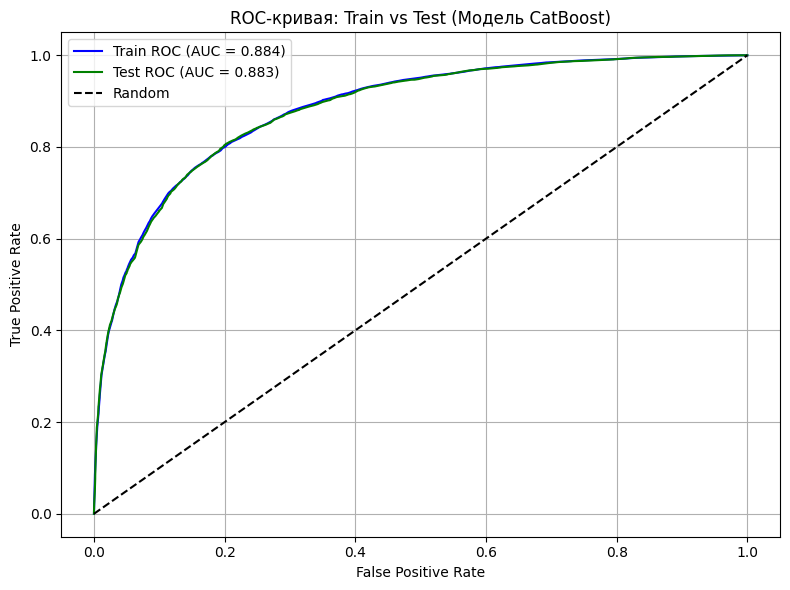

In [37]:
# ROC-кривая + AUC модели CatBoost
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_cb)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_cb)

auc_train = roc_auc_score(y_train, y_train_proba_cb)
auc_test = roc_auc_score(y_test, y_test_proba_cb)

# Построение ROC-графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})", color="blue")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})", color="green")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая: Train vs Test (Модель CatBoost)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Вывод метрик всех моделей

In [38]:
# Метрики логистической регрессии

print('Метрики логистической регрессии')

# Вывод результатов
print(f'Accuracy логистической регрессии: {accuracy_lr:.2f}')

print(f'Precision логистической регрессии: {precision_lr:.2f}')

print(f'Recall логистической регрессии: {recall_lr:.2f}')

print(f'F1-score логистической регрессии: {f1_lr:.2f}')

print(f'ROC-AUC логистической регрессии: {roc_auc_lr:.3f}')
print("-" * 50)

# Метрики дерева решений

print('Метрики дерева решений')

# Вывод результатов
print(f'Accuracy дерева решений: {accuracy_dt:.2f}')

print(f'Precision дерева решений: {precision_dt:.2f}')

print(f'Recall дерева решений: {recall_dt:.2f}')

print(f'F1-score дерева решений: {f1_dt:.2f}')

print(f'ROC-AUC дерева решений: {roc_auc_dt:.3f}')
print("-" * 50)

# Метрики модели XGBoost

print('Метрики модели XGBoost')

# Вывод результатов
print(f'Accuracy модели XGBoost: {accuracy_xgb:.2f}')

print(f'Precision модели XGBoost: {precision_xgb:.2f}')

print(f'Recall модели XGBoost: {recall_xgb:.2f}')

print(f'F1-score модели XGBoost: {f1_xgb:.2f}')

print(f'ROC-AUC модели XGBoost: {roc_auc_xgb:.3f}')
print("-" * 50)

# Метрики модели CatBoost

print('Метрики модели CatBoost')

# Вывод результатов
print(f'Accuracy модели CatBoost: {accuracy_cb:.2f}')

print(f'Precision модели CatBoost: {precision_cb:.2f}')

print(f'Recall модели CatBoost: {recall_cb:.2f}')

print(f'F1-score модели CatBoost: {f1_cb:.2f}')

print(f'ROC-AUC модели CatBoost: {roc_auc_cb:.3f}')

Метрики логистической регрессии
Accuracy логистической регрессии: 0.83
Precision логистической регрессии: 0.69
Recall логистической регрессии: 0.38
F1-score логистической регрессии: 0.49
ROC-AUC логистической регрессии: 0.815
--------------------------------------------------
Метрики дерева решений
Accuracy дерева решений: 0.86
Precision дерева решений: 0.74
Recall дерева решений: 0.54
F1-score дерева решений: 0.63
ROC-AUC дерева решений: 0.884
--------------------------------------------------
Метрики модели XGBoost
Accuracy модели XGBoost: 0.86
Precision модели XGBoost: 0.80
Recall модели XGBoost: 0.45
F1-score модели XGBoost: 0.57
ROC-AUC модели XGBoost: 0.880
--------------------------------------------------
Метрики модели CatBoost
Accuracy модели CatBoost: 0.86
Precision модели CatBoost: 0.75
Recall модели CatBoost: 0.51
F1-score модели CatBoost: 0.61
ROC-AUC модели CatBoost: 0.883


Вывод:

Как видим, наилучшей моделью является модель CatBoost

# <font color='#11a642' size='6'> **Итерпретация результатов c помощью shap, permitation feature importance, сравнение с результатами из ДЗ 9**

In [39]:
best_model_name = 'CatBoost'

In [40]:
best_model = CatBoostClassifier(random_state=42, iterations=9, depth=7, learning_rate=0.099, l2_leaf_reg=12, border_count=5)
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', best_model)
]) 

best_model_pipeline.fit(X_train, y_train)

0:	learn: 0.6391796	total: 70.2ms	remaining: 561ms
1:	learn: 0.5943935	total: 132ms	remaining: 462ms
2:	learn: 0.5569064	total: 198ms	remaining: 395ms
3:	learn: 0.5253370	total: 250ms	remaining: 313ms
4:	learn: 0.4988490	total: 304ms	remaining: 243ms
5:	learn: 0.4759483	total: 357ms	remaining: 179ms
6:	learn: 0.4566870	total: 408ms	remaining: 117ms
7:	learn: 0.4403469	total: 469ms	remaining: 58.7ms
8:	learn: 0.4256896	total: 571ms	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001BA414CB0B0>)])

In [41]:
# Получение предсказаний и оценка на тестовой выборке
y_prob_final = best_model_pipeline.predict_proba(X_test)[:, 1]
y_pred_final = best_model_pipeline.predict(X_test)

print(f"\nROC-AUC финальной модели ({best_model_name}): {roc_auc_score(y_test, y_prob_final):.4f}")
print(f"F1-score финальной модели ({best_model_name}): {f1_score(y_test, y_pred_final):.4f}")
print(f"Precision финальной модели ({best_model_name}): {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall финальной модели ({best_model_name}): {recall_score(y_test, y_pred_final):.4f}")
print(f'Accuracy финальной модели({best_model_name}): {accuracy_score(y_test, y_pred_final):.4f}')


ROC-AUC финальной модели (CatBoost): 0.8825
F1-score финальной модели (CatBoost): 0.6077
Precision финальной модели (CatBoost): 0.7479
Recall финальной модели (CatBoost): 0.5118
Accuracy финальной модели(CatBoost): 0.8602


Подготовка данных для интерпретации

In [42]:

# Получаем предобработанные данные для тестовой выборки, проходя через preprocessor
X_test_processed_for_shap = best_model_pipeline.named_steps['preprocessor'].transform(X_test)

In [43]:
# Убеждаемся, что X_test_processed_for_shap является плотным NumPy массивом
if hasattr(X_test_processed_for_shap, 'toarray'):
    X_test_processed_for_shap = X_test_processed_for_shap.toarray()

In [44]:
# Выведем числовые признаки
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

In [45]:
# Формируем список финальных имен признаков после OHE
feature_names_processed = numerical_features.copy()
ohe_transformer = best_model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
# get_feature_names_out() используется для получения имен колонок после OneHotEncoder
feature_names_processed.extend(ohe_transformer.get_feature_names_out(categorical_features))

In [46]:
# Преобразуем обработанные данные в DataFrame с явными именами колонок для SHAP
X_test_processed_for_shap_df = pd.DataFrame(X_test_processed_for_shap, columns=feature_names_processed)
print(f"Форма X_test_processed_for_shap_df (для ввода в SHAP Explainer): {X_test_processed_for_shap_df.shape}")

Форма X_test_processed_for_shap_df (для ввода в SHAP Explainer): (41259, 13)


Интерпретация с permutation_importance

In [47]:

# n_jobs=-1 использует все доступные ядра CPU
result_perm_imp = permutation_importance(
    best_model_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

In [48]:
# Получаем исходные имена признаков (до предобработки) для permutation_importance
original_feature_names = X.columns.tolist()

In [49]:
# Сортируем признаки по важности
sorted_idx_perm = result_perm_imp.importances_mean.argsort()[::-1]
sorted_features_perm = [original_feature_names[i] for i in sorted_idx_perm]
sorted_importances_perm = result_perm_imp.importances_mean[sorted_idx_perm]

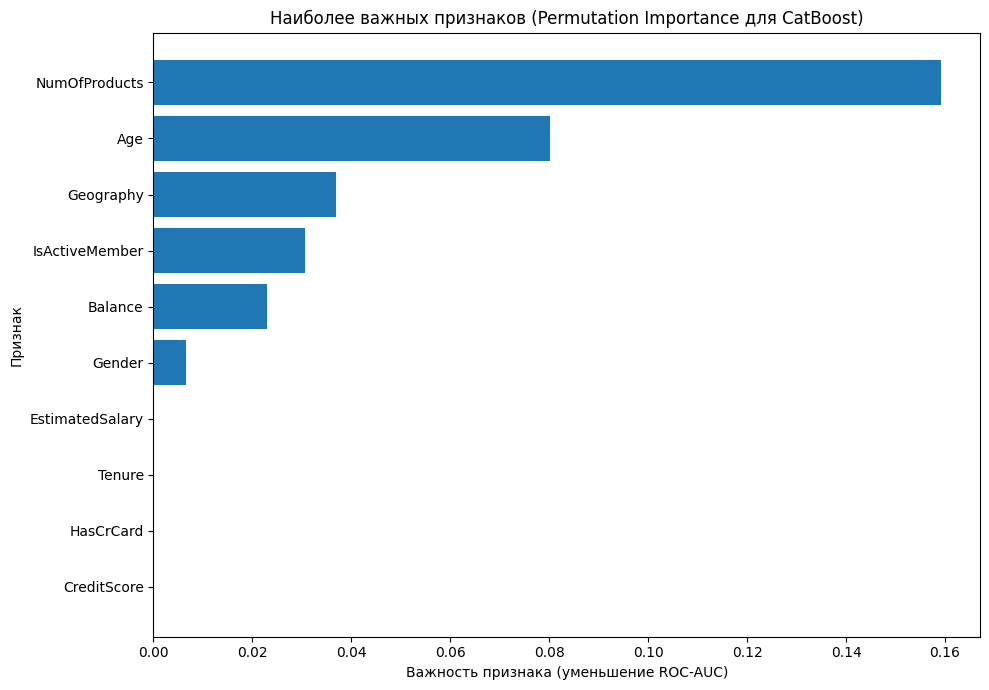

In [50]:
# Визуализация признаков

plt.figure(figsize=(10, 7))
plt.barh(sorted_features_perm, sorted_importances_perm)
plt.xlabel("Важность признака (уменьшение ROC-AUC)")
plt.ylabel("Признак")
plt.title(f"Наиболее важных признаков (Permutation Importance для {best_model_name})")
plt.gca().invert_yaxis() # Переворачиваем ось Y для лучшей читаемости
plt.tight_layout()
plt.show()

Как видно из графика, наиболее важным глобальным признаком для принятия решения уйдет клиент или останется является NumOfProducts

Интерпретация с SHAP

In [51]:
# Получаем обученный классификатор из пайплайна для SHAP
model_classifier_for_shap = best_model_pipeline.named_steps['classifier']
explainer_shap = shap.TreeExplainer(model_classifier_for_shap)

In [52]:
# Рассчитываем SHAP-значения для всей тестовой выборки
# Передаем DataFrame с явными именами колонок
shap_values_global = explainer_shap.shap_values(X_test_processed_for_shap_df)


SHAP Global Summary Plot (Bar)...
Форма shap_values_for_plot (перед потенциальным изменением формы): (13,)
Форма X_test_processed_for_shap_df: (41259, 13)


C:\Users\Maks\AppData\Local\Temp\ipykernel_11552\970373837.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_for_plot, X_data_for_summary_plots, feature_names=feature_names_processed, plot_type="bar", show=False)


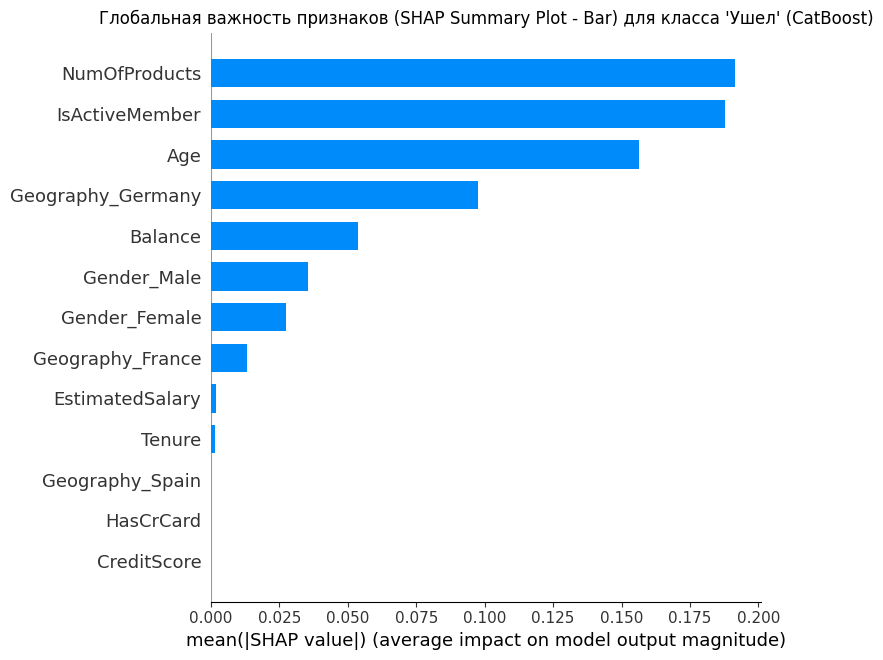

In [59]:
# SHAP Summary Plot (Bar) - Глобальная важность признаков
print("\nSHAP Global Summary Plot (Bar)...")
plt.figure(figsize=(10, 7))

shap_values_for_plot = shap_values_global[1]

print(f"Форма shap_values_for_plot (перед потенциальным изменением формы): {shap_values_for_plot.shape}")
print(f"Форма X_test_processed_for_shap_df: {X_test_processed_for_shap_df.shape}")

n_samples_X = X_test_processed_for_shap_df.shape[0]
n_features_X = X_test_processed_for_shap_df.shape[1]

# Переменная для данных признаков, используемых в summary/dependence plots
X_data_for_summary_plots = X_test_processed_for_shap_df.copy()

shap_values_for_plot = shap_values_for_plot.reshape(1, -1)
X_data_for_summary_plots = X_test_processed_for_shap_df.iloc[0:1, :] # Используем только первый образец

shap.summary_plot(shap_values_for_plot, X_data_for_summary_plots, feature_names=feature_names_processed, plot_type="bar", show=False)
plt.title(f"Глобальная важность признаков (SHAP Summary Plot - Bar) для класса 'Ушел' ({best_model_name})")
plt.tight_layout()
plt.show()

**SHAP Summary Plots** предоставляет детальное глобальное представление о важности признаков. Здесь мы также видим, что наиболее важным признаком является NumOfProducts


SHAP Global Summary Plot (Beeswarm)...


C:\Users\Maks\AppData\Local\Temp\ipykernel_11552\2861130936.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_for_plot, X_data_for_summary_plots, feature_names=feature_names_processed, show=False)


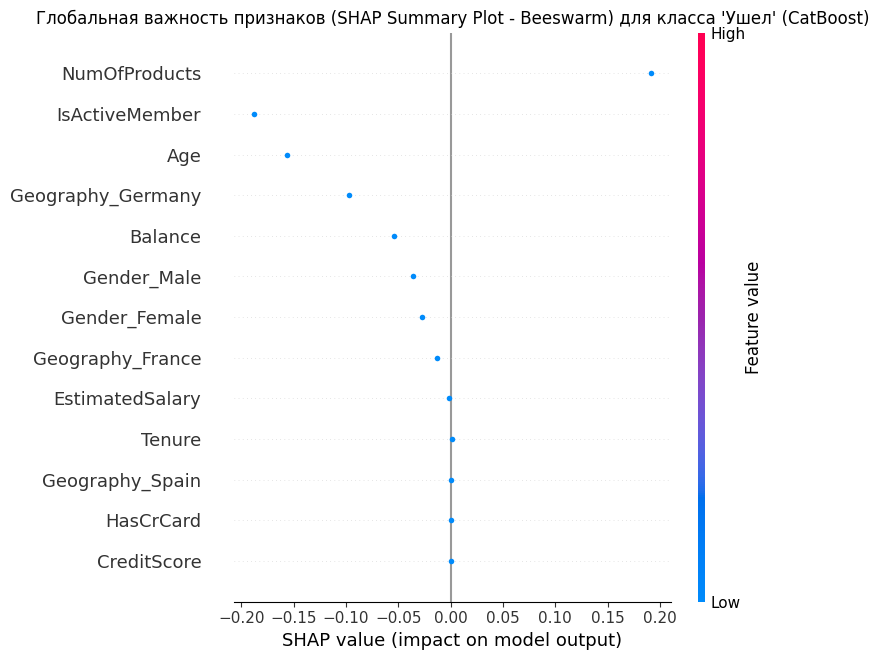

In [60]:
# SHAP Summary Plot (Beeswarm) - Глобальная важность признаков с распределением
print("\nSHAP Global Summary Plot (Beeswarm)...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_for_plot, X_data_for_summary_plots, feature_names=feature_names_processed, show=False)
plt.title(f"Глобальная важность признаков (SHAP Summary Plot - Beeswarm) для класса 'Ушел' ({best_model_name})")
plt.tight_layout() # ИСправлено: plt.layout() на plt.tight_layout()
plt.show()

На этом графике мы видим помимо важности признаков, ещи и направление их вляиния на результат работы модели


--- SHAP Waterfall Plots для конкретных примеров ---
  Форма instance_data_for_shap_plot_df (для расчета индивидуальных SHAP): (1, 13)

--- Клиент 1 (Истинная метка: Ушел) ---
Предсказанная вероятность ухода: 0.3108


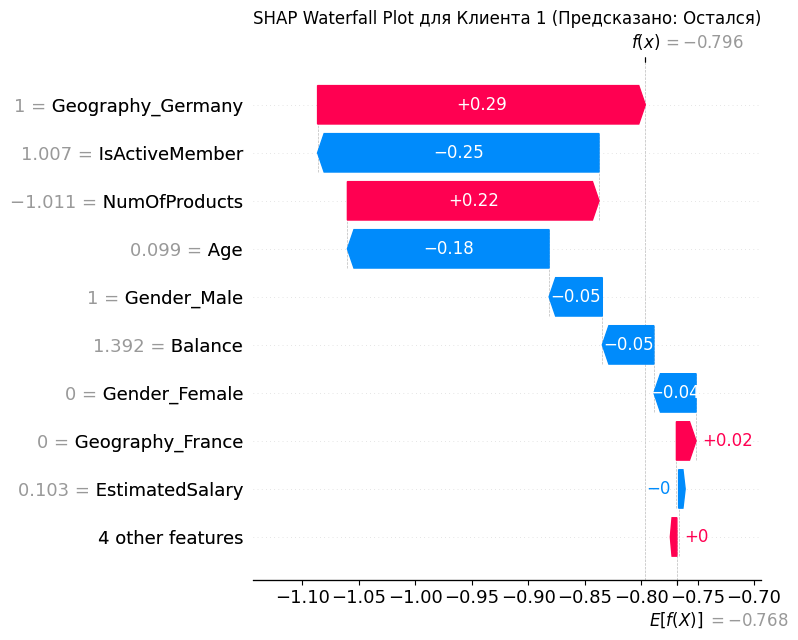

  Форма instance_data_for_shap_plot_df (для расчета индивидуальных SHAP): (1, 13)

--- Клиент 2 (Истинная метка: Остался) ---
Предсказанная вероятность ухода: 0.2567


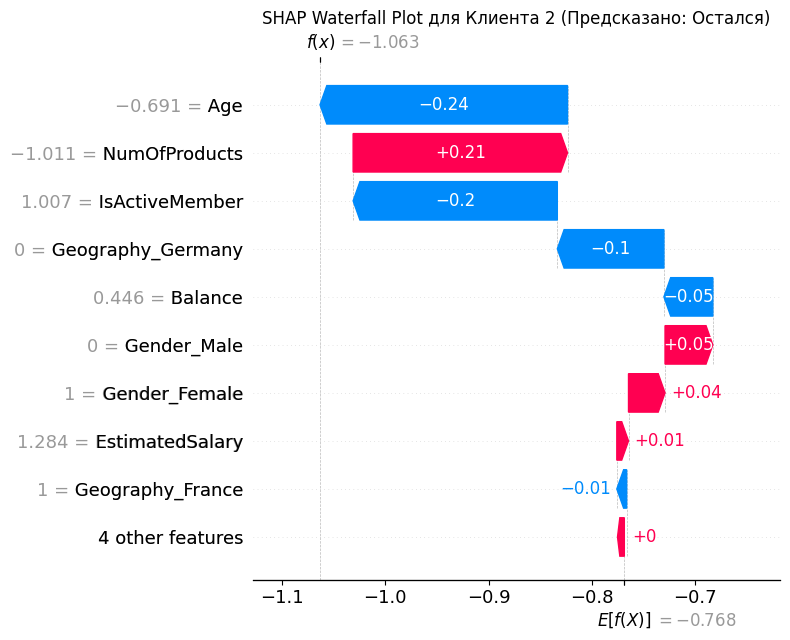

In [55]:
# Интерпретация конкретных предсказаний (SHAP Waterfall Plot)
print("\n--- SHAP Waterfall Plots для конкретных примеров ---")
np.random.seed(42) # Для воспроизводимости выбора случайных клиентов

# Получаем индексы ушедших и оставшихся клиентов в исходном X_test
exited_indices_in_X_test = y_test[y_test == 1].index
non_exited_indices_in_X_test = y_test[y_test == 0].index

sample_indices_for_waterfall_plot_locs = [] # Список для хранения локальных индексов в X_test

# Выбираем 1 ушедшего клиента (если есть)
if not exited_indices_in_X_test.empty:
    sample_exited_original_idx = np.random.choice(exited_indices_in_X_test, 1, replace=False)[0]
    # Получаем локальный индекс этого клиента в X_test (поскольку X_test может быть не отсортирован по исходным индексам)
    sample_exited_test_loc = X_test.index.get_loc(sample_exited_original_idx)
    sample_indices_for_waterfall_plot_locs.append(sample_exited_test_loc)
else:
    print("Внимание: В тестовой выборке нет ушедших клиентов для выборки примера Waterfall Plot.")

# Выбираем 1 оставшегося клиента (если есть)
if not non_exited_indices_in_X_test.empty:
    sample_non_exited_original_idx = np.random.choice(non_exited_indices_in_X_test, 1, replace=False)[0]
    sample_non_exited_test_loc = X_test.index.get_loc(sample_non_exited_original_idx)
    sample_indices_for_waterfall_plot_locs.append(sample_non_exited_test_loc)
else:
    print("Внимание: В тестовой выборке нет оставшихся клиентов для выборки примера Waterfall Plot.")


for i, idx_in_test_set_loc in enumerate(sample_indices_for_waterfall_plot_locs):
    true_label = y_test.iloc[idx_in_test_set_loc]
    instance_prediction_proba = y_prob_final[idx_in_test_set_loc]

    # Получаем один экземпляр как DataFrame (1 строка, N колонок)
    instance_data_for_shap_plot_df = X_test_processed_for_shap_df.iloc[[idx_in_test_set_loc]]

    print(f"  Форма instance_data_for_shap_plot_df (для расчета индивидуальных SHAP): {instance_data_for_shap_plot_df.shape}")

    # Вычисление SHAP-значений для конкретного экземпляра
    # Передаем DataFrame, CatBoostExplainer лучше работает с ним
    shap_values_instance = explainer_shap.shap_values(instance_data_for_shap_plot_df)

    # expected_value может быть скалярным, если модель выводит log-odds напрямую
    expected_value = explainer_shap.expected_value

    # Если shap_values_instance[1] имеет форму (1, N_features), нам нужно взять [0] для получения 1D массива
    # Это важно для shap.Explanation и waterfall_plot
    if isinstance(shap_values_instance, list) and len(shap_values_instance) > 1:
        # Для бинарной классификации, берем SHAP значения для положительного класса (индекс 1)
        shap_values_for_waterfall = shap_values_instance[1][0] if shap_values_instance[1].ndim > 1 else shap_values_instance[1]
    else:
        # Если shap_values_instance не список (т.е. один массив) или список с одним элементом, используем его напрямую
        shap_values_for_waterfall = shap_values_instance[0] if shap_values_instance.ndim > 1 else shap_values_instance


    print(f"\n--- Клиент {i+1} (Истинная метка: {'Ушел' if true_label == 1 else 'Остался'}) ---")
    print(f"Предсказанная вероятность ухода: {instance_prediction_proba:.4f}")

    # Для waterfall_plot 'data' аргумент должен быть 1D (numpy array или Series)
    data_for_waterfall_plot = instance_data_for_shap_plot_df.iloc[0].values

    shap.waterfall_plot(shap.Explanation(values=shap_values_for_waterfall, # SHAP-значения для класса 'Ушел' (1D)
                                        base_values=expected_value, # Базовая ожидаемая вероятность
                                        data=data_for_waterfall_plot, # Исходные значения признаков для экземпляра (1D numpy array)
                                        feature_names=feature_names_processed), show=False) # Имена признаков
    plt.title(f"SHAP Waterfall Plot для Клиента {i+1} (Предсказано: {'Ушел' if instance_prediction_proba > 0.5 else 'Остался'})")
    plt.tight_layout()
    plt.show()


**SHAP Waterfall Plots** объясняют каждое индивидуальное предсказание, разлагая его на вклад каждого признака от базовой линии.

Сравниение с результатами из ДЗ 9

Результаты работы из  ДЗ 9

Accuracy логистической регрессии: 0.83

Accuracy логистической регрессии с регуляризацией: 0.83

Precision логистической регрессии: 0.69

Precision логистической регрессии с регуляризацией: 0.69

Recall логистической регрессии: 0.38

Recall логистической регрессии с регуляризацией: 0.38

F1-score логистической регрессии: 0.49

F1-score логистической регрессии с регуляризацией: 0.49

ROC-AUC логистической регрессии: 0.815

ROC-AUC логистической регрессии с регуляризацией: 0.815

In [56]:
# Результаты финальной модели

print(f"\nROC-AUC финальной модели ({best_model_name}): {roc_auc_score(y_test, y_prob_final):.4f}")
print(f"F1-score финальной модели ({best_model_name}): {f1_score(y_test, y_pred_final):.4f}")
print(f"Precision финальной модели ({best_model_name}): {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall финальной модели ({best_model_name}): {recall_score(y_test, y_pred_final):.4f}")
print(f'Accuracy финальной модели({best_model_name}): {accuracy_score(y_test, y_pred_final):.4f}')


ROC-AUC финальной модели (CatBoost): 0.8825
F1-score финальной модели (CatBoost): 0.6077
Precision финальной модели (CatBoost): 0.7479
Recall финальной модели (CatBoost): 0.5118
Accuracy финальной модели(CatBoost): 0.8602


Вывод

Как видим, результаты модели CatBoost  с использование Pipeline оказались намного лучше моделей, использованных в ДЗ 9